## Data loading and visualisation

In [ ]:
import random
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision.models import resnet18, mobilenet_v2, vgg16
from torch.amp import autocast, GradScaler
from tqdm import tqdm 
import optuna 

In [2]:
def load_batch(file_path):
    """Load a single batch file and return images and labels."""
    with open(file_path, 'rb') as file:
        batch = pickle.load(file, encoding='latin1')  # or 'bytes' for older CIFAR files
    images = batch['data']
    labels = batch['labels']
    return np.array(images), np.array(labels)

def load_data(train_files, test_file):
    """Load multiple training batch files and one test file."""
    train_images, train_labels = [], []

    # Load and append each training batch
    for file in train_files:
        images, labels = load_batch(file)
        train_images.append(images)
        train_labels.append(labels)

    # Stack to form complete training data
    train_images = np.concatenate(train_images)
    train_labels = np.concatenate(train_labels)

    # Load test data
    test_images, test_labels = load_batch(test_file)

    return train_images, train_labels, test_images, test_labels

# Example usage

train_files = [
    'D:/dEEP LEARNING/assignment 2/cifar-10-batches-py/data_batch_1',
    'D:/dEEP LEARNING/assignment 2/cifar-10-batches-py/data_batch_2',
    'D:/dEEP LEARNING/assignment 2/cifar-10-batches-py/data_batch_3',
    'D:/dEEP LEARNING/assignment 2/cifar-10-batches-py/data_batch_4',
    'D:/dEEP LEARNING/assignment 2/cifar-10-batches-py/data_batch_5'
]  # Add paths to all desired training batches
test_file ='D:/dEEP LEARNING/assignment 2/cifar-10-batches-py/test_batch'  # Path to your test batch
train_images, train_labels, test_images, test_labels = load_data(train_files, test_file)


#### Visualisation

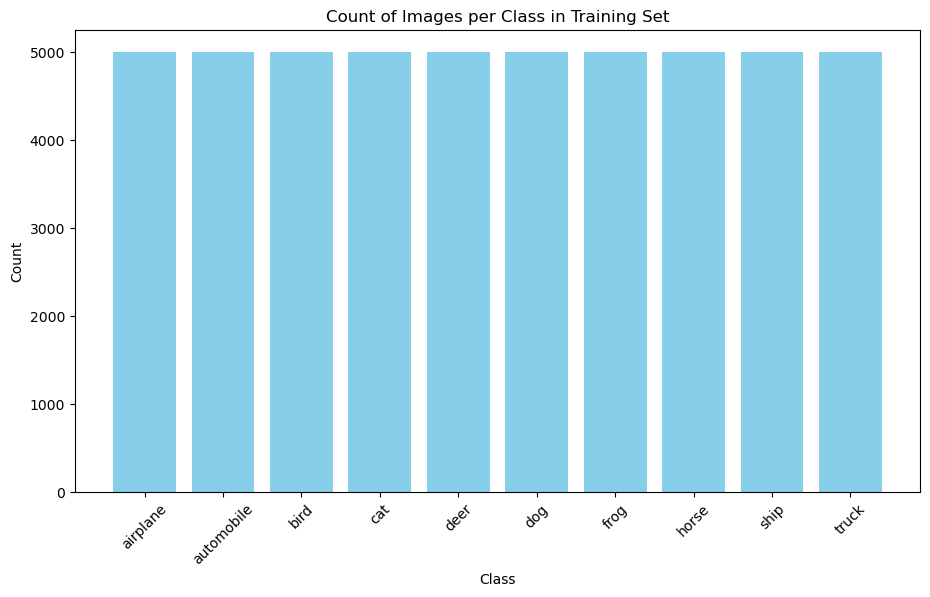

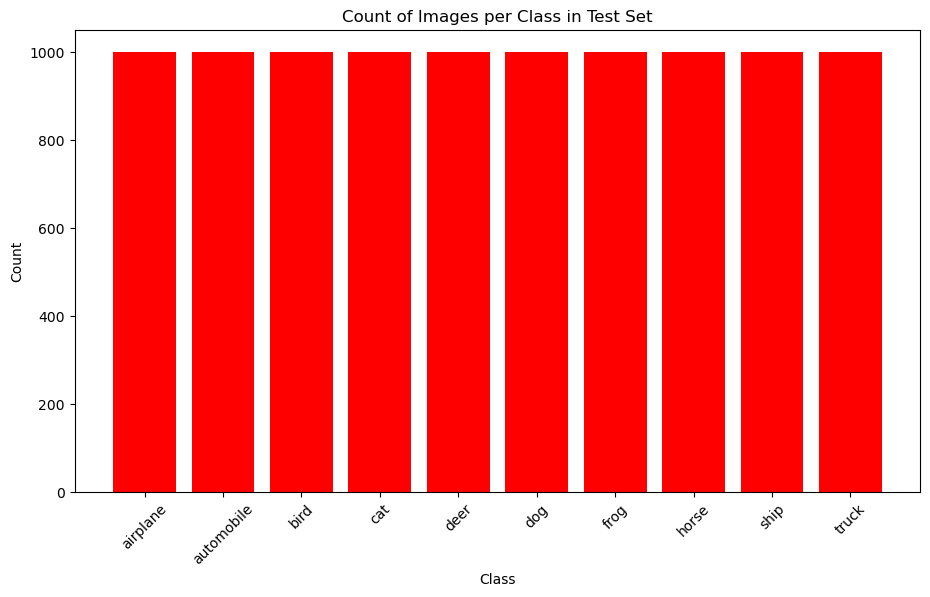

In [17]:
# Define class names for CIFAR-10 dataset
with open('D:/dEEP LEARNING/assignment 2/cifar-10-batches-py/batches.meta', 'rb') as file:
    meta_data = pickle.load(file)
    class_names = meta_data['label_names']
# Calculate counts of each class in the training labels
label_counts = np.bincount(train_labels, minlength=10)
test_label_counts = np.bincount(test_labels, minlength=10)
# Plot histogram
plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
plt.bar(class_names, label_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of Images per Class in Training Set')
plt.xticks(rotation=45)
plt.show()
# Plot histogram
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 2)
plt.bar(class_names, test_label_counts, color='red')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of Images per Class in Test Set')
plt.xticks(rotation=45)
plt.show()

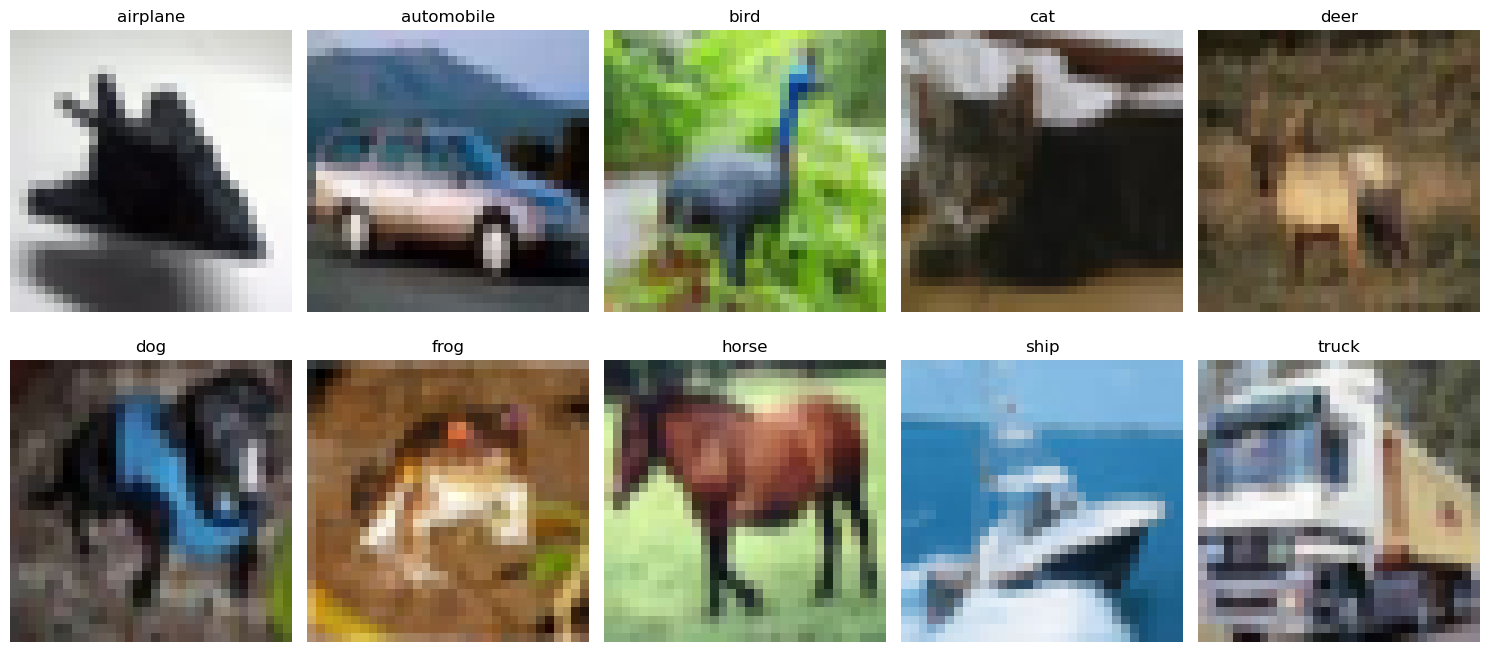

In [ ]:
def display_image(images, labels, class_names, num_classes=10):
    class_examples = {}
    
    for img, label in zip(images, labels):
        if label not in class_examples:
            class_examples[label] = img
        if len(class_examples) == num_classes:
            break
    # Plotting
    plt.figure(figsize=(15, 7))
    
    for class_id, img in class_examples.items():
        img = img.reshape(3, 32, 32).transpose(1, 2, 0)
        
        plt.subplot(2, 5, class_id + 1)
        plt.imshow(img.astype('uint8'))
        plt.title(f"{class_names[class_id]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_image(train_images, train_labels, class_names)


## Preprocessing

In [21]:
class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels.astype(np.int64) 
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(3, 32, 32).astype(np.float32) / 255.0  
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Converting label to LongTensor
        image = torch.tensor(image, dtype=torch.float32)  # Converting to tensor

        if self.transform:
            image = self.transform(image)

        return image, label

# Basic Data augmentation and normalisation
transform = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
transform1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
train_dataset = CIFAR10Dataset(train_images, train_labels, transform=transform1)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
val_dataset.transform = transform 
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print("Data preparation complete. Ready!")

Data preparation complete. Ready!


In [ ]:
#ensuring the training runs on GPU
device = torch.device('cuda')
print(device)

cuda


## ResNet18

In [ ]:
# Baseline ResNet-18 model without pretrained weights
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = resnet18(weights=None)
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        return self.model(x)

In [ ]:
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
scaler = GradScaler("cuda")
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    model.train() 
    best_val_loss = float('inf')  
    epochs_without_improvement = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast(device_type="cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss) 
        train_accuracies.append(train_accuracy)
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                with autocast("cuda"):
                    outputs = model(images)
                    val_loss = criterion(outputs, labels)

                val_running_loss += val_loss.item()
                _, val_predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (val_predicted == labels).sum().item()
        val_loss_avg = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss_avg) 
        val_accuracies.append(val_accuracy) 
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | Val Loss: {val_loss_avg:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs without improvement.")
            break

In [5]:
train(model, train_loader, val_loader,criterion, optimizer, num_epochs=50,patience=5)
print("Training and evaluation complete!")

Epoch 1/50: 100%|██████████| 313/313 [00:07<00:00, 40.92it/s]


Epoch [1/50] - Train Loss: 1.7305, Train Accuracy: 37.82% | Val Loss: 1.4744, Val Accuracy: 46.58%


Epoch 2/50: 100%|██████████| 313/313 [00:07<00:00, 42.58it/s]


Epoch [2/50] - Train Loss: 1.9415, Train Accuracy: 36.34% | Val Loss: 1.5523, Val Accuracy: 42.64%


Epoch 3/50: 100%|██████████| 313/313 [00:07<00:00, 42.33it/s]


Epoch [3/50] - Train Loss: 1.3680, Train Accuracy: 50.62% | Val Loss: 1.3202, Val Accuracy: 51.66%


Epoch 4/50: 100%|██████████| 313/313 [00:07<00:00, 43.19it/s]


Epoch [4/50] - Train Loss: 1.2141, Train Accuracy: 56.50% | Val Loss: 1.2826, Val Accuracy: 54.29%


Epoch 5/50: 100%|██████████| 313/313 [00:07<00:00, 43.63it/s]


Epoch [5/50] - Train Loss: 1.1004, Train Accuracy: 60.99% | Val Loss: 1.1683, Val Accuracy: 58.32%


Epoch 6/50: 100%|██████████| 313/313 [00:07<00:00, 43.49it/s]


Epoch [6/50] - Train Loss: 1.0214, Train Accuracy: 63.87% | Val Loss: 1.1014, Val Accuracy: 61.02%


Epoch 7/50: 100%|██████████| 313/313 [00:07<00:00, 43.35it/s]


Epoch [7/50] - Train Loss: 0.9585, Train Accuracy: 66.41% | Val Loss: 0.9684, Val Accuracy: 66.06%


Epoch 8/50: 100%|██████████| 313/313 [00:07<00:00, 43.33it/s]


Epoch [8/50] - Train Loss: 0.9021, Train Accuracy: 68.22% | Val Loss: 1.1949, Val Accuracy: 58.90%


Epoch 9/50: 100%|██████████| 313/313 [00:07<00:00, 43.77it/s]


Epoch [9/50] - Train Loss: 0.8558, Train Accuracy: 69.97% | Val Loss: 1.1045, Val Accuracy: 63.30%


Epoch 10/50: 100%|██████████| 313/313 [00:07<00:00, 43.33it/s]


Epoch [10/50] - Train Loss: 0.8128, Train Accuracy: 71.56% | Val Loss: 0.9154, Val Accuracy: 68.60%


Epoch 11/50: 100%|██████████| 313/313 [00:07<00:00, 43.41it/s]


Epoch [11/50] - Train Loss: 0.7805, Train Accuracy: 72.63% | Val Loss: 0.8360, Val Accuracy: 70.95%


Epoch 12/50: 100%|██████████| 313/313 [00:07<00:00, 42.41it/s]


Epoch [12/50] - Train Loss: 0.7481, Train Accuracy: 73.82% | Val Loss: 0.7884, Val Accuracy: 72.59%


Epoch 13/50: 100%|██████████| 313/313 [00:07<00:00, 43.68it/s]


Epoch [13/50] - Train Loss: 0.7161, Train Accuracy: 74.96% | Val Loss: 0.8094, Val Accuracy: 72.27%


Epoch 14/50: 100%|██████████| 313/313 [00:07<00:00, 43.76it/s]


Epoch [14/50] - Train Loss: 0.6939, Train Accuracy: 75.58% | Val Loss: 0.8129, Val Accuracy: 72.44%


Epoch 15/50: 100%|██████████| 313/313 [00:07<00:00, 43.45it/s]


Epoch [15/50] - Train Loss: 0.6734, Train Accuracy: 76.40% | Val Loss: 0.7915, Val Accuracy: 73.03%


Epoch 16/50: 100%|██████████| 313/313 [00:07<00:00, 43.86it/s]


Epoch [16/50] - Train Loss: 0.6426, Train Accuracy: 77.30% | Val Loss: 0.7716, Val Accuracy: 73.64%


Epoch 17/50: 100%|██████████| 313/313 [00:07<00:00, 43.52it/s]


Epoch [17/50] - Train Loss: 0.6258, Train Accuracy: 78.38% | Val Loss: 0.7408, Val Accuracy: 74.55%


Epoch 18/50: 100%|██████████| 313/313 [00:07<00:00, 43.65it/s]


Epoch [18/50] - Train Loss: 0.6134, Train Accuracy: 78.50% | Val Loss: 0.7346, Val Accuracy: 75.42%


Epoch 19/50: 100%|██████████| 313/313 [00:07<00:00, 43.52it/s]


Epoch [19/50] - Train Loss: 0.5924, Train Accuracy: 79.40% | Val Loss: 0.7922, Val Accuracy: 73.57%


Epoch 20/50: 100%|██████████| 313/313 [00:07<00:00, 43.30it/s]


Epoch [20/50] - Train Loss: 0.5763, Train Accuracy: 79.81% | Val Loss: 0.7102, Val Accuracy: 76.12%


Epoch 21/50: 100%|██████████| 313/313 [00:07<00:00, 43.34it/s]


Epoch [21/50] - Train Loss: 0.5629, Train Accuracy: 80.27% | Val Loss: 0.7875, Val Accuracy: 74.24%


Epoch 22/50: 100%|██████████| 313/313 [00:07<00:00, 43.39it/s]


Epoch [22/50] - Train Loss: 0.5508, Train Accuracy: 80.79% | Val Loss: 0.7348, Val Accuracy: 75.37%


Epoch 23/50: 100%|██████████| 313/313 [00:07<00:00, 43.25it/s]


Epoch [23/50] - Train Loss: 0.5339, Train Accuracy: 81.20% | Val Loss: 0.8704, Val Accuracy: 72.03%


Epoch 24/50: 100%|██████████| 313/313 [00:07<00:00, 43.53it/s]


Epoch [24/50] - Train Loss: 0.5208, Train Accuracy: 81.78% | Val Loss: 0.7803, Val Accuracy: 74.39%


Epoch 25/50: 100%|██████████| 313/313 [00:07<00:00, 43.66it/s]


Epoch [25/50] - Train Loss: 0.5071, Train Accuracy: 82.13% | Val Loss: 0.7118, Val Accuracy: 76.32%
Early stopping triggered after 25 epochs without improvement.
Training and evaluation complete!


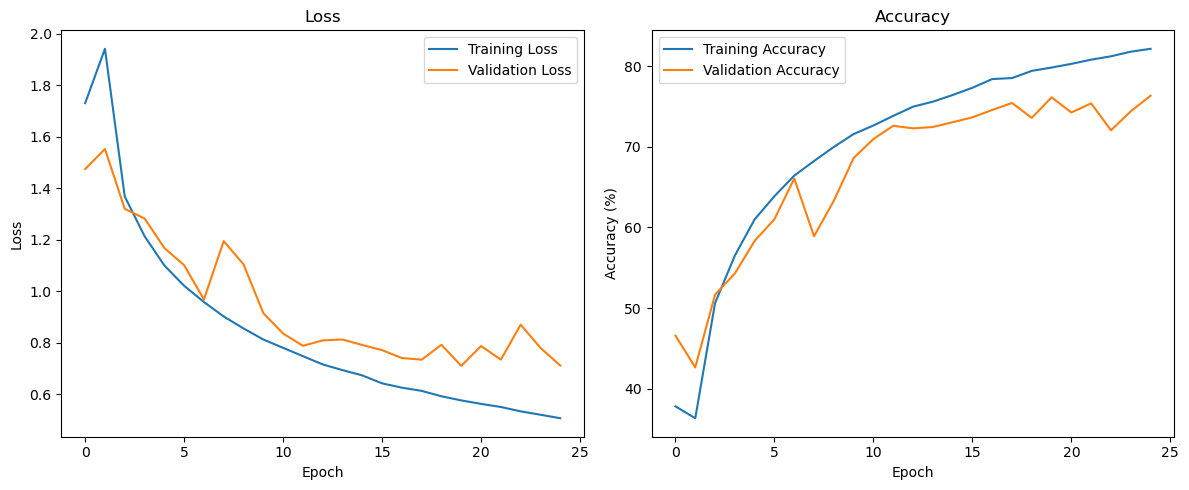

In [ ]:
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
def test(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradients needed for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

In [8]:
# Test the model
test(model, test_loader)

Test Accuracy: 78.03%


#### With SGD optimiser

Epoch 1/50: 100%|██████████| 313/313 [00:07<00:00, 44.24it/s]


Epoch [1/50] - Train Loss: 2.2080, Train Accuracy: 19.05% | Val Loss: 2.0457, Val Accuracy: 25.28%


Epoch 2/50: 100%|██████████| 313/313 [00:07<00:00, 44.61it/s]


Epoch [2/50] - Train Loss: 1.9314, Train Accuracy: 29.03% | Val Loss: 1.8488, Val Accuracy: 31.59%


Epoch 3/50: 100%|██████████| 313/313 [00:06<00:00, 45.39it/s]


Epoch [3/50] - Train Loss: 1.7935, Train Accuracy: 33.90% | Val Loss: 1.7494, Val Accuracy: 34.88%


Epoch 4/50: 100%|██████████| 313/313 [00:06<00:00, 44.73it/s]


Epoch [4/50] - Train Loss: 1.7130, Train Accuracy: 37.00% | Val Loss: 1.6649, Val Accuracy: 38.79%


Epoch 5/50: 100%|██████████| 313/313 [00:07<00:00, 44.57it/s]


Epoch [5/50] - Train Loss: 1.6506, Train Accuracy: 38.89% | Val Loss: 1.6241, Val Accuracy: 39.95%


Epoch 6/50: 100%|██████████| 313/313 [00:07<00:00, 44.62it/s]


Epoch [6/50] - Train Loss: 1.6067, Train Accuracy: 40.65% | Val Loss: 1.5641, Val Accuracy: 42.12%


Epoch 7/50: 100%|██████████| 313/313 [00:06<00:00, 45.72it/s]


Epoch [7/50] - Train Loss: 1.5663, Train Accuracy: 42.02% | Val Loss: 1.5448, Val Accuracy: 43.01%


Epoch 8/50: 100%|██████████| 313/313 [00:07<00:00, 44.27it/s]


Epoch [8/50] - Train Loss: 1.5361, Train Accuracy: 43.41% | Val Loss: 1.5867, Val Accuracy: 42.03%


Epoch 9/50: 100%|██████████| 313/313 [00:06<00:00, 45.31it/s]


Epoch [9/50] - Train Loss: 1.5023, Train Accuracy: 44.62% | Val Loss: 1.4944, Val Accuracy: 45.34%


Epoch 10/50: 100%|██████████| 313/313 [00:07<00:00, 43.49it/s]


Epoch [10/50] - Train Loss: 1.4806, Train Accuracy: 45.82% | Val Loss: 1.4897, Val Accuracy: 45.24%


Epoch 11/50: 100%|██████████| 313/313 [00:06<00:00, 44.87it/s]


Epoch [11/50] - Train Loss: 1.4552, Train Accuracy: 46.80% | Val Loss: 1.4687, Val Accuracy: 45.68%


Epoch 12/50: 100%|██████████| 313/313 [00:07<00:00, 44.64it/s]


Epoch [12/50] - Train Loss: 1.4356, Train Accuracy: 47.39% | Val Loss: 1.4203, Val Accuracy: 47.74%


Epoch 13/50: 100%|██████████| 313/313 [00:06<00:00, 44.77it/s]


Epoch [13/50] - Train Loss: 1.4133, Train Accuracy: 48.18% | Val Loss: 1.4004, Val Accuracy: 48.46%


Epoch 14/50: 100%|██████████| 313/313 [00:07<00:00, 44.33it/s]


Epoch [14/50] - Train Loss: 1.3907, Train Accuracy: 49.20% | Val Loss: 1.4457, Val Accuracy: 47.23%


Epoch 15/50: 100%|██████████| 313/313 [00:07<00:00, 43.35it/s]


Epoch [15/50] - Train Loss: 1.3737, Train Accuracy: 49.97% | Val Loss: 1.3798, Val Accuracy: 49.31%


Epoch 16/50: 100%|██████████| 313/313 [00:07<00:00, 44.01it/s]


Epoch [16/50] - Train Loss: 1.3560, Train Accuracy: 50.72% | Val Loss: 1.3512, Val Accuracy: 50.93%


Epoch 17/50: 100%|██████████| 313/313 [00:07<00:00, 44.08it/s]


Epoch [17/50] - Train Loss: 1.3366, Train Accuracy: 51.57% | Val Loss: 1.3820, Val Accuracy: 50.67%


Epoch 18/50: 100%|██████████| 313/313 [00:07<00:00, 44.48it/s]


Epoch [18/50] - Train Loss: 1.3236, Train Accuracy: 51.83% | Val Loss: 1.3149, Val Accuracy: 52.26%


Epoch 19/50: 100%|██████████| 313/313 [00:07<00:00, 44.16it/s]


Epoch [19/50] - Train Loss: 1.3032, Train Accuracy: 53.01% | Val Loss: 1.3092, Val Accuracy: 52.38%


Epoch 20/50: 100%|██████████| 313/313 [00:07<00:00, 43.97it/s]


Epoch [20/50] - Train Loss: 1.2872, Train Accuracy: 53.58% | Val Loss: 1.2901, Val Accuracy: 53.44%


Epoch 21/50: 100%|██████████| 313/313 [00:07<00:00, 44.38it/s]


Epoch [21/50] - Train Loss: 1.2773, Train Accuracy: 53.51% | Val Loss: 1.2532, Val Accuracy: 54.46%


Epoch 22/50: 100%|██████████| 313/313 [00:07<00:00, 44.14it/s]


Epoch [22/50] - Train Loss: 1.2618, Train Accuracy: 54.63% | Val Loss: 1.2590, Val Accuracy: 54.21%


Epoch 23/50: 100%|██████████| 313/313 [00:07<00:00, 42.93it/s]


Epoch [23/50] - Train Loss: 1.2496, Train Accuracy: 54.68% | Val Loss: 1.2706, Val Accuracy: 53.93%


Epoch 24/50: 100%|██████████| 313/313 [00:07<00:00, 42.85it/s]


Epoch [24/50] - Train Loss: 1.2320, Train Accuracy: 55.32% | Val Loss: 1.2790, Val Accuracy: 53.69%


Epoch 25/50: 100%|██████████| 313/313 [00:07<00:00, 44.16it/s]


Epoch [25/50] - Train Loss: 1.2179, Train Accuracy: 55.99% | Val Loss: 1.2310, Val Accuracy: 55.59%


Epoch 26/50: 100%|██████████| 313/313 [00:07<00:00, 44.45it/s]


Epoch [26/50] - Train Loss: 1.2137, Train Accuracy: 56.02% | Val Loss: 1.2390, Val Accuracy: 54.72%


Epoch 27/50: 100%|██████████| 313/313 [00:07<00:00, 44.14it/s]


Epoch [27/50] - Train Loss: 1.2020, Train Accuracy: 56.55% | Val Loss: 1.2325, Val Accuracy: 55.25%


Epoch 28/50: 100%|██████████| 313/313 [00:07<00:00, 44.15it/s]


Epoch [28/50] - Train Loss: 1.1859, Train Accuracy: 57.17% | Val Loss: 1.2176, Val Accuracy: 56.00%


Epoch 29/50: 100%|██████████| 313/313 [00:07<00:00, 44.18it/s]


Epoch [29/50] - Train Loss: 1.1759, Train Accuracy: 57.49% | Val Loss: 1.1786, Val Accuracy: 57.39%


Epoch 30/50: 100%|██████████| 313/313 [00:07<00:00, 44.24it/s]


Epoch [30/50] - Train Loss: 1.1675, Train Accuracy: 57.91% | Val Loss: 1.1785, Val Accuracy: 57.00%


Epoch 31/50: 100%|██████████| 313/313 [00:07<00:00, 44.35it/s]


Epoch [31/50] - Train Loss: 1.1566, Train Accuracy: 58.34% | Val Loss: 1.1849, Val Accuracy: 57.91%


Epoch 32/50: 100%|██████████| 313/313 [00:06<00:00, 44.86it/s]


Epoch [32/50] - Train Loss: 1.1534, Train Accuracy: 58.49% | Val Loss: 1.1473, Val Accuracy: 58.57%


Epoch 33/50: 100%|██████████| 313/313 [00:07<00:00, 44.26it/s]


Epoch [33/50] - Train Loss: 1.1388, Train Accuracy: 59.30% | Val Loss: 1.1590, Val Accuracy: 58.15%


Epoch 34/50: 100%|██████████| 313/313 [00:07<00:00, 44.42it/s]


Epoch [34/50] - Train Loss: 1.1288, Train Accuracy: 59.19% | Val Loss: 1.1926, Val Accuracy: 56.35%


Epoch 35/50: 100%|██████████| 313/313 [00:06<00:00, 44.72it/s]


Epoch [35/50] - Train Loss: 1.1210, Train Accuracy: 59.57% | Val Loss: 1.1368, Val Accuracy: 58.59%


Epoch 36/50: 100%|██████████| 313/313 [00:07<00:00, 44.45it/s]


Epoch [36/50] - Train Loss: 1.1045, Train Accuracy: 60.15% | Val Loss: 1.1642, Val Accuracy: 57.85%


Epoch 37/50: 100%|██████████| 313/313 [00:07<00:00, 44.58it/s]


Epoch [37/50] - Train Loss: 1.1010, Train Accuracy: 60.44% | Val Loss: 1.1315, Val Accuracy: 58.95%


Epoch 38/50: 100%|██████████| 313/313 [00:07<00:00, 44.46it/s]


Epoch [38/50] - Train Loss: 1.0976, Train Accuracy: 60.62% | Val Loss: 1.1250, Val Accuracy: 59.76%


Epoch 39/50: 100%|██████████| 313/313 [00:07<00:00, 44.31it/s]


Epoch [39/50] - Train Loss: 1.0874, Train Accuracy: 60.92% | Val Loss: 1.1024, Val Accuracy: 60.90%


Epoch 40/50: 100%|██████████| 313/313 [00:07<00:00, 44.33it/s]


Epoch [40/50] - Train Loss: 1.0763, Train Accuracy: 61.60% | Val Loss: 1.0983, Val Accuracy: 60.44%


Epoch 41/50: 100%|██████████| 313/313 [00:06<00:00, 44.93it/s]


Epoch [41/50] - Train Loss: 1.0767, Train Accuracy: 61.24% | Val Loss: 1.0921, Val Accuracy: 60.65%


Epoch 42/50: 100%|██████████| 313/313 [00:07<00:00, 44.71it/s]


Epoch [42/50] - Train Loss: 1.0689, Train Accuracy: 61.59% | Val Loss: 1.0920, Val Accuracy: 60.67%


Epoch 43/50: 100%|██████████| 313/313 [00:07<00:00, 44.33it/s]


Epoch [43/50] - Train Loss: 1.0569, Train Accuracy: 62.00% | Val Loss: 1.1281, Val Accuracy: 60.03%


Epoch 44/50: 100%|██████████| 313/313 [00:07<00:00, 42.55it/s]


Epoch [44/50] - Train Loss: 1.0498, Train Accuracy: 62.27% | Val Loss: 1.0793, Val Accuracy: 61.49%


Epoch 45/50: 100%|██████████| 313/313 [00:07<00:00, 43.63it/s]


Epoch [45/50] - Train Loss: 1.0461, Train Accuracy: 62.62% | Val Loss: 1.1135, Val Accuracy: 59.87%


Epoch 46/50: 100%|██████████| 313/313 [00:07<00:00, 43.13it/s]


Epoch [46/50] - Train Loss: 1.0317, Train Accuracy: 62.80% | Val Loss: 1.0660, Val Accuracy: 61.68%


Epoch 47/50: 100%|██████████| 313/313 [00:07<00:00, 42.15it/s]


Epoch [47/50] - Train Loss: 1.0306, Train Accuracy: 62.99% | Val Loss: 1.0957, Val Accuracy: 60.76%


Epoch 48/50: 100%|██████████| 313/313 [00:07<00:00, 43.70it/s]


Epoch [48/50] - Train Loss: 1.0242, Train Accuracy: 63.19% | Val Loss: 1.1752, Val Accuracy: 58.57%


Epoch 49/50: 100%|██████████| 313/313 [00:07<00:00, 43.44it/s]


Epoch [49/50] - Train Loss: 1.0156, Train Accuracy: 63.60% | Val Loss: 1.1127, Val Accuracy: 60.59%


Epoch 50/50: 100%|██████████| 313/313 [00:07<00:00, 43.60it/s]


Epoch [50/50] - Train Loss: 1.0131, Train Accuracy: 63.75% | Val Loss: 1.0678, Val Accuracy: 61.98%
Training complete!


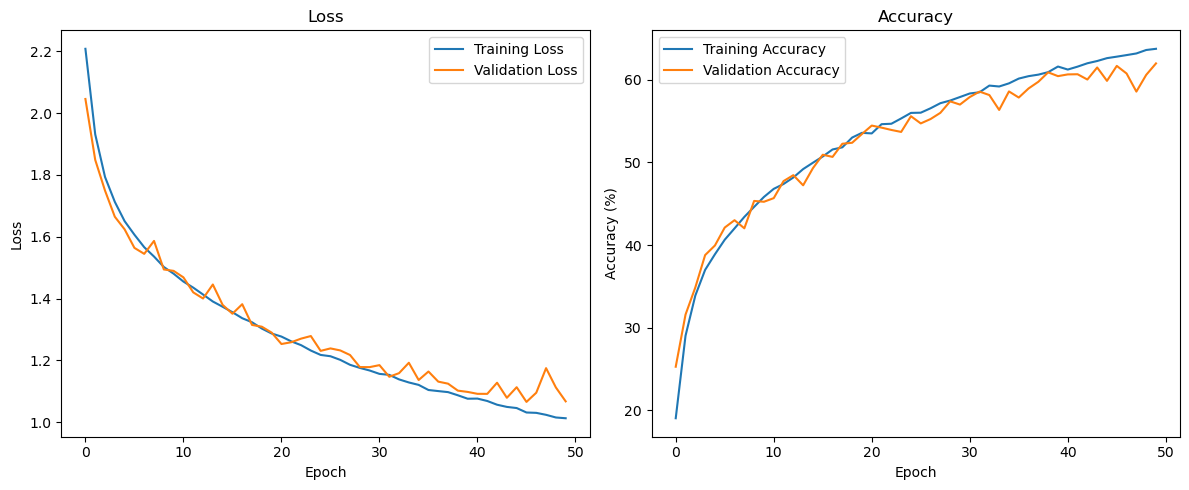

Test Accuracy: 63.87%
Evaluation complete!


In [ ]:
model = ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

train(model, train_loader, val_loader,criterion, optimizer, num_epochs=50,patience=5)
print("Training complete!")

plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

test(model, test_loader)
print("Evaluation complete!")

#### Adam optimiser

Epoch 1/50: 100%|██████████| 313/313 [00:08<00:00, 37.77it/s]


Epoch [1/50] - Train Loss: 1.6149, Train Accuracy: 41.04% | Val Loss: 1.4191, Val Accuracy: 48.17%


Epoch 2/50: 100%|██████████| 313/313 [00:08<00:00, 38.77it/s]


Epoch [2/50] - Train Loss: 1.3965, Train Accuracy: 49.65% | Val Loss: 1.3283, Val Accuracy: 52.65%


Epoch 3/50: 100%|██████████| 313/313 [00:07<00:00, 40.14it/s]


Epoch [3/50] - Train Loss: 1.2094, Train Accuracy: 56.62% | Val Loss: 1.1001, Val Accuracy: 60.52%


Epoch 4/50: 100%|██████████| 313/313 [00:07<00:00, 40.25it/s]


Epoch [4/50] - Train Loss: 1.0938, Train Accuracy: 60.99% | Val Loss: 1.1297, Val Accuracy: 58.70%


Epoch 5/50: 100%|██████████| 313/313 [00:07<00:00, 41.37it/s]


Epoch [5/50] - Train Loss: 1.0237, Train Accuracy: 63.82% | Val Loss: 1.0103, Val Accuracy: 64.93%


Epoch 6/50: 100%|██████████| 313/313 [00:07<00:00, 40.51it/s]


Epoch [6/50] - Train Loss: 0.9534, Train Accuracy: 66.33% | Val Loss: 1.0290, Val Accuracy: 63.72%


Epoch 7/50: 100%|██████████| 313/313 [00:07<00:00, 39.45it/s]


Epoch [7/50] - Train Loss: 0.9065, Train Accuracy: 68.00% | Val Loss: 0.9139, Val Accuracy: 67.48%


Epoch 8/50: 100%|██████████| 313/313 [00:07<00:00, 41.13it/s]


Epoch [8/50] - Train Loss: 0.8623, Train Accuracy: 69.45% | Val Loss: 0.8843, Val Accuracy: 69.19%


Epoch 9/50: 100%|██████████| 313/313 [00:07<00:00, 40.96it/s]


Epoch [9/50] - Train Loss: 0.8283, Train Accuracy: 71.06% | Val Loss: 0.8833, Val Accuracy: 69.73%


Epoch 10/50: 100%|██████████| 313/313 [00:07<00:00, 41.05it/s]


Epoch [10/50] - Train Loss: 0.7802, Train Accuracy: 72.73% | Val Loss: 0.8410, Val Accuracy: 70.99%


Epoch 11/50: 100%|██████████| 313/313 [00:07<00:00, 42.05it/s]


Epoch [11/50] - Train Loss: 0.7612, Train Accuracy: 73.54% | Val Loss: 0.7940, Val Accuracy: 72.79%


Epoch 12/50: 100%|██████████| 313/313 [00:07<00:00, 42.47it/s]


Epoch [12/50] - Train Loss: 0.7289, Train Accuracy: 74.58% | Val Loss: 0.7893, Val Accuracy: 72.72%


Epoch 13/50: 100%|██████████| 313/313 [00:07<00:00, 41.12it/s]


Epoch [13/50] - Train Loss: 0.7072, Train Accuracy: 75.35% | Val Loss: 0.8161, Val Accuracy: 72.65%


Epoch 14/50: 100%|██████████| 313/313 [00:07<00:00, 41.31it/s]


Epoch [14/50] - Train Loss: 0.6848, Train Accuracy: 76.28% | Val Loss: 0.7541, Val Accuracy: 74.01%


Epoch 15/50: 100%|██████████| 313/313 [00:07<00:00, 42.34it/s]


Epoch [15/50] - Train Loss: 0.6637, Train Accuracy: 77.05% | Val Loss: 0.7385, Val Accuracy: 74.60%


Epoch 16/50: 100%|██████████| 313/313 [00:07<00:00, 42.19it/s]


Epoch [16/50] - Train Loss: 0.6408, Train Accuracy: 77.79% | Val Loss: 0.7615, Val Accuracy: 74.28%


Epoch 17/50: 100%|██████████| 313/313 [00:07<00:00, 42.29it/s]


Epoch [17/50] - Train Loss: 0.6185, Train Accuracy: 78.58% | Val Loss: 0.7196, Val Accuracy: 75.59%


Epoch 18/50: 100%|██████████| 313/313 [00:07<00:00, 42.16it/s]


Epoch [18/50] - Train Loss: 0.6066, Train Accuracy: 78.99% | Val Loss: 0.6972, Val Accuracy: 76.70%


Epoch 19/50: 100%|██████████| 313/313 [00:07<00:00, 42.08it/s]


Epoch [19/50] - Train Loss: 0.5952, Train Accuracy: 79.21% | Val Loss: 0.7236, Val Accuracy: 76.21%


Epoch 20/50: 100%|██████████| 313/313 [00:07<00:00, 42.41it/s]


Epoch [20/50] - Train Loss: 0.5741, Train Accuracy: 80.00% | Val Loss: 0.7042, Val Accuracy: 76.61%


Epoch 21/50: 100%|██████████| 313/313 [00:07<00:00, 41.70it/s]


Epoch [21/50] - Train Loss: 0.5635, Train Accuracy: 80.43% | Val Loss: 0.7280, Val Accuracy: 76.00%


Epoch 22/50: 100%|██████████| 313/313 [00:07<00:00, 42.05it/s]


Epoch [22/50] - Train Loss: 0.5534, Train Accuracy: 80.65% | Val Loss: 0.6754, Val Accuracy: 77.27%


Epoch 23/50: 100%|██████████| 313/313 [00:07<00:00, 41.94it/s]


Epoch [23/50] - Train Loss: 0.5378, Train Accuracy: 81.20% | Val Loss: 0.6704, Val Accuracy: 77.52%


Epoch 24/50: 100%|██████████| 313/313 [00:07<00:00, 42.53it/s]


Epoch [24/50] - Train Loss: 0.5215, Train Accuracy: 81.84% | Val Loss: 0.6899, Val Accuracy: 77.25%


Epoch 25/50: 100%|██████████| 313/313 [00:07<00:00, 42.31it/s]


Epoch [25/50] - Train Loss: 0.5111, Train Accuracy: 82.17% | Val Loss: 0.6921, Val Accuracy: 76.87%


Epoch 26/50: 100%|██████████| 313/313 [00:07<00:00, 41.67it/s]


Epoch [26/50] - Train Loss: 0.5047, Train Accuracy: 82.45% | Val Loss: 0.6874, Val Accuracy: 77.59%


Epoch 27/50: 100%|██████████| 313/313 [00:07<00:00, 42.54it/s]


Epoch [27/50] - Train Loss: 0.4906, Train Accuracy: 82.94% | Val Loss: 0.7012, Val Accuracy: 76.68%


Epoch 28/50: 100%|██████████| 313/313 [00:07<00:00, 40.27it/s]


Epoch [28/50] - Train Loss: 0.4844, Train Accuracy: 83.22% | Val Loss: 0.6832, Val Accuracy: 77.65%
Early stopping triggered after 28 epochs without improvement.
Training complete!


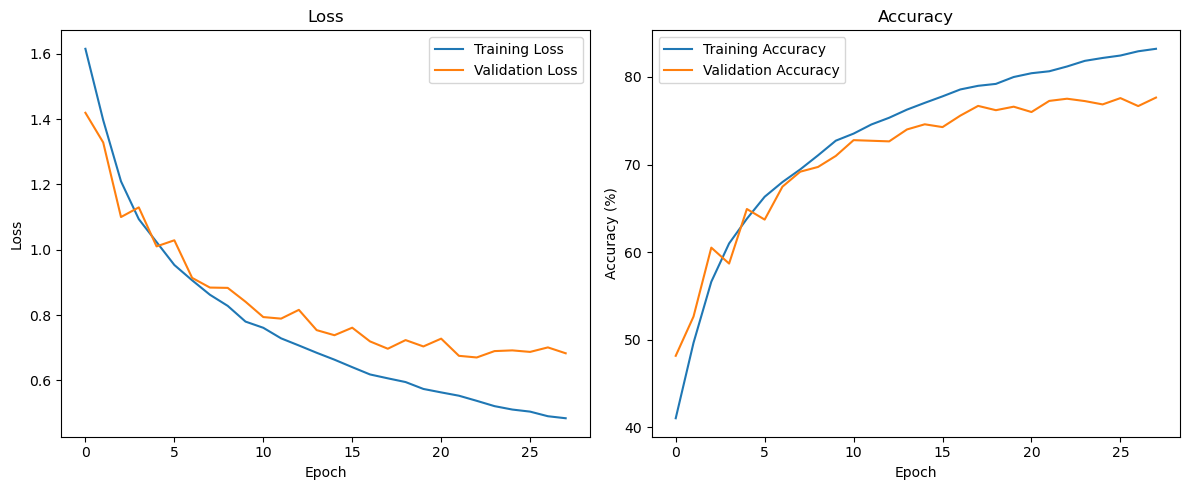

Test Accuracy: 79.05%
Evaluation complete!


In [ ]:
model = ResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

train(model, train_loader, val_loader,criterion, optimizer, num_epochs=50,patience=5)
print("Training complete!")

plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
 # Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

test(model, test_loader)
print("Evaluation complete!")

#### with added DROUPOUT

Epoch 1/50: 100%|██████████| 313/313 [00:07<00:00, 40.13it/s]


Epoch [1/50] - Train Loss: 4.4576, Train Accuracy: 10.75% | Val Loss: 2.3040, Val Accuracy: 11.54%


Epoch 2/50: 100%|██████████| 313/313 [00:07<00:00, 43.21it/s]


Epoch [2/50] - Train Loss: 2.1755, Train Accuracy: 16.07% | Val Loss: 2.0122, Val Accuracy: 21.30%


Epoch 3/50: 100%|██████████| 313/313 [00:07<00:00, 43.67it/s]


Epoch [3/50] - Train Loss: 1.9538, Train Accuracy: 21.30% | Val Loss: 1.9247, Val Accuracy: 23.04%


Epoch 4/50: 100%|██████████| 313/313 [00:07<00:00, 43.35it/s]


Epoch [4/50] - Train Loss: 1.8975, Train Accuracy: 24.08% | Val Loss: 1.8639, Val Accuracy: 25.69%


Epoch 5/50: 100%|██████████| 313/313 [00:07<00:00, 42.52it/s]


Epoch [5/50] - Train Loss: 1.8252, Train Accuracy: 28.80% | Val Loss: 1.7805, Val Accuracy: 31.38%


Epoch 6/50: 100%|██████████| 313/313 [00:07<00:00, 42.94it/s]


Epoch [6/50] - Train Loss: 1.7363, Train Accuracy: 33.03% | Val Loss: 1.7409, Val Accuracy: 33.96%


Epoch 7/50: 100%|██████████| 313/313 [00:07<00:00, 42.94it/s]


Epoch [7/50] - Train Loss: 1.6616, Train Accuracy: 36.17% | Val Loss: 1.6087, Val Accuracy: 39.63%


Epoch 8/50: 100%|██████████| 313/313 [00:07<00:00, 43.27it/s]


Epoch [8/50] - Train Loss: 1.5857, Train Accuracy: 39.12% | Val Loss: 1.5901, Val Accuracy: 40.32%


Epoch 9/50: 100%|██████████| 313/313 [00:07<00:00, 42.66it/s]


Epoch [9/50] - Train Loss: 1.4961, Train Accuracy: 42.59% | Val Loss: 1.4450, Val Accuracy: 45.15%


Epoch 10/50: 100%|██████████| 313/313 [00:07<00:00, 40.11it/s]


Epoch [10/50] - Train Loss: 1.4083, Train Accuracy: 46.61% | Val Loss: 1.4204, Val Accuracy: 47.87%


Epoch 11/50: 100%|██████████| 313/313 [00:07<00:00, 41.28it/s]


Epoch [11/50] - Train Loss: 1.3294, Train Accuracy: 50.09% | Val Loss: 1.3392, Val Accuracy: 49.57%


Epoch 12/50: 100%|██████████| 313/313 [00:07<00:00, 41.17it/s]


Epoch [12/50] - Train Loss: 1.2535, Train Accuracy: 53.42% | Val Loss: 1.2060, Val Accuracy: 56.49%


Epoch 13/50: 100%|██████████| 313/313 [00:07<00:00, 41.97it/s]


Epoch [13/50] - Train Loss: 1.1828, Train Accuracy: 56.84% | Val Loss: 1.1886, Val Accuracy: 57.31%


Epoch 14/50: 100%|██████████| 313/313 [00:07<00:00, 41.71it/s]


Epoch [14/50] - Train Loss: 1.1244, Train Accuracy: 59.04% | Val Loss: 1.1045, Val Accuracy: 60.51%


Epoch 15/50: 100%|██████████| 313/313 [00:07<00:00, 41.57it/s]


Epoch [15/50] - Train Loss: 1.0802, Train Accuracy: 60.98% | Val Loss: 1.1222, Val Accuracy: 59.72%


Epoch 16/50: 100%|██████████| 313/313 [00:07<00:00, 41.54it/s]


Epoch [16/50] - Train Loss: 1.0425, Train Accuracy: 62.52% | Val Loss: 1.0691, Val Accuracy: 62.08%


Epoch 17/50: 100%|██████████| 313/313 [00:07<00:00, 43.40it/s]


Epoch [17/50] - Train Loss: 1.0030, Train Accuracy: 64.03% | Val Loss: 0.9995, Val Accuracy: 64.99%


Epoch 18/50: 100%|██████████| 313/313 [00:07<00:00, 41.96it/s]


Epoch [18/50] - Train Loss: 0.9674, Train Accuracy: 65.70% | Val Loss: 1.0119, Val Accuracy: 64.45%


Epoch 19/50: 100%|██████████| 313/313 [00:07<00:00, 41.86it/s]


Epoch [19/50] - Train Loss: 0.9321, Train Accuracy: 67.19% | Val Loss: 0.9948, Val Accuracy: 65.29%


Epoch 20/50: 100%|██████████| 313/313 [00:07<00:00, 41.80it/s]


Epoch [20/50] - Train Loss: 0.9043, Train Accuracy: 67.91% | Val Loss: 0.9396, Val Accuracy: 67.26%


Epoch 21/50: 100%|██████████| 313/313 [00:07<00:00, 42.46it/s]


Epoch [21/50] - Train Loss: 0.8703, Train Accuracy: 69.31% | Val Loss: 0.9350, Val Accuracy: 68.03%


Epoch 22/50: 100%|██████████| 313/313 [00:07<00:00, 42.48it/s]


Epoch [22/50] - Train Loss: 0.8438, Train Accuracy: 70.31% | Val Loss: 0.9174, Val Accuracy: 67.70%


Epoch 23/50: 100%|██████████| 313/313 [00:07<00:00, 42.96it/s]


Epoch [23/50] - Train Loss: 0.8130, Train Accuracy: 71.59% | Val Loss: 0.9031, Val Accuracy: 68.70%


Epoch 24/50: 100%|██████████| 313/313 [00:07<00:00, 43.20it/s]


Epoch [24/50] - Train Loss: 0.7943, Train Accuracy: 72.29% | Val Loss: 0.8274, Val Accuracy: 71.18%


Epoch 25/50: 100%|██████████| 313/313 [00:07<00:00, 43.57it/s]


Epoch [25/50] - Train Loss: 0.7713, Train Accuracy: 73.31% | Val Loss: 0.8547, Val Accuracy: 70.81%


Epoch 26/50: 100%|██████████| 313/313 [00:07<00:00, 42.59it/s]


Epoch [26/50] - Train Loss: 0.7593, Train Accuracy: 73.62% | Val Loss: 0.8557, Val Accuracy: 71.15%


Epoch 27/50: 100%|██████████| 313/313 [00:07<00:00, 43.46it/s]


Epoch [27/50] - Train Loss: 0.7344, Train Accuracy: 74.16% | Val Loss: 0.8317, Val Accuracy: 71.66%


Epoch 28/50: 100%|██████████| 313/313 [00:07<00:00, 42.53it/s]


Epoch [28/50] - Train Loss: 0.7047, Train Accuracy: 75.56% | Val Loss: 0.7863, Val Accuracy: 73.29%


Epoch 29/50: 100%|██████████| 313/313 [00:07<00:00, 42.37it/s]


Epoch [29/50] - Train Loss: 0.6868, Train Accuracy: 76.10% | Val Loss: 0.7978, Val Accuracy: 73.08%


Epoch 30/50: 100%|██████████| 313/313 [00:07<00:00, 42.17it/s]


Epoch [30/50] - Train Loss: 0.6765, Train Accuracy: 76.51% | Val Loss: 0.7749, Val Accuracy: 73.51%


Epoch 31/50: 100%|██████████| 313/313 [00:07<00:00, 42.55it/s]


Epoch [31/50] - Train Loss: 0.6641, Train Accuracy: 77.00% | Val Loss: 0.7839, Val Accuracy: 73.89%


Epoch 32/50: 100%|██████████| 313/313 [00:07<00:00, 42.69it/s]


Epoch [32/50] - Train Loss: 0.6459, Train Accuracy: 77.61% | Val Loss: 0.8180, Val Accuracy: 72.71%


Epoch 33/50: 100%|██████████| 313/313 [00:07<00:00, 42.42it/s]


Epoch [33/50] - Train Loss: 0.6306, Train Accuracy: 78.22% | Val Loss: 0.7488, Val Accuracy: 74.69%


Epoch 34/50: 100%|██████████| 313/313 [00:07<00:00, 42.95it/s]


Epoch [34/50] - Train Loss: 0.6155, Train Accuracy: 78.67% | Val Loss: 0.7355, Val Accuracy: 74.39%


Epoch 35/50: 100%|██████████| 313/313 [00:07<00:00, 42.55it/s]


Epoch [35/50] - Train Loss: 0.6004, Train Accuracy: 78.94% | Val Loss: 0.7317, Val Accuracy: 75.21%


Epoch 36/50: 100%|██████████| 313/313 [00:07<00:00, 40.48it/s]


Epoch [36/50] - Train Loss: 0.5926, Train Accuracy: 79.20% | Val Loss: 0.7085, Val Accuracy: 76.13%


Epoch 37/50: 100%|██████████| 313/313 [00:07<00:00, 43.03it/s]


Epoch [37/50] - Train Loss: 0.5813, Train Accuracy: 79.77% | Val Loss: 0.7225, Val Accuracy: 75.19%


Epoch 38/50: 100%|██████████| 313/313 [00:07<00:00, 43.39it/s]


Epoch [38/50] - Train Loss: 0.5620, Train Accuracy: 80.38% | Val Loss: 0.7478, Val Accuracy: 75.87%


Epoch 39/50: 100%|██████████| 313/313 [00:07<00:00, 41.92it/s]


Epoch [39/50] - Train Loss: 0.5605, Train Accuracy: 80.43% | Val Loss: 0.7275, Val Accuracy: 75.93%


Epoch 40/50: 100%|██████████| 313/313 [00:07<00:00, 41.92it/s]


Epoch [40/50] - Train Loss: 0.5441, Train Accuracy: 81.11% | Val Loss: 0.7362, Val Accuracy: 75.55%


Epoch 41/50: 100%|██████████| 313/313 [00:07<00:00, 41.33it/s]


Epoch [41/50] - Train Loss: 0.5325, Train Accuracy: 81.45% | Val Loss: 0.6964, Val Accuracy: 76.90%


Epoch 42/50: 100%|██████████| 313/313 [00:07<00:00, 42.43it/s]


Epoch [42/50] - Train Loss: 0.5227, Train Accuracy: 81.87% | Val Loss: 0.6841, Val Accuracy: 76.92%


Epoch 43/50: 100%|██████████| 313/313 [00:07<00:00, 40.81it/s]


Epoch [43/50] - Train Loss: 0.5240, Train Accuracy: 81.92% | Val Loss: 0.7187, Val Accuracy: 76.54%


Epoch 44/50: 100%|██████████| 313/313 [00:07<00:00, 42.56it/s]


Epoch [44/50] - Train Loss: 0.5112, Train Accuracy: 82.19% | Val Loss: 0.7011, Val Accuracy: 77.53%


Epoch 45/50: 100%|██████████| 313/313 [00:07<00:00, 42.86it/s]


Epoch [45/50] - Train Loss: 0.4964, Train Accuracy: 82.74% | Val Loss: 0.6740, Val Accuracy: 77.55%


Epoch 46/50: 100%|██████████| 313/313 [00:07<00:00, 42.44it/s]


Epoch [46/50] - Train Loss: 0.4916, Train Accuracy: 82.73% | Val Loss: 0.6890, Val Accuracy: 76.90%


Epoch 47/50: 100%|██████████| 313/313 [00:07<00:00, 42.61it/s]


Epoch [47/50] - Train Loss: 0.4930, Train Accuracy: 82.80% | Val Loss: 0.6886, Val Accuracy: 77.27%


Epoch 48/50: 100%|██████████| 313/313 [00:07<00:00, 42.09it/s]


Epoch [48/50] - Train Loss: 0.4808, Train Accuracy: 83.42% | Val Loss: 0.6559, Val Accuracy: 78.47%


Epoch 49/50: 100%|██████████| 313/313 [00:07<00:00, 42.36it/s]


Epoch [49/50] - Train Loss: 0.4692, Train Accuracy: 83.48% | Val Loss: 0.7434, Val Accuracy: 76.38%


Epoch 50/50: 100%|██████████| 313/313 [00:07<00:00, 43.08it/s]


Epoch [50/50] - Train Loss: 0.4657, Train Accuracy: 83.91% | Val Loss: 0.6695, Val Accuracy: 78.41%
Training complete!


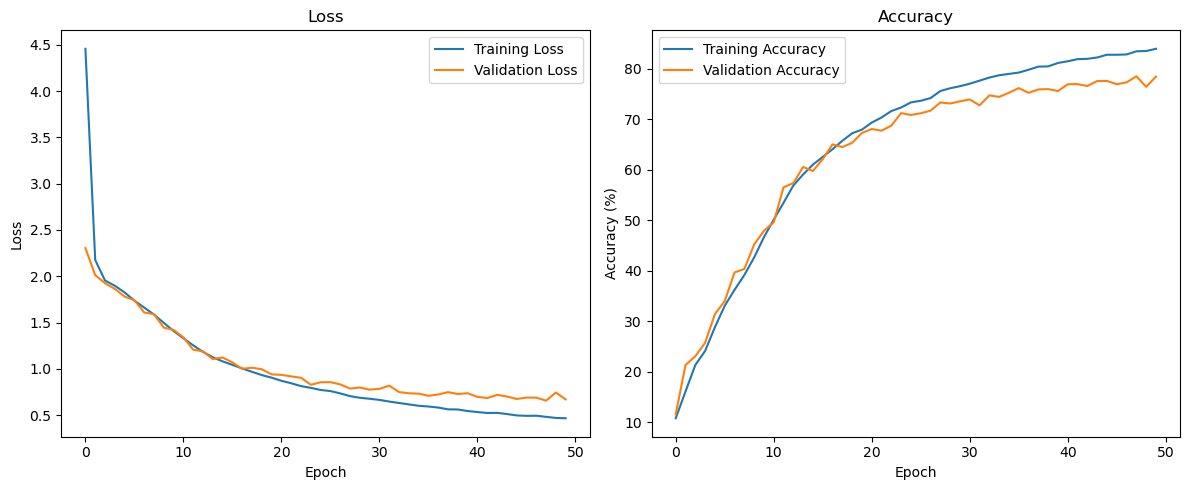

Test Accuracy: 79.22%
Evaluation complete!


In [ ]:
class CustomResNet18(nn.Module):
    def __init__(self, dropout_rate=0.9):
        super(CustomResNet18, self).__init__()
        self.model = resnet18(weights=None)
        self.model.layer1 = nn.Sequential(
            self.model.layer1,
            nn.Dropout(dropout_rate)
        )
        self.model.layer2 = nn.Sequential(
            self.model.layer2,
            nn.Dropout(dropout_rate)
        )
        self.model.layer3 = nn.Sequential(
            self.model.layer3,
            nn.Dropout(dropout_rate)
        )
        self.model.layer4 = nn.Sequential(
            self.model.layer4,
            nn.Dropout(dropout_rate)
        )
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, 10)
        )

    def forward(self, x):
        return self.model(x)
model = CustomResNet18().to(device)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

train(model, train_loader, val_loader,criterion, optimizer, num_epochs=50,patience=5)
print("Training complete!")

plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
 # Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

test(model, test_loader)
print("Evaluation complete!")

#### Removing residual connection

Epoch 1/50: 100%|██████████| 313/313 [00:07<00:00, 41.17it/s]


Epoch [1/50] - Train Loss: 2.4861, Train Accuracy: 11.55% | Val Loss: 2.3117, Val Accuracy: 10.01%


Epoch 2/50: 100%|██████████| 313/313 [00:07<00:00, 43.94it/s]


Epoch [2/50] - Train Loss: 2.0502, Train Accuracy: 18.38% | Val Loss: 1.9214, Val Accuracy: 20.73%


Epoch 3/50: 100%|██████████| 313/313 [00:07<00:00, 44.09it/s]


Epoch [3/50] - Train Loss: 1.9219, Train Accuracy: 21.61% | Val Loss: 1.9172, Val Accuracy: 23.88%


Epoch 4/50: 100%|██████████| 313/313 [00:07<00:00, 43.95it/s]


Epoch [4/50] - Train Loss: 1.9014, Train Accuracy: 22.76% | Val Loss: 1.8610, Val Accuracy: 24.59%


Epoch 5/50: 100%|██████████| 313/313 [00:07<00:00, 43.25it/s]


Epoch [5/50] - Train Loss: 1.8473, Train Accuracy: 25.92% | Val Loss: 1.8153, Val Accuracy: 27.95%


Epoch 6/50: 100%|██████████| 313/313 [00:08<00:00, 39.09it/s]


Epoch [6/50] - Train Loss: 1.8183, Train Accuracy: 27.82% | Val Loss: 1.8245, Val Accuracy: 25.76%


Epoch 7/50: 100%|██████████| 313/313 [00:08<00:00, 36.03it/s]


Epoch [7/50] - Train Loss: 1.7803, Train Accuracy: 30.55% | Val Loss: 1.7271, Val Accuracy: 33.48%


Epoch 8/50: 100%|██████████| 313/313 [00:08<00:00, 36.59it/s]


Epoch [8/50] - Train Loss: 1.7095, Train Accuracy: 34.21% | Val Loss: 1.6452, Val Accuracy: 37.21%


Epoch 9/50: 100%|██████████| 313/313 [00:09<00:00, 34.36it/s]


Epoch [9/50] - Train Loss: 1.6273, Train Accuracy: 37.49% | Val Loss: 1.5595, Val Accuracy: 39.45%


Epoch 10/50: 100%|██████████| 313/313 [00:08<00:00, 37.81it/s]


Epoch [10/50] - Train Loss: 1.5740, Train Accuracy: 39.49% | Val Loss: 1.5088, Val Accuracy: 42.80%


Epoch 11/50: 100%|██████████| 313/313 [00:07<00:00, 39.53it/s]


Epoch [11/50] - Train Loss: 1.5301, Train Accuracy: 41.54% | Val Loss: 1.4501, Val Accuracy: 45.35%


Epoch 12/50: 100%|██████████| 313/313 [00:07<00:00, 42.71it/s]


Epoch [12/50] - Train Loss: 1.4951, Train Accuracy: 43.13% | Val Loss: 1.5700, Val Accuracy: 41.48%


Epoch 13/50: 100%|██████████| 313/313 [00:07<00:00, 42.49it/s]


Epoch [13/50] - Train Loss: 1.4645, Train Accuracy: 43.82% | Val Loss: 1.4648, Val Accuracy: 45.03%


Epoch 14/50: 100%|██████████| 313/313 [00:07<00:00, 43.94it/s]


Epoch [14/50] - Train Loss: 1.3919, Train Accuracy: 46.76% | Val Loss: 1.4479, Val Accuracy: 44.59%


Epoch 15/50: 100%|██████████| 313/313 [00:07<00:00, 43.74it/s]


Epoch [15/50] - Train Loss: 1.4077, Train Accuracy: 46.90% | Val Loss: 1.3785, Val Accuracy: 49.39%


Epoch 16/50: 100%|██████████| 313/313 [00:08<00:00, 39.10it/s]


Epoch [16/50] - Train Loss: 1.3849, Train Accuracy: 47.76% | Val Loss: 1.4352, Val Accuracy: 47.23%


Epoch 17/50: 100%|██████████| 313/313 [00:07<00:00, 39.75it/s]


Epoch [17/50] - Train Loss: 1.3417, Train Accuracy: 49.65% | Val Loss: 1.2762, Val Accuracy: 52.36%


Epoch 18/50: 100%|██████████| 313/313 [00:07<00:00, 39.74it/s]


Epoch [18/50] - Train Loss: 1.3305, Train Accuracy: 50.82% | Val Loss: 1.3332, Val Accuracy: 52.23%


Epoch 19/50: 100%|██████████| 313/313 [00:08<00:00, 37.86it/s]


Epoch [19/50] - Train Loss: 1.3427, Train Accuracy: 51.58% | Val Loss: 1.3583, Val Accuracy: 51.33%


Epoch 20/50: 100%|██████████| 313/313 [00:07<00:00, 43.53it/s]


Epoch [20/50] - Train Loss: 1.3600, Train Accuracy: 50.83% | Val Loss: 1.3315, Val Accuracy: 51.25%


Epoch 21/50: 100%|██████████| 313/313 [00:07<00:00, 43.79it/s]


Epoch [21/50] - Train Loss: 1.3117, Train Accuracy: 53.31% | Val Loss: 1.8466, Val Accuracy: 38.62%


Epoch 22/50: 100%|██████████| 313/313 [00:07<00:00, 43.46it/s]


Epoch [22/50] - Train Loss: 1.5046, Train Accuracy: 44.12% | Val Loss: 1.2820, Val Accuracy: 54.55%
Early stopping triggered after 22 epochs without improvement.
Training complete!


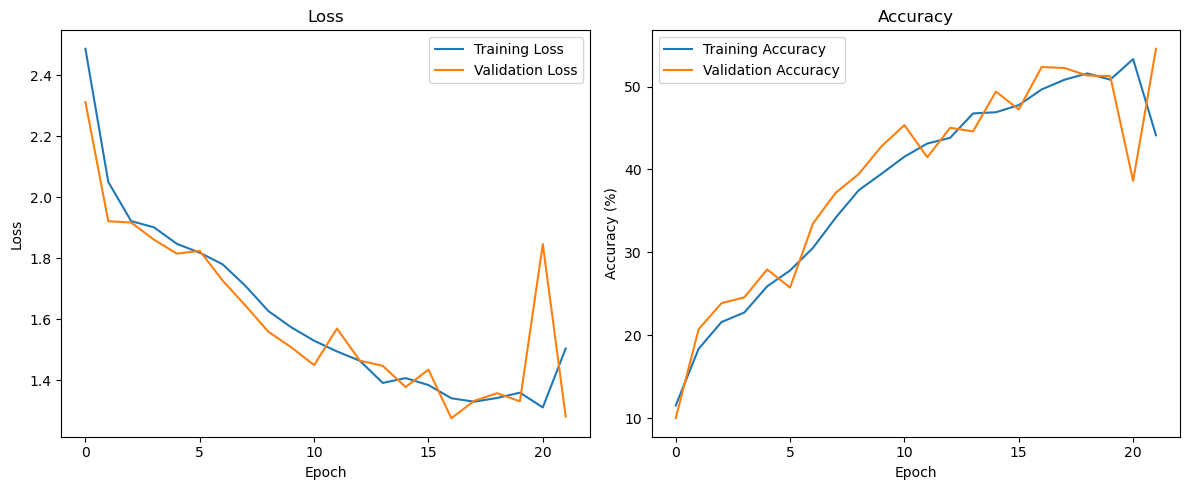

Test Accuracy: 55.65%
Evaluation complete!


In [ ]:
class BasicBlockNoSkip(nn.Module):
    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.9):
        super(BasicBlockNoSkip, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = self.relu(out)
        return out

# Custom ResNet-18 without skip connections
class CustomResNet18(nn.Module):
    def __init__(self, dropout_rate=0.9):
        super(CustomResNet18, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(BasicBlockNoSkip, 64, 2, stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(BasicBlockNoSkip, 128, 2, stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(BasicBlockNoSkip, 256, 2, stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(BasicBlockNoSkip, 512, 2, stride=2, dropout_rate=dropout_rate)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 10)

    def _make_layer(self, block, planes, blocks, stride, dropout_rate):
        layers = []
        layers.append(block(self.in_planes, planes, stride, dropout_rate))
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(block(planes, planes, dropout_rate=dropout_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = CustomResNet18().to(device)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

train(model, train_loader, val_loader,criterion, optimizer, num_epochs=50,patience=5)
print("Training complete!")

plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

test(model, test_loader)
print("Evaluation complete!")

Hyperparameter tuning

In [ ]:
best_model_path = "best_model_resnet_18.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seeds
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.01, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.5, 0.9, log=True)
    class CustomResNet18(nn.Module):
        def __init__(self, dropout_rate=dropout_rate):
            super(CustomResNet18, self).__init__()
            self.model = resnet18(weights=None)
            self.model.layer1 = nn.Sequential(
                self.model.layer1,
                nn.Dropout(dropout_rate)
            )
            self.model.layer2 = nn.Sequential(
                self.model.layer2,
                nn.Dropout(dropout_rate)
            )
            self.model.layer3 = nn.Sequential(
                self.model.layer3,
                nn.Dropout(dropout_rate)
            )
            self.model.layer4 = nn.Sequential(
                self.model.layer4,
                nn.Dropout(dropout_rate)
            )
            self.model.fc = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(self.model.fc.in_features, 10)
            )

        def forward(self, x):
            return self.model(x)
    model = CustomResNet18().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scaler = GradScaler('cuda')

    # Early stopping and model saving parameters
    num_epochs = 30
    best_val_loss = float('inf')
    patience = 5
    trials_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast(device_type="cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                with autocast(device_type="cuda"):
                    outputs = model(images)
                    val_loss += criterion(outputs, labels).item()
        val_loss /= len(val_loader)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trials_without_improvement = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'best_val_loss': best_val_loss,
                'learning_rate': learning_rate,
                'weight_decay': weight_decay,
                'dropout_rate': dropout_rate
            }, best_model_path)
            
            print(f"New best model saved with validation loss: {val_loss}")
        else:
            trials_without_improvement += 1
        if trials_without_improvement >= patience:
            print(f"Early stopping on trial {trial.number} after {epoch + 1} epochs.")
            break

    return best_val_loss
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=150)

print("Best parameters:", study.best_params)
print("Best validation loss:", study.best_value)
print(f"Best model saved at {best_model_path}")


[I 2024-11-03 19:27:26,728] A new study created in memory with name: no-name-a4b68da1-1793-455c-823e-658aea59d5c2


New best model saved with validation loss: 1.9672626905803439
New best model saved with validation loss: 1.7526386598997479
New best model saved with validation loss: 1.5811180826983875
New best model saved with validation loss: 1.5594314034981063
New best model saved with validation loss: 1.3738182360612894
New best model saved with validation loss: 1.2949950498870657
New best model saved with validation loss: 1.2691666868668567
New best model saved with validation loss: 1.1543301849425593
New best model saved with validation loss: 1.1411884683596938
New best model saved with validation loss: 1.0583710730830325
New best model saved with validation loss: 1.0482104420661926
New best model saved with validation loss: 1.0197636839709705
New best model saved with validation loss: 0.9765523076057434
New best model saved with validation loss: 0.9656050265589847
New best model saved with validation loss: 0.9441580425334882
New best model saved with validation loss: 0.9294940195506132
New best

[I 2024-11-03 19:31:13,407] Trial 0 finished with value: 0.7531761368618736 and parameters: {'learning_rate': 0.0020261007481035993, 'weight_decay': 4.8757775876790815e-05, 'dropout_rate': 0.6498445648525888}. Best is trial 0 with value: 0.7531761368618736.


New best model saved with validation loss: 2.977894091907936
New best model saved with validation loss: 2.1736431001107905
New best model saved with validation loss: 2.1704948974561087
New best model saved with validation loss: 1.983676358114315
New best model saved with validation loss: 1.8829601625852947
New best model saved with validation loss: 1.8480287382874308
New best model saved with validation loss: 1.8381678424304044
New best model saved with validation loss: 1.7547973439663271
New best model saved with validation loss: 1.6565023253235636
New best model saved with validation loss: 1.6524182090276405
New best model saved with validation loss: 1.592965620982496
New best model saved with validation loss: 1.560328798958018
New best model saved with validation loss: 1.5042292407796354
New best model saved with validation loss: 1.4897610326356525
New best model saved with validation loss: 1.4523767730857753
New best model saved with validation loss: 1.4253234742562981
New best mod

[I 2024-11-03 19:34:53,306] Trial 1 finished with value: 1.2259944239749183 and parameters: {'learning_rate': 0.007434057487028445, 'weight_decay': 2.5521206481196384e-06, 'dropout_rate': 0.6233940224092512}. Best is trial 0 with value: 0.7531761368618736.


New best model saved with validation loss: 2.2466042554831205
New best model saved with validation loss: 2.1506579556042635
New best model saved with validation loss: 1.944680643987052
New best model saved with validation loss: 1.8423776988741718
New best model saved with validation loss: 1.7425433774537678
New best model saved with validation loss: 1.733717061296294
New best model saved with validation loss: 1.616393809077106
New best model saved with validation loss: 1.6086931862408602
New best model saved with validation loss: 1.5363031821914865
New best model saved with validation loss: 1.4331008754199064
New best model saved with validation loss: 1.4292708650419983
New best model saved with validation loss: 1.3542391439027424
New best model saved with validation loss: 1.3218584090848513
New best model saved with validation loss: 1.2686743117585968


[I 2024-11-03 19:37:55,659] Trial 2 finished with value: 1.2686743117585968 and parameters: {'learning_rate': 0.009512653655461376, 'weight_decay': 0.00011138659435250769, 'dropout_rate': 0.6038367728053065}. Best is trial 0 with value: 0.7531761368618736.


Early stopping on trial 2 after 25 epochs.
New best model saved with validation loss: 2.295501292506351
New best model saved with validation loss: 2.120433161530314
New best model saved with validation loss: 2.019342096546028
New best model saved with validation loss: 1.9577277944057803
New best model saved with validation loss: 1.9038203909427305
New best model saved with validation loss: 1.8753651667244826
New best model saved with validation loss: 1.8238098772266242
New best model saved with validation loss: 1.7571259027794948
New best model saved with validation loss: 1.7330054512506798
New best model saved with validation loss: 1.6964917016934744
New best model saved with validation loss: 1.575267026696024
New best model saved with validation loss: 1.5233969280991373
New best model saved with validation loss: 1.4594275408153292
New best model saved with validation loss: 1.434132556372051
New best model saved with validation loss: 1.4322097905074493
New best model saved with valida

[I 2024-11-03 19:41:35,763] Trial 3 finished with value: 1.2374189413046535 and parameters: {'learning_rate': 0.002324712885568043, 'weight_decay': 0.0004102611771123135, 'dropout_rate': 0.8104230250721528}. Best is trial 0 with value: 0.7531761368618736.


New best model saved with validation loss: 1.2374189413046535
New best model saved with validation loss: 2.5091998939272724
New best model saved with validation loss: 2.2081960424592224
New best model saved with validation loss: 2.1273644845696946
New best model saved with validation loss: 1.9864637399021583
New best model saved with validation loss: 1.9751164777369439
New best model saved with validation loss: 1.895682008960579
New best model saved with validation loss: 1.8319673176053204
New best model saved with validation loss: 1.7969871955581858
New best model saved with validation loss: 1.7187186841723285
New best model saved with validation loss: 1.5622796695443648
New best model saved with validation loss: 1.5603465158728105
New best model saved with validation loss: 1.5046201159682455
New best model saved with validation loss: 1.407776133923591
New best model saved with validation loss: 1.406654495227186
New best model saved with validation loss: 1.4047225532652456
New best mo

[I 2024-11-03 19:45:18,119] Trial 4 finished with value: 1.1938531474222112 and parameters: {'learning_rate': 0.0016441706998361282, 'weight_decay': 2.92241520294575e-06, 'dropout_rate': 0.79629204047233}. Best is trial 0 with value: 0.7531761368618736.


New best model saved with validation loss: 1.1938531474222112
New best model saved with validation loss: 2.228546550002279
New best model saved with validation loss: 2.0450397956220407
New best model saved with validation loss: 1.724071381967279
New best model saved with validation loss: 1.5031255302549917
New best model saved with validation loss: 1.3267616938941087
New best model saved with validation loss: 1.2446651202213914
New best model saved with validation loss: 1.128960279724266
New best model saved with validation loss: 1.0530430221859413
New best model saved with validation loss: 1.0362427687343163
New best model saved with validation loss: 0.9526837181441391
New best model saved with validation loss: 0.9397539254985278
New best model saved with validation loss: 0.9047939777374268
New best model saved with validation loss: 0.8608557619626009
New best model saved with validation loss: 0.8264218063294133
New best model saved with validation loss: 0.807848957520497
New best mod

[I 2024-11-03 19:48:56,256] Trial 5 finished with value: 0.7201332766798478 and parameters: {'learning_rate': 0.0013414462710520667, 'weight_decay': 9.23728235903679e-05, 'dropout_rate': 0.6187160072635132}. Best is trial 5 with value: 0.7201332766798478.


New best model saved with validation loss: 2.0588271044477633
New best model saved with validation loss: 1.8783197538762153
New best model saved with validation loss: 1.6638865108731427
New best model saved with validation loss: 1.6154128403603276
New best model saved with validation loss: 1.3972838407830348
New best model saved with validation loss: 1.3881453441668161
New best model saved with validation loss: 1.2845147999027107
New best model saved with validation loss: 1.1804772728606114
New best model saved with validation loss: 1.0823808289781403
New best model saved with validation loss: 1.0737427367439754
New best model saved with validation loss: 1.059114032153842
New best model saved with validation loss: 1.0051334983185878
New best model saved with validation loss: 0.9836779380146461
New best model saved with validation loss: 0.9469400055800812
New best model saved with validation loss: 0.8814098095592064
New best model saved with validation loss: 0.8593343420873715
New best 

[I 2024-11-03 19:52:39,494] Trial 6 finished with value: 0.7320442290245732 and parameters: {'learning_rate': 0.0023220389720404262, 'weight_decay': 2.4809578896271057e-05, 'dropout_rate': 0.5840775541050086}. Best is trial 5 with value: 0.7201332766798478.


New best model saved with validation loss: 2.954844553259355
New best model saved with validation loss: 2.2187370182592656
New best model saved with validation loss: 1.8832533389707156
New best model saved with validation loss: 1.8762207996996143
New best model saved with validation loss: 1.7656295631505265
New best model saved with validation loss: 1.6778637306599677
New best model saved with validation loss: 1.6654100055936016
New best model saved with validation loss: 1.6214213673072526
New best model saved with validation loss: 1.5415858332114885
New best model saved with validation loss: 1.4221592190899426
New best model saved with validation loss: 1.3302709694150128
New best model saved with validation loss: 1.3064957328989535
New best model saved with validation loss: 1.2833393751820432
New best model saved with validation loss: 1.231229231327395
New best model saved with validation loss: 1.1741837640351886
New best model saved with validation loss: 1.1024965779690803
New best m

[I 2024-11-03 19:56:17,978] Trial 7 finished with value: 0.8562475261808951 and parameters: {'learning_rate': 0.009436749247743462, 'weight_decay': 5.428879366300753e-06, 'dropout_rate': 0.5618370903054365}. Best is trial 5 with value: 0.7201332766798478.


New best model saved with validation loss: 0.8562475261808951
New best model saved with validation loss: 2.3400655999968323
New best model saved with validation loss: 2.1623548857773405
New best model saved with validation loss: 2.012183599834201
New best model saved with validation loss: 1.9436386687846123
New best model saved with validation loss: 1.9079134011570411
New best model saved with validation loss: 1.891620696345462
New best model saved with validation loss: 1.8859614239463323
New best model saved with validation loss: 1.717443888700461
New best model saved with validation loss: 1.6341382702694665
New best model saved with validation loss: 1.5558876855463921
New best model saved with validation loss: 1.5337401583224912
New best model saved with validation loss: 1.4278532628771625
New best model saved with validation loss: 1.403438450414923
New best model saved with validation loss: 1.2844574692883068
New best model saved with validation loss: 1.264521693881554
New best mode

[I 2024-11-03 19:59:58,393] Trial 8 finished with value: 0.9391080533401875 and parameters: {'learning_rate': 0.002567342746605715, 'weight_decay': 7.414119089085858e-06, 'dropout_rate': 0.7327260573415402}. Best is trial 5 with value: 0.7201332766798478.


New best model saved with validation loss: 2.104505852807926
New best model saved with validation loss: 1.957749860196174
New best model saved with validation loss: 1.9121347861953928
New best model saved with validation loss: 1.6404547072664093
New best model saved with validation loss: 1.542947945715506
New best model saved with validation loss: 1.4118676004530508
New best model saved with validation loss: 1.3434745420383503
New best model saved with validation loss: 1.3064580552185638
New best model saved with validation loss: 1.2929802529419525
New best model saved with validation loss: 1.275484765632243
New best model saved with validation loss: 1.0859646367121347
New best model saved with validation loss: 1.0643301017676727
New best model saved with validation loss: 1.0197346678263024
New best model saved with validation loss: 0.9364130119734173
New best model saved with validation loss: 0.9216809883902345
New best model saved with validation loss: 0.8845656702790079
New best mod

[I 2024-11-03 20:03:39,771] Trial 9 finished with value: 0.7681794532492191 and parameters: {'learning_rate': 0.0013510818243955799, 'weight_decay': 0.0001694406044460711, 'dropout_rate': 0.6595485825214131}. Best is trial 5 with value: 0.7201332766798478.


New best model saved with validation loss: 1.9393295457091513
New best model saved with validation loss: 1.729546779318701
New best model saved with validation loss: 1.4715896271452118
New best model saved with validation loss: 1.3469123719613763
New best model saved with validation loss: 1.247376549093029
New best model saved with validation loss: 1.1390600415724743
New best model saved with validation loss: 1.033654912363125
New best model saved with validation loss: 0.9708164839804927
New best model saved with validation loss: 0.8767493450188939
New best model saved with validation loss: 0.8140440922749194
New best model saved with validation loss: 0.8027577981164183
New best model saved with validation loss: 0.7579446706590773
New best model saved with validation loss: 0.743275259114519
New best model saved with validation loss: 0.7238503034356274
New best model saved with validation loss: 0.7214068347894693


[I 2024-11-03 20:07:17,066] Trial 10 finished with value: 0.7015100257306159 and parameters: {'learning_rate': 0.0010288776791000246, 'weight_decay': 0.0009766616747920287, 'dropout_rate': 0.5028674019420208}. Best is trial 10 with value: 0.7015100257306159.


New best model saved with validation loss: 0.7015100257306159
New best model saved with validation loss: 1.755233499068248
New best model saved with validation loss: 1.7348599614976328
New best model saved with validation loss: 1.4577448262444026
New best model saved with validation loss: 1.2771462066264092
New best model saved with validation loss: 1.2522349599041516
New best model saved with validation loss: 1.2123211976848072
New best model saved with validation loss: 1.0845477505575252
New best model saved with validation loss: 1.0604635907124869
New best model saved with validation loss: 1.0426385530942603
New best model saved with validation loss: 1.0072407413132582
New best model saved with validation loss: 0.9246826458580887
New best model saved with validation loss: 0.9104542030563837
New best model saved with validation loss: 0.8501863321171531
New best model saved with validation loss: 0.8300748384451564
New best model saved with validation loss: 0.7585332257838189


[I 2024-11-03 20:10:15,355] Trial 11 finished with value: 0.7585332257838189 and parameters: {'learning_rate': 0.0010028503280920188, 'weight_decay': 0.0009209165489755493, 'dropout_rate': 0.504734867077593}. Best is trial 10 with value: 0.7015100257306159.


Early stopping on trial 11 after 24 epochs.
New best model saved with validation loss: 1.8832343439512615
New best model saved with validation loss: 1.7320768033401877
New best model saved with validation loss: 1.5255119604400442
New best model saved with validation loss: 1.3575556595114213
New best model saved with validation loss: 1.3460670317275614
New best model saved with validation loss: 1.342433802689178
New best model saved with validation loss: 1.1984032075616378
New best model saved with validation loss: 1.1153426298612281
New best model saved with validation loss: 1.073006141789352
New best model saved with validation loss: 1.0419245777250845
New best model saved with validation loss: 1.0283313137066514
New best model saved with validation loss: 0.9535417986821525


[I 2024-11-03 20:13:16,112] Trial 12 finished with value: 0.9535417986821525 and parameters: {'learning_rate': 0.003924740628219654, 'weight_decay': 0.0006689814122938519, 'dropout_rate': 0.5072047562868287}. Best is trial 10 with value: 0.7015100257306159.


Early stopping on trial 12 after 25 epochs.
New best model saved with validation loss: 2.0668738159952285
New best model saved with validation loss: 1.7672827636139303
New best model saved with validation loss: 1.4352962623668621
New best model saved with validation loss: 1.2419467734385141
New best model saved with validation loss: 1.151101926459542
New best model saved with validation loss: 1.100270095505292
New best model saved with validation loss: 1.0268526771400548
New best model saved with validation loss: 0.9592269168624395
New best model saved with validation loss: 0.9347587175007108
New best model saved with validation loss: 0.9091911783701256
New best model saved with validation loss: 0.877788579162163
New best model saved with validation loss: 0.8120334586010703
New best model saved with validation loss: 0.8012697772134708
New best model saved with validation loss: 0.7768873617618899
New best model saved with validation loss: 0.7318831968911087
New best model saved with val

[I 2024-11-03 20:16:58,593] Trial 13 finished with value: 0.7060474021525323 and parameters: {'learning_rate': 0.0011189628909039316, 'weight_decay': 0.0002104843179457338, 'dropout_rate': 0.5486970564503728}. Best is trial 10 with value: 0.7015100257306159.


Early stopping on trial 13 after 30 epochs.
New best model saved with validation loss: 2.0006752436674096
New best model saved with validation loss: 1.6633409608768512
New best model saved with validation loss: 1.5427034987679011
New best model saved with validation loss: 1.461003212989131
New best model saved with validation loss: 1.2296863236004794
New best model saved with validation loss: 1.1989653246312202
New best model saved with validation loss: 1.1901149779935427
New best model saved with validation loss: 1.084000968480412
New best model saved with validation loss: 1.0362948601758932
New best model saved with validation loss: 1.013259266750722
New best model saved with validation loss: 0.9663959296443795
New best model saved with validation loss: 0.9033431169352953
New best model saved with validation loss: 0.8873200567462777
New best model saved with validation loss: 0.883605039572414
New best model saved with validation loss: 0.8402402053905439
New best model saved with vali

[I 2024-11-03 20:20:38,191] Trial 14 finished with value: 0.7074594897559926 and parameters: {'learning_rate': 0.001022369712049879, 'weight_decay': 0.0002653582275313489, 'dropout_rate': 0.5365108451821656}. Best is trial 10 with value: 0.7015100257306159.


New best model saved with validation loss: 2.078800230086604
New best model saved with validation loss: 1.8262879939018926
New best model saved with validation loss: 1.6349311297452902
New best model saved with validation loss: 1.543396605721003
New best model saved with validation loss: 1.4034453358831285
New best model saved with validation loss: 1.3281231364117394
New best model saved with validation loss: 1.1988484912280795
New best model saved with validation loss: 1.117271999015084
New best model saved with validation loss: 1.1049479970449134
New best model saved with validation loss: 1.0595780437505697
New best model saved with validation loss: 0.9816257998913149
New best model saved with validation loss: 0.9776393031772179
New best model saved with validation loss: 0.9540625546551957
New best model saved with validation loss: 0.9476182513599154
New best model saved with validation loss: 0.9111026555677003


[I 2024-11-03 20:24:18,070] Trial 15 finished with value: 0.9111026555677003 and parameters: {'learning_rate': 0.003864170618544762, 'weight_decay': 0.0003105415345909859, 'dropout_rate': 0.5482482157714621}. Best is trial 10 with value: 0.7015100257306159.


New best model saved with validation loss: 2.3139016417008413
New best model saved with validation loss: 2.2518953945063336
New best model saved with validation loss: 2.1030920291248756
New best model saved with validation loss: 1.9806675050832048
New best model saved with validation loss: 1.9047957432420948
New best model saved with validation loss: 1.8910768801652933
New best model saved with validation loss: 1.8702057947086383
New best model saved with validation loss: 1.8500011661384679
New best model saved with validation loss: 1.8107815633846234
New best model saved with validation loss: 1.8078028506870512
New best model saved with validation loss: 1.785200206539299
New best model saved with validation loss: 1.779067440877987
New best model saved with validation loss: 1.726616183413735
New best model saved with validation loss: 1.6551530240457268
New best model saved with validation loss: 1.6097642183303833
New best model saved with validation loss: 1.5730910950069186
New best mo

[I 2024-11-03 20:27:59,702] Trial 16 finished with value: 1.4512049834939498 and parameters: {'learning_rate': 0.005413056306331439, 'weight_decay': 2.3480292475372384e-05, 'dropout_rate': 0.7114803306216075}. Best is trial 10 with value: 0.7015100257306159.


New best model saved with validation loss: 2.305345785768726
New best model saved with validation loss: 2.297275392315056


[I 2024-11-03 20:28:50,445] Trial 17 finished with value: 2.297275392315056 and parameters: {'learning_rate': 0.0014018667653368639, 'weight_decay': 1.0045319905944751e-06, 'dropout_rate': 0.8709886740071612}. Best is trial 10 with value: 0.7015100257306159.


Early stopping on trial 17 after 7 epochs.
New best model saved with validation loss: 2.062635856338694
New best model saved with validation loss: 1.7003382308573662
New best model saved with validation loss: 1.564903321145456
New best model saved with validation loss: 1.3612811927553974
New best model saved with validation loss: 1.2871321409563474
New best model saved with validation loss: 1.2229925378968445
New best model saved with validation loss: 1.1209867083573644
New best model saved with validation loss: 1.0636700889732265
New best model saved with validation loss: 0.9616454002223437
New best model saved with validation loss: 0.930759228483031
New best model saved with validation loss: 0.9141855345496649
New best model saved with validation loss: 0.8795961443381973
New best model saved with validation loss: 0.8372842790205267
New best model saved with validation loss: 0.7989212425449227


[I 2024-11-03 20:32:22,273] Trial 18 finished with value: 0.7989212425449227 and parameters: {'learning_rate': 0.0018058619897071834, 'weight_decay': 0.0008882316368233816, 'dropout_rate': 0.5296266680637787}. Best is trial 10 with value: 0.7015100257306159.


Early stopping on trial 18 after 29 epochs.
New best model saved with validation loss: 2.0627703455430044
New best model saved with validation loss: 1.7973540840269644
New best model saved with validation loss: 1.765943684155428
New best model saved with validation loss: 1.4724451484559458
New best model saved with validation loss: 1.3453695306295081
New best model saved with validation loss: 1.1798154523101034
New best model saved with validation loss: 1.111346509637712
New best model saved with validation loss: 1.0651624300811864
New best model saved with validation loss: 1.0431337854530238
New best model saved with validation loss: 1.0114477895483185
New best model saved with validation loss: 0.9658110187023501
New best model saved with validation loss: 0.9617730356469939
New best model saved with validation loss: 0.9378452595276169
New best model saved with validation loss: 0.8879251185851761
New best model saved with validation loss: 0.852919041355954
New best model saved with val

[I 2024-11-03 20:36:02,021] Trial 19 finished with value: 0.7919620803639859 and parameters: {'learning_rate': 0.0033128266610026255, 'weight_decay': 6.917785763511648e-05, 'dropout_rate': 0.571259624210845}. Best is trial 10 with value: 0.7015100257306159.


New best model saved with validation loss: 2.127446633351
New best model saved with validation loss: 1.5848472827597508
New best model saved with validation loss: 1.518850347663783
New best model saved with validation loss: 1.40160594559923
New best model saved with validation loss: 1.238054836852641
New best model saved with validation loss: 1.132574222510374
New best model saved with validation loss: 1.0317934125284605
New best model saved with validation loss: 0.9826833085168766
New best model saved with validation loss: 0.9384407521803168
New best model saved with validation loss: 0.9291899038266532
New best model saved with validation loss: 0.8859729427325574
New best model saved with validation loss: 0.8556780475604383
New best model saved with validation loss: 0.7963604217843164
New best model saved with validation loss: 0.774035961567601
New best model saved with validation loss: 0.7714583745485619
New best model saved with validation loss: 0.7481212532972987
New best model sav

[I 2024-11-03 20:39:44,095] Trial 20 finished with value: 0.6815490164334261 and parameters: {'learning_rate': 0.0011924918579688, 'weight_decay': 0.0004300849220730599, 'dropout_rate': 0.505998330973189}. Best is trial 20 with value: 0.6815490164334261.


New best model saved with validation loss: 1.9868840084800237
New best model saved with validation loss: 1.5823260259024705
New best model saved with validation loss: 1.4089496512956257
New best model saved with validation loss: 1.3297085701664793
New best model saved with validation loss: 1.1902413700200334
New best model saved with validation loss: 1.0460227644896205
New best model saved with validation loss: 0.982982683785354
New best model saved with validation loss: 0.9740317252617848
New best model saved with validation loss: 0.9659111069727547
New best model saved with validation loss: 0.9379712373395509
New best model saved with validation loss: 0.9286213487009459
New best model saved with validation loss: 0.8859828310676768
New best model saved with validation loss: 0.8621435074866572
New best model saved with validation loss: 0.840428880498379
New best model saved with validation loss: 0.821122490152528
New best model saved with validation loss: 0.8119363000121298
New best mo

[I 2024-11-03 20:43:21,436] Trial 21 finished with value: 0.6910592211952692 and parameters: {'learning_rate': 0.001179576775179396, 'weight_decay': 0.0004360051775406159, 'dropout_rate': 0.5059785452976795}. Best is trial 20 with value: 0.6815490164334261.


New best model saved with validation loss: 1.7952970190893245
New best model saved with validation loss: 1.5690375913547565
New best model saved with validation loss: 1.2565765086608598
New best model saved with validation loss: 1.184007137636595
New best model saved with validation loss: 1.0567610701428185
New best model saved with validation loss: 1.0066593191291713
New best model saved with validation loss: 1.0046998850906952
New best model saved with validation loss: 0.8962035435664503
New best model saved with validation loss: 0.8256824755970436
New best model saved with validation loss: 0.7822755552545378
New best model saved with validation loss: 0.775729039801827
New best model saved with validation loss: 0.7584747634356535
New best model saved with validation loss: 0.7396481753904608
New best model saved with validation loss: 0.727781571919405


[I 2024-11-03 20:47:03,468] Trial 22 finished with value: 0.6997674281084085 and parameters: {'learning_rate': 0.001301576467648568, 'weight_decay': 0.00047103284744339386, 'dropout_rate': 0.5000655941008482}. Best is trial 20 with value: 0.6815490164334261.


New best model saved with validation loss: 0.6997674281084085
New best model saved with validation loss: 1.991918756992002
New best model saved with validation loss: 1.714523049849498
New best model saved with validation loss: 1.4801867687249486
New best model saved with validation loss: 1.4212277493899381
New best model saved with validation loss: 1.290250071996375
New best model saved with validation loss: 1.2155547262747077
New best model saved with validation loss: 1.0813315940808645
New best model saved with validation loss: 1.0635709347604196
New best model saved with validation loss: 0.9771304839774023
New best model saved with validation loss: 0.9351699578611157
New best model saved with validation loss: 0.8890285869187946
New best model saved with validation loss: 0.7898980484733099
New best model saved with validation loss: 0.7590026629121998
New best model saved with validation loss: 0.7266864157930205
New best model saved with validation loss: 0.7232906848569459


[I 2024-11-03 20:50:42,946] Trial 23 finished with value: 0.7110782363746739 and parameters: {'learning_rate': 0.0015432397620058257, 'weight_decay': 0.00045450939230046985, 'dropout_rate': 0.5276193724606929}. Best is trial 20 with value: 0.6815490164334261.


New best model saved with validation loss: 0.7110782363746739
New best model saved with validation loss: 1.8740484744687624
New best model saved with validation loss: 1.604766460913646
New best model saved with validation loss: 1.566623186763329
New best model saved with validation loss: 1.2744117175476462
New best model saved with validation loss: 1.1701748371124268
New best model saved with validation loss: 1.1438445471510101
New best model saved with validation loss: 1.1106085173691376
New best model saved with validation loss: 1.0811107649078853
New best model saved with validation loss: 0.953937179680112
New best model saved with validation loss: 0.9438153150715406
New best model saved with validation loss: 0.9209019730362711
New best model saved with validation loss: 0.9015530528901499
New best model saved with validation loss: 0.8232319996326785
New best model saved with validation loss: 0.7771988209289841
New best model saved with validation loss: 0.7504497094999386
New best mo

[I 2024-11-03 20:54:22,148] Trial 24 finished with value: 0.685282850190054 and parameters: {'learning_rate': 0.0012381868957334642, 'weight_decay': 0.00016006350003274194, 'dropout_rate': 0.5242926832366918}. Best is trial 20 with value: 0.6815490164334261.


New best model saved with validation loss: 0.685282850190054
New best model saved with validation loss: 2.023105687732938
New best model saved with validation loss: 1.7802911830853811
New best model saved with validation loss: 1.6074405561519574
New best model saved with validation loss: 1.461908381196517
New best model saved with validation loss: 1.364338361764256
New best model saved with validation loss: 1.2954341897481605
New best model saved with validation loss: 1.1555991731112516
New best model saved with validation loss: 1.030564714836169
New best model saved with validation loss: 0.9888714763182628
New best model saved with validation loss: 0.9077384026744698
New best model saved with validation loss: 0.9066828836368609
New best model saved with validation loss: 0.8919093314605423
New best model saved with validation loss: 0.8376242065731483
New best model saved with validation loss: 0.8331504532053501
New best model saved with validation loss: 0.784420288816283
New best model

[I 2024-11-03 20:58:04,068] Trial 25 finished with value: 0.7171985092042368 and parameters: {'learning_rate': 0.001848556611045304, 'weight_decay': 0.00014948906147490393, 'dropout_rate': 0.5853716952719497}. Best is trial 20 with value: 0.6815490164334261.


New best model saved with validation loss: 0.7171985092042368
New best model saved with validation loss: 1.965817560123492
New best model saved with validation loss: 1.6469336642494685
New best model saved with validation loss: 1.58838168427914
New best model saved with validation loss: 1.2513545917559274
New best model saved with validation loss: 1.2327490577214881
New best model saved with validation loss: 1.1974587010431894
New best model saved with validation loss: 1.112936457501182
New best model saved with validation loss: 1.101634559752066
New best model saved with validation loss: 1.029065550882605
New best model saved with validation loss: 1.0225453278686427
New best model saved with validation loss: 0.9088469607920586
New best model saved with validation loss: 0.8809060861792746
New best model saved with validation loss: 0.842657056790364
New best model saved with validation loss: 0.8361976131608214
New best model saved with validation loss: 0.7982929250862025
New best model 

[I 2024-11-03 21:01:41,253] Trial 26 finished with value: 0.680103383486784 and parameters: {'learning_rate': 0.0012502245706524386, 'weight_decay': 4.5544772522982036e-05, 'dropout_rate': 0.5264331050976155}. Best is trial 26 with value: 0.680103383486784.


Early stopping on trial 26 after 30 epochs.
New best model saved with validation loss: 1.9086632970013195
New best model saved with validation loss: 1.7038173343561873
New best model saved with validation loss: 1.6373615083815176
New best model saved with validation loss: 1.4725562575497204
New best model saved with validation loss: 1.294833230066903
New best model saved with validation loss: 1.2520562153828294
New best model saved with validation loss: 1.1873256118991706
New best model saved with validation loss: 1.070765158043632
New best model saved with validation loss: 0.9312129571468015
New best model saved with validation loss: 0.8601891338070736
New best model saved with validation loss: 0.8548445943035657
New best model saved with validation loss: 0.8152455679977997
New best model saved with validation loss: 0.7751439583452442
New best model saved with validation loss: 0.7713168323794498
New best model saved with validation loss: 0.7402839607830289
New best model saved with va

[I 2024-11-03 21:05:23,115] Trial 27 finished with value: 0.6955703210227097 and parameters: {'learning_rate': 0.0027304087281404426, 'weight_decay': 4.441448901538714e-05, 'dropout_rate': 0.5303690965094408}. Best is trial 26 with value: 0.680103383486784.


New best model saved with validation loss: 0.6955703210227097
New best model saved with validation loss: 2.3689193121994596
New best model saved with validation loss: 2.1064222915263118
New best model saved with validation loss: 1.833327522760705
New best model saved with validation loss: 1.654757231096678
New best model saved with validation loss: 1.5398729013491281
New best model saved with validation loss: 1.4266018565697005
New best model saved with validation loss: 1.368739327297935
New best model saved with validation loss: 1.2662885053248345
New best model saved with validation loss: 1.2203145389315448
New best model saved with validation loss: 1.2026686743844914
New best model saved with validation loss: 1.122650462615339
New best model saved with validation loss: 1.0445653185059753
New best model saved with validation loss: 0.9785479156276847
New best model saved with validation loss: 0.9013583252701578
New best model saved with validation loss: 0.8872108036958719
New best mod

[I 2024-11-03 21:09:04,331] Trial 28 finished with value: 0.7947957447812527 and parameters: {'learning_rate': 0.0015659143613482058, 'weight_decay': 1.5718662404797566e-05, 'dropout_rate': 0.688356869948413}. Best is trial 26 with value: 0.680103383486784.


New best model saved with validation loss: 1.9549575515940218
New best model saved with validation loss: 1.6874571993381162
New best model saved with validation loss: 1.5828286545186103
New best model saved with validation loss: 1.4420591381531727
New best model saved with validation loss: 1.3648214687274982
New best model saved with validation loss: 1.2655355402185946
New best model saved with validation loss: 1.213091024869605
New best model saved with validation loss: 1.0964893336537518
New best model saved with validation loss: 1.0762222431883026
New best model saved with validation loss: 1.0528091320508643
New best model saved with validation loss: 0.9808169324186784
New best model saved with validation loss: 0.9005811237081697
New best model saved with validation loss: 0.8773271162298661
New best model saved with validation loss: 0.8109467097475559
New best model saved with validation loss: 0.7887061208109313
New best model saved with validation loss: 0.7651546024069001
New best 

[I 2024-11-03 21:12:42,660] Trial 29 finished with value: 0.70055487525614 and parameters: {'learning_rate': 0.001989153743629858, 'weight_decay': 5.1144206923700224e-05, 'dropout_rate': 0.5621550789554576}. Best is trial 26 with value: 0.680103383486784.


New best model saved with validation loss: 2.495263353178773
New best model saved with validation loss: 1.955761483952969
New best model saved with validation loss: 1.7741397302361983
New best model saved with validation loss: 1.6021886807453782
New best model saved with validation loss: 1.4497227231158485
New best model saved with validation loss: 1.297978881039197
New best model saved with validation loss: 1.2174709718438643
New best model saved with validation loss: 1.1610905920402914
New best model saved with validation loss: 1.124807768984686
New best model saved with validation loss: 1.0945663731309432
New best model saved with validation loss: 1.0623845676832562
New best model saved with validation loss: 0.9661402174189121
New best model saved with validation loss: 0.9274018648304517
New best model saved with validation loss: 0.887732978108563
New best model saved with validation loss: 0.8561028498637525
New best model saved with validation loss: 0.8183097084866294
New best mode

[I 2024-11-03 21:16:24,713] Trial 30 finished with value: 0.7287993344325053 and parameters: {'learning_rate': 0.0012057336544154247, 'weight_decay': 1.3745677715218696e-05, 'dropout_rate': 0.6249693986934649}. Best is trial 26 with value: 0.680103383486784.


New best model saved with validation loss: 2.00819469403617
New best model saved with validation loss: 1.6060794878609572
New best model saved with validation loss: 1.3081682181056542
New best model saved with validation loss: 1.2197897230522543
New best model saved with validation loss: 1.146340635003923
New best model saved with validation loss: 1.1291410372227053
New best model saved with validation loss: 1.0607584375369399
New best model saved with validation loss: 0.9937094427362273
New best model saved with validation loss: 0.9201532609855072
New best model saved with validation loss: 0.8997049407113956
New best model saved with validation loss: 0.8449940734271761
New best model saved with validation loss: 0.8318906841398794
New best model saved with validation loss: 0.7880959556072573
New best model saved with validation loss: 0.769982454142993
New best model saved with validation loss: 0.7397291781027105
New best model saved with validation loss: 0.7303687311425994
New best mod

[I 2024-11-03 21:20:01,596] Trial 31 finished with value: 0.6772240626661084 and parameters: {'learning_rate': 0.0011671138907126866, 'weight_decay': 0.00011924243545193905, 'dropout_rate': 0.5204249075377726}. Best is trial 31 with value: 0.6772240626661084.


New best model saved with validation loss: 0.6772240626661084
New best model saved with validation loss: 2.077507815783537
New best model saved with validation loss: 1.6342927202393738
New best model saved with validation loss: 1.4847478459152994
New best model saved with validation loss: 1.224501449850541
New best model saved with validation loss: 1.139062766787372
New best model saved with validation loss: 1.0824097387398346
New best model saved with validation loss: 1.0213441901569125
New best model saved with validation loss: 0.9137599837930896
New best model saved with validation loss: 0.850688900374159
New best model saved with validation loss: 0.7897739516028875
New best model saved with validation loss: 0.782633171428608
New best model saved with validation loss: 0.7580307703229445
New best model saved with validation loss: 0.733102668689776


[I 2024-11-03 21:23:20,654] Trial 32 finished with value: 0.733102668689776 and parameters: {'learning_rate': 0.0016181765120716221, 'weight_decay': 0.00011643494818677977, 'dropout_rate': 0.5200278355201169}. Best is trial 31 with value: 0.6772240626661084.


Early stopping on trial 32 after 27 epochs.
New best model saved with validation loss: 1.9472697294211085
New best model saved with validation loss: 1.7151226816298086
New best model saved with validation loss: 1.5633954322790797
New best model saved with validation loss: 1.35839044142373
New best model saved with validation loss: 1.2721441923817502
New best model saved with validation loss: 1.1396307960341248
New best model saved with validation loss: 1.0651247395744807
New best model saved with validation loss: 0.9994468462618091
New best model saved with validation loss: 0.9153734324853632
New best model saved with validation loss: 0.9076342175278482
New best model saved with validation loss: 0.8961026140406162
New best model saved with validation loss: 0.8731311408779289
New best model saved with validation loss: 0.8604809196689461
New best model saved with validation loss: 0.8020423409305041
New best model saved with validation loss: 0.7754927149301842
New best model saved with va

[I 2024-11-03 21:27:01,841] Trial 33 finished with value: 0.6765238220178629 and parameters: {'learning_rate': 0.0012199242974969052, 'weight_decay': 6.200113416789575e-05, 'dropout_rate': 0.5507098909035029}. Best is trial 33 with value: 0.6765238220178629.


New best model saved with validation loss: 2.0591972809803636
New best model saved with validation loss: 1.862222372731076
New best model saved with validation loss: 1.6589683249026914
New best model saved with validation loss: 1.4575355354743669
New best model saved with validation loss: 1.352531312387201
New best model saved with validation loss: 1.337602444841892
New best model saved with validation loss: 1.1589757890640935
New best model saved with validation loss: 1.1180880296079418
New best model saved with validation loss: 1.070627467541755
New best model saved with validation loss: 0.9808685953104044
New best model saved with validation loss: 0.9206770401966723
New best model saved with validation loss: 0.8596319797672803
New best model saved with validation loss: 0.8349226728270326
New best model saved with validation loss: 0.7875608281244205
New best model saved with validation loss: 0.7866766384885281
New best model saved with validation loss: 0.7633221609682976
New best mod

[I 2024-11-03 21:30:39,771] Trial 34 finished with value: 0.7234947998312455 and parameters: {'learning_rate': 0.0014314469346048153, 'weight_decay': 4.009690804995837e-05, 'dropout_rate': 0.5948339895372238}. Best is trial 33 with value: 0.6765238220178629.


New best model saved with validation loss: 2.008949451808688
New best model saved with validation loss: 1.7549944225745866
New best model saved with validation loss: 1.562541889238961
New best model saved with validation loss: 1.2716599370859847
New best model saved with validation loss: 1.1803490942037558
New best model saved with validation loss: 1.071494352213944
New best model saved with validation loss: 1.0339892250073106
New best model saved with validation loss: 1.0093588836585419
New best model saved with validation loss: 0.9158321392687061
New best model saved with validation loss: 0.8685971687111673
New best model saved with validation loss: 0.8675328991081142
New best model saved with validation loss: 0.7864513993263245
New best model saved with validation loss: 0.7507863776593269
New best model saved with validation loss: 0.7460539446601385
New best model saved with validation loss: 0.7435835516905482
New best model saved with validation loss: 0.7262980025025862


[I 2024-11-03 21:34:21,969] Trial 35 finished with value: 0.6936476936068716 and parameters: {'learning_rate': 0.0021456940059810673, 'weight_decay': 8.48832935335421e-05, 'dropout_rate': 0.5470250430232668}. Best is trial 33 with value: 0.6765238220178629.


New best model saved with validation loss: 0.6936476936068716
New best model saved with validation loss: 2.2094377445269235
New best model saved with validation loss: 1.7652920046939125
New best model saved with validation loss: 1.572914161259615
New best model saved with validation loss: 1.3960339781604236
New best model saved with validation loss: 1.3270545594299896
New best model saved with validation loss: 1.1155443116079402
New best model saved with validation loss: 1.1107124241092536
New best model saved with validation loss: 1.0673442362230035
New best model saved with validation loss: 1.0327168982240218
New best model saved with validation loss: 0.9777892624275594
New best model saved with validation loss: 0.9217524739760387
New best model saved with validation loss: 0.9004525942138478
New best model saved with validation loss: 0.8680557525610622
New best model saved with validation loss: 0.8252561907225018
New best model saved with validation loss: 0.7842700322972068


[I 2024-11-03 21:37:15,755] Trial 36 finished with value: 0.7842700322972068 and parameters: {'learning_rate': 0.0017561157209851463, 'weight_decay': 6.51595744577681e-05, 'dropout_rate': 0.6178109492674224}. Best is trial 33 with value: 0.6765238220178629.


Early stopping on trial 36 after 24 epochs.
New best model saved with validation loss: 2.1313478011119216
New best model saved with validation loss: 1.8640872134438045
New best model saved with validation loss: 1.5855360544180568
New best model saved with validation loss: 1.4269054826301864
New best model saved with validation loss: 1.2858586854572538
New best model saved with validation loss: 1.1182381744626202
New best model saved with validation loss: 1.0526558319224586
New best model saved with validation loss: 1.0225680742082717
New best model saved with validation loss: 1.0145658609233326
New best model saved with validation loss: 0.9775341877454444
New best model saved with validation loss: 0.8880969776382929
New best model saved with validation loss: 0.8789523553244675
New best model saved with validation loss: 0.8062219710289678
New best model saved with validation loss: 0.7774363084684445
New best model saved with validation loss: 0.7641155893289591
New best model saved with 

[I 2024-11-03 21:40:57,465] Trial 37 finished with value: 0.7025393398502205 and parameters: {'learning_rate': 0.001149760254079126, 'weight_decay': 2.7301953893499896e-05, 'dropout_rate': 0.5725836511942446}. Best is trial 33 with value: 0.6765238220178629.


New best model saved with validation loss: 0.7025393398502205
New best model saved with validation loss: 2.979433029512816
New best model saved with validation loss: 2.0284629426425016
New best model saved with validation loss: 1.8508306168302704
New best model saved with validation loss: 1.6914148587214797
New best model saved with validation loss: 1.6297587382642529
New best model saved with validation loss: 1.4435238521310347
New best model saved with validation loss: 1.4381165232839463
New best model saved with validation loss: 1.3483791969999481
New best model saved with validation loss: 1.2698776903031748
New best model saved with validation loss: 1.1272724119922783
New best model saved with validation loss: 1.0481800353979762
New best model saved with validation loss: 1.0062498608721961
New best model saved with validation loss: 1.0054979505418222
New best model saved with validation loss: 0.976359663884851
New best model saved with validation loss: 0.9286813751051698
New best m

[I 2024-11-03 21:44:36,623] Trial 38 finished with value: 0.8838381133502042 and parameters: {'learning_rate': 0.005422665908256283, 'weight_decay': 0.00011099791902212752, 'dropout_rate': 0.5544803153827128}. Best is trial 33 with value: 0.6765238220178629.


New best model saved with validation loss: 0.8838381133502042
New best model saved with validation loss: 1.9144453836392752
New best model saved with validation loss: 1.6672589718541013
New best model saved with validation loss: 1.4429455693764022
New best model saved with validation loss: 1.346829485289658
New best model saved with validation loss: 1.1843010654932336
New best model saved with validation loss: 1.105843550042261
New best model saved with validation loss: 1.0523133662682544
New best model saved with validation loss: 1.0343417193316207
New best model saved with validation loss: 1.0057870413683638
New best model saved with validation loss: 0.953941644747046
New best model saved with validation loss: 0.9513390041604827
New best model saved with validation loss: 0.9130999249748036
New best model saved with validation loss: 0.8873655313177954
New best model saved with validation loss: 0.8457409098178525
New best model saved with validation loss: 0.7917703548564187
New best mo

[I 2024-11-03 21:47:41,458] Trial 39 finished with value: 0.7270853696744654 and parameters: {'learning_rate': 0.001493337637055646, 'weight_decay': 1.881497285327464e-05, 'dropout_rate': 0.517888805870921}. Best is trial 33 with value: 0.6765238220178629.


Early stopping on trial 39 after 25 epochs.
New best model saved with validation loss: 2.368235624289211
New best model saved with validation loss: 2.104889833474461
New best model saved with validation loss: 1.8955849967425382
New best model saved with validation loss: 1.6868493587155886
New best model saved with validation loss: 1.552595607842071
New best model saved with validation loss: 1.3685066926328442
New best model saved with validation loss: 1.267539173741884
New best model saved with validation loss: 1.1410439776468881
New best model saved with validation loss: 1.093338594406466
New best model saved with validation loss: 1.0672027083891857
New best model saved with validation loss: 0.9846718975260288
New best model saved with validation loss: 0.9418350216708605
New best model saved with validation loss: 0.8978273755387415
New best model saved with validation loss: 0.8523826787743387
New best model saved with validation loss: 0.8235122621813907
New best model saved with valid

[I 2024-11-03 21:51:23,588] Trial 40 finished with value: 0.7344954572146452 and parameters: {'learning_rate': 0.0010838427339376888, 'weight_decay': 8.757325259270964e-06, 'dropout_rate': 0.6409095648492723}. Best is trial 33 with value: 0.6765238220178629.


New best model saved with validation loss: 0.7344954572146452
New best model saved with validation loss: 1.9508775397192073
New best model saved with validation loss: 1.6812920057320897
New best model saved with validation loss: 1.499166182324856
New best model saved with validation loss: 1.3765006336984755
New best model saved with validation loss: 1.2628187144858927
New best model saved with validation loss: 1.1291322021544734
New best model saved with validation loss: 1.108066062384014
New best model saved with validation loss: 1.0013155937194824
New best model saved with validation loss: 0.9348175118241129
New best model saved with validation loss: 0.8838445461249049
New best model saved with validation loss: 0.8718785560583766
New best model saved with validation loss: 0.8607167254520368
New best model saved with validation loss: 0.8605401002908055
New best model saved with validation loss: 0.8581832964209062
New best model saved with validation loss: 0.8034363977516754
New best m

[I 2024-11-03 21:55:11,630] Trial 41 finished with value: 0.6740011003198503 and parameters: {'learning_rate': 0.001304167151648035, 'weight_decay': 0.0001679734825342, 'dropout_rate': 0.5388101792710063}. Best is trial 41 with value: 0.6740011003198503.


New best model saved with validation loss: 0.6740011003198503
New best model saved with validation loss: 1.932429543024377
New best model saved with validation loss: 1.603912054737912
New best model saved with validation loss: 1.5767353003538107
New best model saved with validation loss: 1.4193213876289656
New best model saved with validation loss: 1.2396051340465304
New best model saved with validation loss: 1.2136767725401287
New best model saved with validation loss: 1.1136408931092372
New best model saved with validation loss: 1.0372667901123627
New best model saved with validation loss: 0.9414749794368502
New best model saved with validation loss: 0.9145334989209718
New best model saved with validation loss: 0.9142290610301343
New best model saved with validation loss: 0.8835593258278279
New best model saved with validation loss: 0.8380833713314201
New best model saved with validation loss: 0.8159199854995631
New best model saved with validation loss: 0.7922239409217352
New best m

[I 2024-11-03 21:59:33,441] Trial 42 finished with value: 0.6774335220644746 and parameters: {'learning_rate': 0.0012846417854999205, 'weight_decay': 0.0002678401895457219, 'dropout_rate': 0.5414606223655231}. Best is trial 41 with value: 0.6740011003198503.


New best model saved with validation loss: 2.089033102687401
New best model saved with validation loss: 1.7855347802367392
New best model saved with validation loss: 1.7158179102064688
New best model saved with validation loss: 1.5203571742094015
New best model saved with validation loss: 1.444970337650444
New best model saved with validation loss: 1.303451587882223
New best model saved with validation loss: 1.2191090825237805
New best model saved with validation loss: 1.1732343465467043
New best model saved with validation loss: 1.1698925117903118
New best model saved with validation loss: 1.0172696611549281
New best model saved with validation loss: 0.9884530305862427
New best model saved with validation loss: 0.9358692667152309
New best model saved with validation loss: 0.935773098016087
New best model saved with validation loss: 0.8429136623310137
New best model saved with validation loss: 0.8392797120009796
New best model saved with validation loss: 0.7967785574212859
New best mod

[I 2024-11-03 22:03:31,066] Trial 43 finished with value: 0.7390332350248023 and parameters: {'learning_rate': 0.0013251464183706683, 'weight_decay': 0.00023999181565206182, 'dropout_rate': 0.5984294017991956}. Best is trial 41 with value: 0.6740011003198503.


New best model saved with validation loss: 2.0475392401972905
New best model saved with validation loss: 1.6330433827412278
New best model saved with validation loss: 1.5315451606919495
New best model saved with validation loss: 1.2520966363858572
New best model saved with validation loss: 1.1045745490472527
New best model saved with validation loss: 1.0438570644282088
New best model saved with validation loss: 1.0282902393159987
New best model saved with validation loss: 1.004800553563275
New best model saved with validation loss: 0.9271698390381246
New best model saved with validation loss: 0.9058996521973912
New best model saved with validation loss: 0.9034506520138511
New best model saved with validation loss: 0.7969229451463192
New best model saved with validation loss: 0.7864908779723735
New best model saved with validation loss: 0.7754438398759577
New best model saved with validation loss: 0.75619882873342
New best model saved with validation loss: 0.7526482200320763
New best mo

[I 2024-11-03 22:07:50,918] Trial 44 finished with value: 0.6734738636620438 and parameters: {'learning_rate': 0.0016812534458201611, 'weight_decay': 3.59028580301419e-05, 'dropout_rate': 0.5407629127521414}. Best is trial 44 with value: 0.6734738636620438.


New best model saved with validation loss: 2.1694500295421744
New best model saved with validation loss: 1.8445336290552645
New best model saved with validation loss: 1.641906413850905
New best model saved with validation loss: 1.5038034629218187
New best model saved with validation loss: 1.3902361543872688
New best model saved with validation loss: 1.3010884825187394
New best model saved with validation loss: 1.1084998921502995
New best model saved with validation loss: 1.060098123701313
New best model saved with validation loss: 1.008808451362803
New best model saved with validation loss: 0.9870892740503142
New best model saved with validation loss: 0.9207931243920628
New best model saved with validation loss: 0.873692136022109
New best model saved with validation loss: 0.8412053200263011
New best model saved with validation loss: 0.7890839305105088
New best model saved with validation loss: 0.7634925706477105
New best model saved with validation loss: 0.7568092134934438
New best mod

[I 2024-11-03 22:12:12,288] Trial 45 finished with value: 0.7157087612755691 and parameters: {'learning_rate': 0.0019638311944618456, 'weight_decay': 7.122747597531494e-05, 'dropout_rate': 0.5739336986833199}. Best is trial 44 with value: 0.6734738636620438.


New best model saved with validation loss: 1.9132075249394285
New best model saved with validation loss: 1.6836693633960773
New best model saved with validation loss: 1.602632181553901
New best model saved with validation loss: 1.3503571899631355
New best model saved with validation loss: 1.1978619717344452
New best model saved with validation loss: 1.178624541699132
New best model saved with validation loss: 1.1411481016798863
New best model saved with validation loss: 1.0456868281847314
New best model saved with validation loss: 1.0349910817568815
New best model saved with validation loss: 0.922380549998223
New best model saved with validation loss: 0.9065963075130801
New best model saved with validation loss: 0.8550458754165263
New best model saved with validation loss: 0.831963023807429
New best model saved with validation loss: 0.8160209957557388
New best model saved with validation loss: 0.7767995950541918
New best model saved with validation loss: 0.7759846894046928
New best mod

[I 2024-11-03 22:16:35,818] Trial 46 finished with value: 0.697470414864866 and parameters: {'learning_rate': 0.0016641327431243423, 'weight_decay': 0.00011732762402200009, 'dropout_rate': 0.5413027725904717}. Best is trial 44 with value: 0.6734738636620438.


New best model saved with validation loss: 2.3309361934661865
New best model saved with validation loss: 2.2487468266788917
New best model saved with validation loss: 2.037853592558752
New best model saved with validation loss: 1.983884304384642
New best model saved with validation loss: 1.9393422241452374
New best model saved with validation loss: 1.9341367377510554
New best model saved with validation loss: 1.9072410109676892
New best model saved with validation loss: 1.8248913152308404
New best model saved with validation loss: 1.823072400274156
New best model saved with validation loss: 1.7088112136985683
New best model saved with validation loss: 1.6330386686928664
New best model saved with validation loss: 1.5964054035235056
New best model saved with validation loss: 1.5411465907398658
New best model saved with validation loss: 1.4969093467615828
New best model saved with validation loss: 1.4181535847579376
New best model saved with validation loss: 1.341993982278848
New best mod

[I 2024-11-03 22:20:51,243] Trial 47 finished with value: 1.1906130932554413 and parameters: {'learning_rate': 0.0022097625643421577, 'weight_decay': 3.240697647305977e-05, 'dropout_rate': 0.7744491468309221}. Best is trial 44 with value: 0.6734738636620438.


New best model saved with validation loss: 1.9326922259753263
New best model saved with validation loss: 1.8040241893333724
New best model saved with validation loss: 1.644090833543222
New best model saved with validation loss: 1.4102981784675694
New best model saved with validation loss: 1.2325532345832149
New best model saved with validation loss: 1.1853476023372216
New best model saved with validation loss: 1.1211293007754073
New best model saved with validation loss: 1.0979052231281619
New best model saved with validation loss: 1.0419989877109286
New best model saved with validation loss: 1.002893644043162
New best model saved with validation loss: 0.960246958310091
New best model saved with validation loss: 0.9511609567871576
New best model saved with validation loss: 0.9062433544593521
New best model saved with validation loss: 0.8368643190287337
New best model saved with validation loss: 0.7782549918452396
New best model saved with validation loss: 0.7589759396601327
New best mo

[I 2024-11-03 22:25:07,639] Trial 48 finished with value: 0.6923282233220113 and parameters: {'learning_rate': 0.0014346845529734837, 'weight_decay': 0.00020534845177200156, 'dropout_rate': 0.5617685928552257}. Best is trial 44 with value: 0.6734738636620438.


New best model saved with validation loss: 0.6923282233220113
New best model saved with validation loss: 2.041161233865762
New best model saved with validation loss: 1.819151374358165
New best model saved with validation loss: 1.7475296500362927
New best model saved with validation loss: 1.619132550456856
New best model saved with validation loss: 1.4715343230887303
New best model saved with validation loss: 1.4419459089448181
New best model saved with validation loss: 1.2828098263921617
New best model saved with validation loss: 1.1217521662953533
New best model saved with validation loss: 1.0886637990987753
New best model saved with validation loss: 1.067146491400803
New best model saved with validation loss: 1.0081395106979563
New best model saved with validation loss: 0.990944651863243
New best model saved with validation loss: 0.9241975432709802
New best model saved with validation loss: 0.8700763349291645
New best model saved with validation loss: 0.8441124218928663
New best mode

[I 2024-11-03 22:29:22,020] Trial 49 finished with value: 0.7831169736536243 and parameters: {'learning_rate': 0.0026094704156874792, 'weight_decay': 0.00013956639644761382, 'dropout_rate': 0.5874846912146237}. Best is trial 44 with value: 0.6734738636620438.


New best model saved with validation loss: 1.9128211600871026
New best model saved with validation loss: 1.7300938473472112
New best model saved with validation loss: 1.5559855684449402
New best model saved with validation loss: 1.4741210303729093
New best model saved with validation loss: 1.3209759434567223
New best model saved with validation loss: 1.2272512897660461
New best model saved with validation loss: 1.1094329281698299
New best model saved with validation loss: 1.0389283857768095
New best model saved with validation loss: 0.9822547232048421
New best model saved with validation loss: 0.8974256975741326
New best model saved with validation loss: 0.8833297174188155
New best model saved with validation loss: 0.8618767782102658
New best model saved with validation loss: 0.857379398013972
New best model saved with validation loss: 0.8111481545846674
New best model saved with validation loss: 0.8075510912303683
New best model saved with validation loss: 0.7666004858439481
New best 

[I 2024-11-03 22:33:37,073] Trial 50 finished with value: 0.6759596131270444 and parameters: {'learning_rate': 0.001016908920230461, 'weight_decay': 0.00029629971261644424, 'dropout_rate': 0.5398991335739366}. Best is trial 44 with value: 0.6734738636620438.


New best model saved with validation loss: 0.6759596131270444
New best model saved with validation loss: 2.3193759374980685
New best model saved with validation loss: 1.6025100207027
New best model saved with validation loss: 1.5277785741830174
New best model saved with validation loss: 1.3377036308940453
New best model saved with validation loss: 1.2403802313382113
New best model saved with validation loss: 1.1594107603725
New best model saved with validation loss: 1.0909348266034187
New best model saved with validation loss: 1.0808842740481412
New best model saved with validation loss: 0.9596000691003437
New best model saved with validation loss: 0.9334163794034644
New best model saved with validation loss: 0.8695677556569064
New best model saved with validation loss: 0.8186106779907323
New best model saved with validation loss: 0.7617734821536873
New best model saved with validation loss: 0.7501972853382931
New best model saved with validation loss: 0.7497708208953278
New best model

[I 2024-11-03 22:37:53,383] Trial 51 finished with value: 0.6862382598315613 and parameters: {'learning_rate': 0.0010166998426920876, 'weight_decay': 0.0002916819805807511, 'dropout_rate': 0.5137361872298057}. Best is trial 44 with value: 0.6734738636620438.


Early stopping on trial 51 after 30 epochs.
New best model saved with validation loss: 1.903462385829491
New best model saved with validation loss: 1.6287353310403945
New best model saved with validation loss: 1.5571499806416185
New best model saved with validation loss: 1.471651964549777
New best model saved with validation loss: 1.202842938749096
New best model saved with validation loss: 1.1404078791413126
New best model saved with validation loss: 1.0941610826721675
New best model saved with validation loss: 1.0613087008271036
New best model saved with validation loss: 0.9513483175748512
New best model saved with validation loss: 0.9251487919046909
New best model saved with validation loss: 0.921313676653029
New best model saved with validation loss: 0.8574873548519762
New best model saved with validation loss: 0.8538801639894896
New best model saved with validation loss: 0.7925098568578309
New best model saved with validation loss: 0.7852217245705521
New best model saved with vali

[I 2024-11-03 22:42:13,652] Trial 52 finished with value: 0.7167167014713529 and parameters: {'learning_rate': 0.0010900641501850731, 'weight_decay': 0.00019538737717832247, 'dropout_rate': 0.5449305979757596}. Best is trial 44 with value: 0.6734738636620438.


New best model saved with validation loss: 0.7167167014713529
New best model saved with validation loss: 1.989250690122194
New best model saved with validation loss: 1.7638458058803896
New best model saved with validation loss: 1.508765057672428
New best model saved with validation loss: 1.3565013001236734
New best model saved with validation loss: 1.2912320849261707
New best model saved with validation loss: 1.1321806085260608
New best model saved with validation loss: 1.0574200953109354
New best model saved with validation loss: 1.0068020126487636
New best model saved with validation loss: 0.9768814142746262
New best model saved with validation loss: 0.9663500446307508
New best model saved with validation loss: 0.932721586921547
New best model saved with validation loss: 0.8476916521410399
New best model saved with validation loss: 0.807669161995755
New best model saved with validation loss: 0.7839461829088912
New best model saved with validation loss: 0.7750434966026982
New best mod

[I 2024-11-03 22:46:35,474] Trial 53 finished with value: 0.690345429921452 and parameters: {'learning_rate': 0.0013443600617572358, 'weight_decay': 0.0003042984825226031, 'dropout_rate': 0.5384613393953734}. Best is trial 44 with value: 0.6734738636620438.


New best model saved with validation loss: 0.690345429921452
New best model saved with validation loss: 2.362609042397028
New best model saved with validation loss: 1.7982307868667795
New best model saved with validation loss: 1.533877760549135
New best model saved with validation loss: 1.4604895446873918
New best model saved with validation loss: 1.3200164686275433
New best model saved with validation loss: 1.2700409813772273
New best model saved with validation loss: 1.0778801554366002
New best model saved with validation loss: 0.9377542334266856
New best model saved with validation loss: 0.9139810793007477
New best model saved with validation loss: 0.9018234746365608
New best model saved with validation loss: 0.8811506244200694
New best model saved with validation loss: 0.8409976785696005
New best model saved with validation loss: 0.8217085011397736
New best model saved with validation loss: 0.8123438343217101
New best model saved with validation loss: 0.7794574989548212
New best mo

[I 2024-11-03 22:50:51,149] Trial 54 finished with value: 0.6970887467076506 and parameters: {'learning_rate': 0.0011148220258096286, 'weight_decay': 9.786627655510114e-05, 'dropout_rate': 0.5691861730522093}. Best is trial 44 with value: 0.6734738636620438.


New best model saved with validation loss: 0.6970887467076506
New best model saved with validation loss: 2.059156393703026
New best model saved with validation loss: 1.9250742393203928
New best model saved with validation loss: 1.5914874921871136
New best model saved with validation loss: 1.3877031531515
New best model saved with validation loss: 1.2975705892224856
New best model saved with validation loss: 1.2090442195723328
New best model saved with validation loss: 1.2051107921177828
New best model saved with validation loss: 1.092331440388402
New best model saved with validation loss: 1.0836749959595595
New best model saved with validation loss: 1.0033635504638092
New best model saved with validation loss: 0.9806646161441561
New best model saved with validation loss: 0.9555294581606418
New best model saved with validation loss: 0.9415366249748424
New best model saved with validation loss: 0.8791992030566251
New best model saved with validation loss: 0.823932902722419
New best model

[I 2024-11-03 22:55:10,605] Trial 55 finished with value: 0.6949372974377644 and parameters: {'learning_rate': 0.0010061442060862263, 'weight_decay': 6.524924866389808e-05, 'dropout_rate': 0.5555462052115999}. Best is trial 44 with value: 0.6734738636620438.


New best model saved with validation loss: 2.0265707366074186
New best model saved with validation loss: 1.616719291179995
New best model saved with validation loss: 1.5924877396112755
New best model saved with validation loss: 1.4912691961360882
New best model saved with validation loss: 1.3859716955619523
New best model saved with validation loss: 1.1940608975253528
New best model saved with validation loss: 1.1516674062873744
New best model saved with validation loss: 1.0540473430971555
New best model saved with validation loss: 0.9518465150760699
New best model saved with validation loss: 0.9241042906724954
New best model saved with validation loss: 0.8618436372732814
New best model saved with validation loss: 0.8601469359820402
New best model saved with validation loss: 0.8428175736077225
New best model saved with validation loss: 0.8024854931650283
New best model saved with validation loss: 0.7908401489257812
New best model saved with validation loss: 0.7843415586254264
New best 

[I 2024-11-03 22:59:29,084] Trial 56 finished with value: 0.7584756129904638 and parameters: {'learning_rate': 0.0012796298555602748, 'weight_decay': 0.0006769656559897195, 'dropout_rate': 0.6111414850624081}. Best is trial 44 with value: 0.6734738636620438.


New best model saved with validation loss: 2.2575531488732445
New best model saved with validation loss: 1.5863859925089003
New best model saved with validation loss: 1.3786421425734894
New best model saved with validation loss: 1.3143682027164894
New best model saved with validation loss: 1.2793665445303615
New best model saved with validation loss: 1.1802382423907896
New best model saved with validation loss: 1.1320834303204017
New best model saved with validation loss: 1.067143137696423
New best model saved with validation loss: 0.994349661507184
New best model saved with validation loss: 0.9642673444144333
New best model saved with validation loss: 0.9526969654650628
New best model saved with validation loss: 0.9229145721544193
New best model saved with validation loss: 0.9025764699223675
New best model saved with validation loss: 0.8802788023707233
New best model saved with validation loss: 0.8210420412353322
New best model saved with validation loss: 0.8155782147298886
New best m

[I 2024-11-03 23:03:49,599] Trial 57 finished with value: 0.6674067676067352 and parameters: {'learning_rate': 0.0014613057694369618, 'weight_decay': 0.00034356836089430206, 'dropout_rate': 0.5166580578896899}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 1.9504393082630784
New best model saved with validation loss: 1.7391671757154827
New best model saved with validation loss: 1.555458305757257
New best model saved with validation loss: 1.3491205112843574
New best model saved with validation loss: 1.1860778429840184
New best model saved with validation loss: 1.1073518682129775
New best model saved with validation loss: 1.060269733018513
New best model saved with validation loss: 1.005782785294931
New best model saved with validation loss: 0.9477247090279302
New best model saved with validation loss: 0.9471200991280472
New best model saved with validation loss: 0.8800169516213333
New best model saved with validation loss: 0.8119866116137444
New best model saved with validation loss: 0.792145047761217
New best model saved with validation loss: 0.7864696428745608
New best model saved with validation loss: 0.7661082465437394
New best model saved with validation loss: 0.7486634397808509
New best mod

[I 2024-11-03 23:08:08,418] Trial 58 finished with value: 0.7251272767404967 and parameters: {'learning_rate': 0.00171209637628262, 'weight_decay': 0.0003358509102849234, 'dropout_rate': 0.5137565514100655}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 1.8604234864440146
New best model saved with validation loss: 1.6891401251660119
New best model saved with validation loss: 1.5013244348236277
New best model saved with validation loss: 1.3654638860799089
New best model saved with validation loss: 1.2215641902971872
New best model saved with validation loss: 1.1422444084022618
New best model saved with validation loss: 1.0399717733829836
New best model saved with validation loss: 0.9769306024418601
New best model saved with validation loss: 0.927641926686975
New best model saved with validation loss: 0.8949415125424349
New best model saved with validation loss: 0.8322743818729739
New best model saved with validation loss: 0.8289990998521636
New best model saved with validation loss: 0.7663076829306686
New best model saved with validation loss: 0.7541113797622391
New best model saved with validation loss: 0.7238120878044563
New best model saved with validation loss: 0.7229942038089414
New best 

[I 2024-11-03 23:12:30,373] Trial 59 finished with value: 0.6844725706909276 and parameters: {'learning_rate': 0.0015010290538788934, 'weight_decay': 3.378281184518864e-05, 'dropout_rate': 0.5354670079301067}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 0.6844725706909276
New best model saved with validation loss: 1.9702460735659055
New best model saved with validation loss: 1.9295748653291147
New best model saved with validation loss: 1.7814011151277567
New best model saved with validation loss: 1.735569724553748
New best model saved with validation loss: 1.6255883476402186
New best model saved with validation loss: 1.4860422158543067
New best model saved with validation loss: 1.4483914873268031
New best model saved with validation loss: 1.3623961994919596


[I 2024-11-03 23:15:04,963] Trial 60 finished with value: 1.3623961994919596 and parameters: {'learning_rate': 0.008243938443580238, 'weight_decay': 0.0006218664185156165, 'dropout_rate': 0.5142169002393306}. Best is trial 57 with value: 0.6674067676067352.


Early stopping on trial 60 after 18 epochs.
New best model saved with validation loss: 1.90780460985401
New best model saved with validation loss: 1.6158106689211689
New best model saved with validation loss: 1.4590455188026912
New best model saved with validation loss: 1.2788125170937068
New best model saved with validation loss: 1.273721477653407
New best model saved with validation loss: 1.1857300777978534
New best model saved with validation loss: 1.1705735491800913
New best model saved with validation loss: 1.0230789644808709
New best model saved with validation loss: 0.9901677204083793
New best model saved with validation loss: 0.9854852262931534
New best model saved with validation loss: 0.941355300855033
New best model saved with validation loss: 0.9094155483608004
New best model saved with validation loss: 0.8727717309058467
New best model saved with validation loss: 0.8227014579350436
New best model saved with validation loss: 0.7647935408580152
New best model saved with vali

[I 2024-11-03 23:18:52,554] Trial 61 finished with value: 0.6893305280540563 and parameters: {'learning_rate': 0.0013782405489271557, 'weight_decay': 0.0001918117571324089, 'dropout_rate': 0.5364904081521062}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 2.1748751628247995
New best model saved with validation loss: 1.8373902779591234
New best model saved with validation loss: 1.5805032494701916
New best model saved with validation loss: 1.3624965329713459
New best model saved with validation loss: 1.3125448000581958
New best model saved with validation loss: 1.1583372648758223
New best model saved with validation loss: 1.1223570523382742
New best model saved with validation loss: 1.074400876896291
New best model saved with validation loss: 0.9969087265714814
New best model saved with validation loss: 0.9436106870446024
New best model saved with validation loss: 0.931116992914224
New best model saved with validation loss: 0.9004502651057665
New best model saved with validation loss: 0.861137914506695
New best model saved with validation loss: 0.850064577181128
New best model saved with validation loss: 0.8076546297797674
New best model saved with validation loss: 0.8043522027474416
New best mod

[I 2024-11-03 23:22:37,386] Trial 62 finished with value: 0.7036440908154354 and parameters: {'learning_rate': 0.001197750046833052, 'weight_decay': 0.0005449372273169835, 'dropout_rate': 0.5531800921760871}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 1.9787428409238406
New best model saved with validation loss: 1.6420546664467341
New best model saved with validation loss: 1.5007296423368817
New best model saved with validation loss: 1.2997058795977243
New best model saved with validation loss: 1.1388729705086238
New best model saved with validation loss: 1.0949427583549596
New best model saved with validation loss: 1.0557609396644785
New best model saved with validation loss: 1.012568379504771
New best model saved with validation loss: 0.9916228131402897
New best model saved with validation loss: 0.9371209529381764
New best model saved with validation loss: 0.8982999226714992
New best model saved with validation loss: 0.8898260314253312
New best model saved with validation loss: 0.862166434903688
New best model saved with validation loss: 0.8621517563168006
New best model saved with validation loss: 0.7777115438557878
New best model saved with validation loss: 0.75877352266372
New best mod

[I 2024-11-03 23:26:20,951] Trial 63 finished with value: 0.6934003347082983 and parameters: {'learning_rate': 0.0011526988449706062, 'weight_decay': 0.0003423858704008144, 'dropout_rate': 0.5245516253995829}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 2.1709190139287635
New best model saved with validation loss: 1.9636463455007047
New best model saved with validation loss: 1.5628000105483622
New best model saved with validation loss: 1.4843962026547781
New best model saved with validation loss: 1.236922129045559
New best model saved with validation loss: 1.180994832063023
New best model saved with validation loss: 1.1165375913245768
New best model saved with validation loss: 1.115117314495618
New best model saved with validation loss: 0.9817826559271994
New best model saved with validation loss: 0.9315577639809137
New best model saved with validation loss: 0.8880902943731863
New best model saved with validation loss: 0.8718571670447723
New best model saved with validation loss: 0.8587210517895373
New best model saved with validation loss: 0.8586745013164568
New best model saved with validation loss: 0.8276563166063043
New best model saved with validation loss: 0.7445102477375465
New best mo

[I 2024-11-03 23:30:04,924] Trial 64 finished with value: 0.7285268623617631 and parameters: {'learning_rate': 0.0010858287380367086, 'weight_decay': 0.00014206161452107112, 'dropout_rate': 0.5804135377397407}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 0.7285268623617631
New best model saved with validation loss: 2.3487785828264456
New best model saved with validation loss: 2.3309776149218595
New best model saved with validation loss: 2.315896157976947
New best model saved with validation loss: 2.3116144530380827
New best model saved with validation loss: 2.3048332703264456
New best model saved with validation loss: 2.303887497020673
New best model saved with validation loss: 2.298826060717619
New best model saved with validation loss: 2.2987773086451275
New best model saved with validation loss: 2.291701268546189


[I 2024-11-03 23:32:11,503] Trial 65 finished with value: 2.291701268546189 and parameters: {'learning_rate': 0.0013095148532252573, 'weight_decay': 5.5162505954960435e-05, 'dropout_rate': 0.8973666228867203}. Best is trial 57 with value: 0.6674067676067352.


Early stopping on trial 65 after 17 epochs.
New best model saved with validation loss: 2.081549246099931
New best model saved with validation loss: 1.624373262441611
New best model saved with validation loss: 1.54550399810453
New best model saved with validation loss: 1.3550853578350213
New best model saved with validation loss: 1.1700973276850544
New best model saved with validation loss: 1.1323619688613504
New best model saved with validation loss: 0.9964552649968788
New best model saved with validation loss: 0.930046221123466
New best model saved with validation loss: 0.8968229633343371
New best model saved with validation loss: 0.8626373017890544
New best model saved with validation loss: 0.8056570004813278
New best model saved with validation loss: 0.7888609125644346
New best model saved with validation loss: 0.7763281498528734
New best model saved with validation loss: 0.7460780686969999
New best model saved with validation loss: 0.7459943701949301
New best model saved with valid

[I 2024-11-03 23:35:52,053] Trial 66 finished with value: 0.6943509250502043 and parameters: {'learning_rate': 0.0015973205338611386, 'weight_decay': 0.00025359965869676745, 'dropout_rate': 0.5055401892513689}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 2.0697470812857905
New best model saved with validation loss: 1.8068782166589665
New best model saved with validation loss: 1.5727535486221313
New best model saved with validation loss: 1.4532857152480114
New best model saved with validation loss: 1.2278469800949097
New best model saved with validation loss: 1.213731340215176
New best model saved with validation loss: 1.038887931576258
New best model saved with validation loss: 0.97287705125688
New best model saved with validation loss: 0.9141534778136241
New best model saved with validation loss: 0.8494228682940519
New best model saved with validation loss: 0.8348871062073526
New best model saved with validation loss: 0.7904139870329748
New best model saved with validation loss: 0.7721702494198763
New best model saved with validation loss: 0.7498771774617932
New best model saved with validation loss: 0.7279733253430717
New best model saved with validation loss: 0.7269259925130047
New best mod

[I 2024-11-03 23:39:33,078] Trial 67 finished with value: 0.7192000478883332 and parameters: {'learning_rate': 0.0014325617314330504, 'weight_decay': 9.331903842119021e-05, 'dropout_rate': 0.5624643169661611}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 0.7192000478883332
New best model saved with validation loss: 1.9180564276779755
New best model saved with validation loss: 1.6894747214981272
New best model saved with validation loss: 1.5278821232952648
New best model saved with validation loss: 1.3680530182922943
New best model saved with validation loss: 1.2730364558062977
New best model saved with validation loss: 1.1355073391636716
New best model saved with validation loss: 1.1059808708444427
New best model saved with validation loss: 1.0195784040644198
New best model saved with validation loss: 0.9762923355343975
New best model saved with validation loss: 0.9428984326652333
New best model saved with validation loss: 0.9274222254753113
New best model saved with validation loss: 0.9244371018832243
New best model saved with validation loss: 0.9068229915220526
New best model saved with validation loss: 0.8252513348301754
New best model saved with validation loss: 0.8093804852871955
New best

[I 2024-11-03 23:43:15,661] Trial 68 finished with value: 0.6775846149348006 and parameters: {'learning_rate': 0.0019073373356591594, 'weight_decay': 2.7595557029787553e-06, 'dropout_rate': 0.5334312661864921}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 2.190805048882207
New best model saved with validation loss: 1.7856830886647672
New best model saved with validation loss: 1.6300339472444751
New best model saved with validation loss: 1.3969208530232877
New best model saved with validation loss: 1.2041863685921779
New best model saved with validation loss: 1.1298628939857966
New best model saved with validation loss: 1.0721141960047469
New best model saved with validation loss: 1.033268019368377
New best model saved with validation loss: 0.9812429222879531
New best model saved with validation loss: 0.9477424236792552
New best model saved with validation loss: 0.9369283273250242
New best model saved with validation loss: 0.883636591555197
New best model saved with validation loss: 0.8584679372702972
New best model saved with validation loss: 0.8175752230837375
New best model saved with validation loss: 0.7686145992218694
New best model saved with validation loss: 0.731416646438309
New best mod

[I 2024-11-03 23:46:55,406] Trial 69 finished with value: 0.6796432805212238 and parameters: {'learning_rate': 0.0012441638718082367, 'weight_decay': 8.085133277149684e-05, 'dropout_rate': 0.5446360206772294}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 2.1503995581518245
New best model saved with validation loss: 1.9784257547764839
New best model saved with validation loss: 1.9057686721222311
New best model saved with validation loss: 1.903587727607051
New best model saved with validation loss: 1.8085979268520693
New best model saved with validation loss: 1.7744653919075108
New best model saved with validation loss: 1.6901216295701038
New best model saved with validation loss: 1.5231520254400712
New best model saved with validation loss: 1.4769278749634949
New best model saved with validation loss: 1.3565658662892595
New best model saved with validation loss: 1.3150057611586172
New best model saved with validation loss: 1.2837890628017956
New best model saved with validation loss: 1.202395105663734
New best model saved with validation loss: 1.13480601657795
New best model saved with validation loss: 1.114865476572061
New best model saved with validation loss: 1.100963597810721
New best model

[I 2024-11-03 23:50:42,388] Trial 70 finished with value: 0.9303539259524285 and parameters: {'learning_rate': 0.003275556315248752, 'weight_decay': 0.0003820148471305742, 'dropout_rate': 0.6810499658323536}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 0.9303539259524285
New best model saved with validation loss: 2.101036198531525
New best model saved with validation loss: 1.6697783213627488
New best model saved with validation loss: 1.5184642016133176
New best model saved with validation loss: 1.334593004818204
New best model saved with validation loss: 1.2823485950880413
New best model saved with validation loss: 1.2088753656495976
New best model saved with validation loss: 1.1809445347967027
New best model saved with validation loss: 1.0816585421562195
New best model saved with validation loss: 1.0171329077286055
New best model saved with validation loss: 0.9768789795380605
New best model saved with validation loss: 0.8966412996943993
New best model saved with validation loss: 0.8962721824645996
New best model saved with validation loss: 0.8418615784826158
New best model saved with validation loss: 0.8308432117293153
New best model saved with validation loss: 0.8142486625834356
New best m

[I 2024-11-03 23:54:20,382] Trial 71 finished with value: 0.6861292391638213 and parameters: {'learning_rate': 0.0018476214835820223, 'weight_decay': 1.058552902174288e-05, 'dropout_rate': 0.5297453393435125}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 1.8864537854737873
New best model saved with validation loss: 1.6271911029574238
New best model saved with validation loss: 1.5603582164909267
New best model saved with validation loss: 1.4367354187784316
New best model saved with validation loss: 1.300055487246453
New best model saved with validation loss: 1.1242994771728032
New best model saved with validation loss: 1.0759504346907893
New best model saved with validation loss: 1.030167191088954
New best model saved with validation loss: 0.9689508865151224
New best model saved with validation loss: 0.910105275202401
New best model saved with validation loss: 0.8982749573792084
New best model saved with validation loss: 0.8597356518612632
New best model saved with validation loss: 0.8200180885158007
New best model saved with validation loss: 0.8152509339248077
New best model saved with validation loss: 0.7620023013670233
New best model saved with validation loss: 0.7612312156942826
New best mo

[I 2024-11-03 23:58:01,930] Trial 72 finished with value: 0.672711368980287 and parameters: {'learning_rate': 0.001484974685522408, 'weight_decay': 5.250298179254731e-06, 'dropout_rate': 0.5197124611323833}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 1.8919045291369474
New best model saved with validation loss: 1.6139327725277672
New best model saved with validation loss: 1.4340573820886733
New best model saved with validation loss: 1.2969637671603431
New best model saved with validation loss: 1.1866138660455052
New best model saved with validation loss: 1.1354421927959104
New best model saved with validation loss: 1.1129269026502777
New best model saved with validation loss: 1.053639547734321
New best model saved with validation loss: 0.9455751754060576
New best model saved with validation loss: 0.8598263173163692
New best model saved with validation loss: 0.8527006529554536
New best model saved with validation loss: 0.7852167109899884
New best model saved with validation loss: 0.7763898365105255
New best model saved with validation loss: 0.7117500097691258
New best model saved with validation loss: 0.7109326976764051
New best model saved with validation loss: 0.698812718632855
New best m

[I 2024-11-04 00:01:35,379] Trial 73 finished with value: 0.6819972029969662 and parameters: {'learning_rate': 0.0015150865796791859, 'weight_decay': 1.9681423233128742e-06, 'dropout_rate': 0.5194440156738417}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 1.9208339015139808
New best model saved with validation loss: 1.6226730075063585
New best model saved with validation loss: 1.3970399778100508
New best model saved with validation loss: 1.1757585806182669
New best model saved with validation loss: 1.1104820453667943
New best model saved with validation loss: 1.0902988661693622
New best model saved with validation loss: 1.0468608201304568
New best model saved with validation loss: 0.9513909809197052
New best model saved with validation loss: 0.8630662937707538
New best model saved with validation loss: 0.8546371361877345
New best model saved with validation loss: 0.8338637578336499
New best model saved with validation loss: 0.805915783477735
New best model saved with validation loss: 0.7910804424104811
New best model saved with validation loss: 0.7374935942360118
New best model saved with validation loss: 0.7310122719293908
New best model saved with validation loss: 0.6960741775699809
New best 

[I 2024-11-04 00:05:12,753] Trial 74 finished with value: 0.6676835855351219 and parameters: {'learning_rate': 0.001228099945653621, 'weight_decay': 4.753855577294861e-06, 'dropout_rate': 0.5108777300586722}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 1.9779436890083024
New best model saved with validation loss: 1.8880460383016853
New best model saved with validation loss: 1.6479977776732626
New best model saved with validation loss: 1.5008716417264334
New best model saved with validation loss: 1.4079588123514681
New best model saved with validation loss: 1.3917481672914722
New best model saved with validation loss: 1.3548313530185554
New best model saved with validation loss: 1.2528147969064833
New best model saved with validation loss: 1.198046924192694
New best model saved with validation loss: 1.126724829402151
New best model saved with validation loss: 1.0984616460679453
New best model saved with validation loss: 1.0268389869339858
New best model saved with validation loss: 1.0251858785182615
New best model saved with validation loss: 0.9933685765990729
New best model saved with validation loss: 0.9906816942782342
New best model saved with validation loss: 0.9190532029429569
New best m

[I 2024-11-04 00:08:48,518] Trial 75 finished with value: 0.7640944900391977 and parameters: {'learning_rate': 0.005078940807517339, 'weight_decay': 4.415920146614539e-06, 'dropout_rate': 0.511367202311981}. Best is trial 57 with value: 0.6674067676067352.


New best model saved with validation loss: 2.0717122524599487
New best model saved with validation loss: 1.749677935733071
New best model saved with validation loss: 1.566242684291888
New best model saved with validation loss: 1.314012275466436
New best model saved with validation loss: 1.246847305116774
New best model saved with validation loss: 1.1857282028922551
New best model saved with validation loss: 1.0714667605448374
New best model saved with validation loss: 0.9761079044281682
New best model saved with validation loss: 0.928903315640703
New best model saved with validation loss: 0.9094259595569176
New best model saved with validation loss: 0.8758909574037865
New best model saved with validation loss: 0.854007891461819
New best model saved with validation loss: 0.8104554052594342
New best model saved with validation loss: 0.7958971360061742
New best model saved with validation loss: 0.7869195760805395
New best model saved with validation loss: 0.7641852316977102
New best model

[I 2024-11-04 00:12:24,272] Trial 76 finished with value: 0.6577737056001832 and parameters: {'learning_rate': 0.0010641472138154637, 'weight_decay': 1.815854665195968e-06, 'dropout_rate': 0.5219741497416157}. Best is trial 76 with value: 0.6577737056001832.


New best model saved with validation loss: 0.6577737056001832
New best model saved with validation loss: 2.1257110185261014
New best model saved with validation loss: 1.5709452417832386
New best model saved with validation loss: 1.2685776813120782
New best model saved with validation loss: 1.230544929262958
New best model saved with validation loss: 1.1595538847054108
New best model saved with validation loss: 1.017229646067076
New best model saved with validation loss: 1.0040429430671884
New best model saved with validation loss: 0.9697331016576742
New best model saved with validation loss: 0.8489021304287488
New best model saved with validation loss: 0.8059858377975754
New best model saved with validation loss: 0.7807303320003461
New best model saved with validation loss: 0.7422865538657466
New best model saved with validation loss: 0.7341235868538483
New best model saved with validation loss: 0.7118482348285143
New best model saved with validation loss: 0.7089156719702708
New best m

[I 2024-11-04 00:16:02,139] Trial 77 finished with value: 0.6692816222770305 and parameters: {'learning_rate': 0.0010604735314537314, 'weight_decay': 2.011683585715727e-06, 'dropout_rate': 0.501936073292514}. Best is trial 76 with value: 0.6577737056001832.


New best model saved with validation loss: 1.794808930988553
New best model saved with validation loss: 1.5796970958951153
New best model saved with validation loss: 1.3623024934454808
New best model saved with validation loss: 1.3274636494962475
New best model saved with validation loss: 1.1774774948252906
New best model saved with validation loss: 1.1132387201997298
New best model saved with validation loss: 1.0609229305122472
New best model saved with validation loss: 1.0313051531586466
New best model saved with validation loss: 0.9426995983606652
New best model saved with validation loss: 0.9271430991872956
New best model saved with validation loss: 0.9164188104339793
New best model saved with validation loss: 0.8750076075143451
New best model saved with validation loss: 0.8641060070146488
New best model saved with validation loss: 0.8267877848842476
New best model saved with validation loss: 0.7873426494719107
New best model saved with validation loss: 0.7731753104849707
New best 

[I 2024-11-04 00:19:33,170] Trial 78 finished with value: 0.6797249833994274 and parameters: {'learning_rate': 0.0010525499225771623, 'weight_decay': 1.5107289629848486e-06, 'dropout_rate': 0.5011158390900626}. Best is trial 76 with value: 0.6577737056001832.


New best model saved with validation loss: 1.9588711473006237
New best model saved with validation loss: 1.7283293506767177
New best model saved with validation loss: 1.5162224120731596
New best model saved with validation loss: 1.3683307351945322
New best model saved with validation loss: 1.1972374508652506
New best model saved with validation loss: 1.1015569861931136
New best model saved with validation loss: 1.0962527281121364
New best model saved with validation loss: 1.0879226191134392
New best model saved with validation loss: 1.0315142009831682
New best model saved with validation loss: 0.9800941830948938
New best model saved with validation loss: 0.9324751873559589
New best model saved with validation loss: 0.9142976071261153
New best model saved with validation loss: 0.8842169566999508
New best model saved with validation loss: 0.8137608645837519
New best model saved with validation loss: 0.7776331871370726
New best model saved with validation loss: 0.7494494020938873
New best

[I 2024-11-04 00:22:43,498] Trial 79 finished with value: 0.6898865684678283 and parameters: {'learning_rate': 0.0011320736433087846, 'weight_decay': 3.640190723372009e-06, 'dropout_rate': 0.507743202698721}. Best is trial 76 with value: 0.6577737056001832.


Early stopping on trial 79 after 26 epochs.
New best model saved with validation loss: 2.0223211940330796
New best model saved with validation loss: 1.6245037090929249
New best model saved with validation loss: 1.5086787410929232
New best model saved with validation loss: 1.3697039703779583
New best model saved with validation loss: 1.3224573422081862
New best model saved with validation loss: 1.244207976739618
New best model saved with validation loss: 1.1237590071521228
New best model saved with validation loss: 1.0229997853689556
New best model saved with validation loss: 0.9959277948246726
New best model saved with validation loss: 0.9374184291574019
New best model saved with validation loss: 0.9317023867293249
New best model saved with validation loss: 0.8704419588740868
New best model saved with validation loss: 0.8495503814914559
New best model saved with validation loss: 0.8419150521483603
New best model saved with validation loss: 0.7653268364411366
New best model saved with v

[I 2024-11-04 00:26:20,025] Trial 80 finished with value: 0.6672925990593584 and parameters: {'learning_rate': 0.0010046161220375457, 'weight_decay': 6.195763532072154e-06, 'dropout_rate': 0.5266508697885729}. Best is trial 76 with value: 0.6577737056001832.


New best model saved with validation loss: 0.6672925990593584
New best model saved with validation loss: 2.083412085907369
New best model saved with validation loss: 1.7298010150088539
New best model saved with validation loss: 1.6226274921924253
New best model saved with validation loss: 1.3044594556470461
New best model saved with validation loss: 1.2451804981955998
New best model saved with validation loss: 1.010713504839547
New best model saved with validation loss: 0.9560428827623778
New best model saved with validation loss: 0.9513696115228194
New best model saved with validation loss: 0.9191134172149852
New best model saved with validation loss: 0.87794968221761
New best model saved with validation loss: 0.8735563332521463
New best model saved with validation loss: 0.8396222727208198
New best model saved with validation loss: 0.8220022931883607
New best model saved with validation loss: 0.7915460452248778
New best model saved with validation loss: 0.7573874638050417
New best mod

[I 2024-11-04 00:30:14,465] Trial 81 finished with value: 0.6696660205533232 and parameters: {'learning_rate': 0.001004423935701222, 'weight_decay': 5.613170704412534e-06, 'dropout_rate': 0.5000134611467557}. Best is trial 76 with value: 0.6577737056001832.


New best model saved with validation loss: 2.1490250116662133
New best model saved with validation loss: 1.8005891208407245
New best model saved with validation loss: 1.6424921977369091
New best model saved with validation loss: 1.292664123486869
New best model saved with validation loss: 1.2599165997927702
New best model saved with validation loss: 1.1636892745766458
New best model saved with validation loss: 1.1522325896009613
New best model saved with validation loss: 1.0197917124893092
New best model saved with validation loss: 0.9853697517250157
New best model saved with validation loss: 0.8938095916675616
New best model saved with validation loss: 0.8722190781484677
New best model saved with validation loss: 0.816622387004804
New best model saved with validation loss: 0.8003638409361055
New best model saved with validation loss: 0.7791022477270682
New best model saved with validation loss: 0.7730024215541308
New best model saved with validation loss: 0.7566787698600865
New best m

[I 2024-11-04 00:34:20,637] Trial 82 finished with value: 0.6796879142145568 and parameters: {'learning_rate': 0.0010844900601449379, 'weight_decay': 6.1886457251208116e-06, 'dropout_rate': 0.5223060641510441}. Best is trial 76 with value: 0.6577737056001832.


New best model saved with validation loss: 0.6796879142145568
New best model saved with validation loss: 1.8261969119687624
New best model saved with validation loss: 1.6791248849675626
New best model saved with validation loss: 1.37063322187979
New best model saved with validation loss: 1.21140195749983
New best model saved with validation loss: 1.1403744696061822
New best model saved with validation loss: 1.048230390759963
New best model saved with validation loss: 0.9618601595299153
New best model saved with validation loss: 0.9201901970030386
New best model saved with validation loss: 0.893738675721084
New best model saved with validation loss: 0.886785089969635
New best model saved with validation loss: 0.8179205293896832
New best model saved with validation loss: 0.805500934395609
New best model saved with validation loss: 0.7617410278018517
New best model saved with validation loss: 0.7376443645622157
New best model saved with validation loss: 0.6869876475273808
New best model s

[I 2024-11-04 00:38:25,736] Trial 83 finished with value: 0.6571072596537916 and parameters: {'learning_rate': 0.0011771963149307938, 'weight_decay': 2.2850744524394534e-06, 'dropout_rate': 0.5000835422853255}. Best is trial 83 with value: 0.6571072596537916.


New best model saved with validation loss: 0.6571072596537916
New best model saved with validation loss: 2.0200888280627094
New best model saved with validation loss: 1.8031664950938164
New best model saved with validation loss: 1.5332948180693615
New best model saved with validation loss: 1.341274100013926
New best model saved with validation loss: 1.2311827170697949
New best model saved with validation loss: 1.1181060634081876
New best model saved with validation loss: 1.054589343976371
New best model saved with validation loss: 1.0075596171089365
New best model saved with validation loss: 0.94129779595363
New best model saved with validation loss: 0.8976510989515087
New best model saved with validation loss: 0.8773657521115074
New best model saved with validation loss: 0.8542760180521615
New best model saved with validation loss: 0.8187295673768732
New best model saved with validation loss: 0.7721279663375661
New best model saved with validation loss: 0.7522591194020042
New best mod

[I 2024-11-04 00:42:27,201] Trial 84 finished with value: 0.6458253577540193 and parameters: {'learning_rate': 0.001184916329950454, 'weight_decay': 1.8478857832695891e-06, 'dropout_rate': 0.5027749186637075}. Best is trial 84 with value: 0.6458253577540193.


New best model saved with validation loss: 1.8145923010910614
New best model saved with validation loss: 1.611673644826382
New best model saved with validation loss: 1.5240663456011423
New best model saved with validation loss: 1.2641457455067695
New best model saved with validation loss: 1.1413516462603701
New best model saved with validation loss: 0.9990046220489696
New best model saved with validation loss: 0.9553710365597206
New best model saved with validation loss: 0.9180490517918067
New best model saved with validation loss: 0.8632710855218428
New best model saved with validation loss: 0.860320456420319
New best model saved with validation loss: 0.7944099186341974
New best model saved with validation loss: 0.7749782544148119
New best model saved with validation loss: 0.739222755915002
New best model saved with validation loss: 0.7235414842261544
New best model saved with validation loss: 0.7168249329434165
New best model saved with validation loss: 0.7125252047671548
New best mo

[I 2024-11-04 00:46:33,109] Trial 85 finished with value: 0.6906532867799832 and parameters: {'learning_rate': 0.0010000614897811228, 'weight_decay': 2.293518053459564e-06, 'dropout_rate': 0.5018609980039967}. Best is trial 84 with value: 0.6458253577540193.


New best model saved with validation loss: 1.8748923434486873
New best model saved with validation loss: 1.5710940225214898
New best model saved with validation loss: 1.418891027003904
New best model saved with validation loss: 1.2883370118805124
New best model saved with validation loss: 1.1784511646137963
New best model saved with validation loss: 1.0907870274555833
New best model saved with validation loss: 1.0597090200532842
New best model saved with validation loss: 1.0464312781261493
New best model saved with validation loss: 0.984223666824872
New best model saved with validation loss: 0.9562573923340326
New best model saved with validation loss: 0.888172707225703
New best model saved with validation loss: 0.870784376995473
New best model saved with validation loss: 0.8340367901174328
New best model saved with validation loss: 0.8151660576651368
New best model saved with validation loss: 0.8089279494708097
New best model saved with validation loss: 0.8051072034654738
New best mod

[I 2024-11-04 00:49:55,088] Trial 86 finished with value: 0.7005185945124566 and parameters: {'learning_rate': 0.0011880402263869728, 'weight_decay': 1.0264557029925997e-06, 'dropout_rate': 0.5103897986738091}. Best is trial 84 with value: 0.6458253577540193.


Early stopping on trial 86 after 25 epochs.
New best model saved with validation loss: 2.0783636313450486
New best model saved with validation loss: 1.73211508159396
New best model saved with validation loss: 1.5122170976445646
New best model saved with validation loss: 1.4775779081296316
New best model saved with validation loss: 1.4730702276471295
New best model saved with validation loss: 1.132044199146802
New best model saved with validation loss: 1.0944104896316045
New best model saved with validation loss: 0.9920579142208341
New best model saved with validation loss: 0.9500547526757929
New best model saved with validation loss: 0.9189121474193621
New best model saved with validation loss: 0.8408867158467257
New best model saved with validation loss: 0.7949820907810067
New best model saved with validation loss: 0.7867423499686809
New best model saved with validation loss: 0.7665450889852983
New best model saved with validation loss: 0.7590307555621183
New best model saved with val

[I 2024-11-04 00:53:59,640] Trial 87 finished with value: 0.6645768590365784 and parameters: {'learning_rate': 0.0010655062373174015, 'weight_decay': 3.397258928950815e-06, 'dropout_rate': 0.5169146574576446}. Best is trial 84 with value: 0.6458253577540193.


New best model saved with validation loss: 1.8767136441001409
New best model saved with validation loss: 1.5570254854009122
New best model saved with validation loss: 1.425620202776752
New best model saved with validation loss: 1.340833098073549
New best model saved with validation loss: 1.2363144189496584
New best model saved with validation loss: 1.1356971897656405
New best model saved with validation loss: 1.06248148559015
New best model saved with validation loss: 0.9337788080867333
New best model saved with validation loss: 0.8967015464094621
New best model saved with validation loss: 0.8410425570946706
New best model saved with validation loss: 0.8327755799776391
New best model saved with validation loss: 0.7994548957559127
New best model saved with validation loss: 0.7621646553655214
New best model saved with validation loss: 0.724299558733083
New best model saved with validation loss: 0.7231460639947578
New best model saved with validation loss: 0.7167936687982535
New best mode

[I 2024-11-04 00:58:04,884] Trial 88 finished with value: 0.66053551963613 and parameters: {'learning_rate': 0.0010596961474267177, 'weight_decay': 3.2572464270736634e-06, 'dropout_rate': 0.5011354295484535}. Best is trial 84 with value: 0.6458253577540193.


New best model saved with validation loss: 1.7757246283036243
New best model saved with validation loss: 1.7318138880065725
New best model saved with validation loss: 1.4077638659296157
New best model saved with validation loss: 1.1988645927815498
New best model saved with validation loss: 1.0924342983885655
New best model saved with validation loss: 1.0602942803238011
New best model saved with validation loss: 0.9860359105882766
New best model saved with validation loss: 0.9648849881148036
New best model saved with validation loss: 0.9500764065150973
New best model saved with validation loss: 0.8704255306268041
New best model saved with validation loss: 0.8690742774854733
New best model saved with validation loss: 0.7914974153796329
New best model saved with validation loss: 0.7650108827820307
New best model saved with validation loss: 0.7618129630632038
New best model saved with validation loss: 0.7611832113205632
New best model saved with validation loss: 0.6833770022362093
New best

[I 2024-11-04 01:02:10,802] Trial 89 finished with value: 0.6539319165145294 and parameters: {'learning_rate': 0.0011441354763271755, 'weight_decay': 3.4733885074714484e-06, 'dropout_rate': 0.5081959648255928}. Best is trial 84 with value: 0.6458253577540193.


New best model saved with validation loss: 0.6539319165145294
New best model saved with validation loss: 1.8486167448985427
New best model saved with validation loss: 1.6477939660036112
New best model saved with validation loss: 1.4365240486362312
New best model saved with validation loss: 1.3057680537429037
New best model saved with validation loss: 1.2566586506517627
New best model saved with validation loss: 1.066457355324226
New best model saved with validation loss: 1.0139732383474518
New best model saved with validation loss: 0.911523539808732
New best model saved with validation loss: 0.8874870003024234
New best model saved with validation loss: 0.880933823464792
New best model saved with validation loss: 0.8542573014392129
New best model saved with validation loss: 0.8061939168579971
New best model saved with validation loss: 0.804524449607994
New best model saved with validation loss: 0.8000499674036533
New best model saved with validation loss: 0.7312637673148626
New best mod

[I 2024-11-04 01:06:16,019] Trial 90 finished with value: 0.6413818141327629 and parameters: {'learning_rate': 0.0011365885798473266, 'weight_decay': 3.4263802177268378e-06, 'dropout_rate': 0.5287881350050527}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 2.0426073919368695
New best model saved with validation loss: 1.7875517591645447
New best model saved with validation loss: 1.5599998884563204
New best model saved with validation loss: 1.347534863254692
New best model saved with validation loss: 1.3130661898021456
New best model saved with validation loss: 1.2072378412077698
New best model saved with validation loss: 1.074113974088355
New best model saved with validation loss: 0.9960336594641963
New best model saved with validation loss: 0.9347308255449126
New best model saved with validation loss: 0.92394701514063
New best model saved with validation loss: 0.9196999322009992
New best model saved with validation loss: 0.8397172304648387
New best model saved with validation loss: 0.8202229647696773
New best model saved with validation loss: 0.7892250177226489
New best model saved with validation loss: 0.7857545289812209
New best model saved with validation loss: 0.785599440713472
New best mode

[I 2024-11-04 01:10:11,160] Trial 91 finished with value: 0.6804736354683019 and parameters: {'learning_rate': 0.0011431842540487636, 'weight_decay': 3.6061493672112133e-06, 'dropout_rate': 0.5284022097492769}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 2.031496265266515
New best model saved with validation loss: 1.7930221240731734
New best model saved with validation loss: 1.5035247138783903
New best model saved with validation loss: 1.283097246025182
New best model saved with validation loss: 1.22523450323298
New best model saved with validation loss: 1.1954702470875993
New best model saved with validation loss: 1.191437356079681
New best model saved with validation loss: 1.1096324701852436
New best model saved with validation loss: 0.997346922566619
New best model saved with validation loss: 0.9885996376411824
New best model saved with validation loss: 0.9478498357760755
New best model saved with validation loss: 0.9375935393043712
New best model saved with validation loss: 0.9009036980097807
New best model saved with validation loss: 0.8383740858186649
New best model saved with validation loss: 0.816375091860566
New best model saved with validation loss: 0.7942357319819776
New best model 

[I 2024-11-04 01:13:42,997] Trial 92 finished with value: 0.6787647895420654 and parameters: {'learning_rate': 0.0012295592188549772, 'weight_decay': 3.3599398227535176e-06, 'dropout_rate': 0.5109402355048457}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 1.9647262322751782
New best model saved with validation loss: 1.657345764244659
New best model saved with validation loss: 1.4800359765185584
New best model saved with validation loss: 1.2917187606232077
New best model saved with validation loss: 1.2381199500228786
New best model saved with validation loss: 1.0973425598084172
New best model saved with validation loss: 1.0847890739199482
New best model saved with validation loss: 1.0245390828651717
New best model saved with validation loss: 1.006150077415418
New best model saved with validation loss: 0.9691482367394846
New best model saved with validation loss: 0.8960775136947632
New best model saved with validation loss: 0.8595857258084454
New best model saved with validation loss: 0.8448319940627376
New best model saved with validation loss: 0.8047856914846203
New best model saved with validation loss: 0.7762070796157741
New best model saved with validation loss: 0.7645963996271544
New best m

[I 2024-11-04 01:17:20,666] Trial 93 finished with value: 0.6818456585648693 and parameters: {'learning_rate': 0.0011090042953343106, 'weight_decay': 1.4691262248375503e-06, 'dropout_rate': 0.5171323390034288}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 0.6818456585648693
New best model saved with validation loss: 2.028241169603565
New best model saved with validation loss: 1.6669691046581994
New best model saved with validation loss: 1.4943281472483767
New best model saved with validation loss: 1.344252651250815
New best model saved with validation loss: 1.1830002846597116
New best model saved with validation loss: 1.1678818562362767
New best model saved with validation loss: 1.1058931810946404
New best model saved with validation loss: 1.0451399683952332
New best model saved with validation loss: 0.9894152185584926
New best model saved with validation loss: 0.9526525373700299
New best model saved with validation loss: 0.9196249872823304
New best model saved with validation loss: 0.8752687105649635
New best model saved with validation loss: 0.8304444921167591
New best model saved with validation loss: 0.7919715310953841
New best model saved with validation loss: 0.7666090583499474
New best m

[I 2024-11-04 01:20:55,869] Trial 94 finished with value: 0.6586114613315727 and parameters: {'learning_rate': 0.0013762217888618866, 'weight_decay': 3.0887041989630218e-06, 'dropout_rate': 0.5255507617734292}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 0.6586114613315727
New best model saved with validation loss: 1.9677284397656405
New best model saved with validation loss: 1.6897215149070643
New best model saved with validation loss: 1.4636541288110274
New best model saved with validation loss: 1.3726050974447517
New best model saved with validation loss: 1.3208420306821413
New best model saved with validation loss: 1.154020628597163
New best model saved with validation loss: 1.0208666603776473
New best model saved with validation loss: 0.9698606020287622
New best model saved with validation loss: 0.94386470845983
New best model saved with validation loss: 0.8653783760493314
New best model saved with validation loss: 0.8272514637512497
New best model saved with validation loss: 0.7874961985817438
New best model saved with validation loss: 0.7746398886547813
New best model saved with validation loss: 0.7716607711737669
New best model saved with validation loss: 0.7461328102818018
New best mo

[I 2024-11-04 01:24:30,529] Trial 95 finished with value: 0.6751463941380947 and parameters: {'learning_rate': 0.0013861001181492683, 'weight_decay': 1.5656979397622502e-06, 'dropout_rate': 0.5258967456683228}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 2.556491996668562
New best model saved with validation loss: 2.327536088001879
New best model saved with validation loss: 1.8760987867282917
New best model saved with validation loss: 1.6024569650239582
New best model saved with validation loss: 1.4339269067667708
New best model saved with validation loss: 1.3327487329893475
New best model saved with validation loss: 1.3147314877449712
New best model saved with validation loss: 1.2729686709898937
New best model saved with validation loss: 1.2250594119482403
New best model saved with validation loss: 1.1642346948007993
New best model saved with validation loss: 1.1311256900618347
New best model saved with validation loss: 1.1305993818029572
New best model saved with validation loss: 1.0186331106137625
New best model saved with validation loss: 1.012937216819087
New best model saved with validation loss: 0.9855043593841263
New best model saved with validation loss: 0.9366265889964526
New best mo

[I 2024-11-04 01:28:07,002] Trial 96 finished with value: 0.8017164574393744 and parameters: {'learning_rate': 0.0010505040031581984, 'weight_decay': 3.094564113875901e-06, 'dropout_rate': 0.7170499500208322}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 0.8017164574393744
New best model saved with validation loss: 2.233920308608043
New best model saved with validation loss: 2.1978124304662776
New best model saved with validation loss: 2.0835510779030715
New best model saved with validation loss: 2.028356310687488
New best model saved with validation loss: 1.6169701407227335
New best model saved with validation loss: 1.5978165155724635
New best model saved with validation loss: 1.5508651341064066
New best model saved with validation loss: 1.533181062227563
New best model saved with validation loss: 1.4002782921247845
New best model saved with validation loss: 1.3458615405650078
New best model saved with validation loss: 1.301209941695008
New best model saved with validation loss: 1.2134997497631024
New best model saved with validation loss: 1.1597449160829376
New best model saved with validation loss: 1.1019588324088085
New best model saved with validation loss: 1.0292336389988284
New best mod

[I 2024-11-04 01:31:38,136] Trial 97 finished with value: 0.866712511340274 and parameters: {'learning_rate': 0.0011645222926689829, 'weight_decay': 2.2653260854750193e-06, 'dropout_rate': 0.7622523197041984}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 0.866712511340274
New best model saved with validation loss: 2.114214643647399
New best model saved with validation loss: 1.6815324795397022
New best model saved with validation loss: 1.5217370277718654
New best model saved with validation loss: 1.281430341020415
New best model saved with validation loss: 1.21417874173273
New best model saved with validation loss: 1.1290807392023787
New best model saved with validation loss: 1.0361709919156907
New best model saved with validation loss: 1.014293459397328
New best model saved with validation loss: 0.9629397414907624
New best model saved with validation loss: 0.9324410082418707
New best model saved with validation loss: 0.9014453420156165
New best model saved with validation loss: 0.8730128890351404
New best model saved with validation loss: 0.7991003371492217
New best model saved with validation loss: 0.7867786544787733
New best model saved with validation loss: 0.7594614458989494
New best model

[I 2024-11-04 01:35:15,368] Trial 98 finished with value: 0.6612183523328998 and parameters: {'learning_rate': 0.001276898586438638, 'weight_decay': 4.2073939829055995e-06, 'dropout_rate': 0.5314636880871388}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 1.945387381541578
New best model saved with validation loss: 1.6483159729197054
New best model saved with validation loss: 1.5299583598028255
New best model saved with validation loss: 1.2608784482448916
New best model saved with validation loss: 1.2267003512080712
New best model saved with validation loss: 1.1801865070681028
New best model saved with validation loss: 1.0843125800543194
New best model saved with validation loss: 1.0179293925249124
New best model saved with validation loss: 0.985453577735756
New best model saved with validation loss: 0.9201180353949342
New best model saved with validation loss: 0.8660841244685499
New best model saved with validation loss: 0.842740159245986
New best model saved with validation loss: 0.8269625336309022
New best model saved with validation loss: 0.7857768701601632
New best model saved with validation loss: 0.7673209618918503
New best model saved with validation loss: 0.7089742723899551
New best mo

[I 2024-11-04 01:38:49,728] Trial 99 finished with value: 0.6533293173282961 and parameters: {'learning_rate': 0.0012645056727723272, 'weight_decay': 6.873001153624335e-06, 'dropout_rate': 0.5224407270340188}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 0.6533293173282961
New best model saved with validation loss: 2.3096948303753817


[I 2024-11-04 01:39:33,997] Trial 100 finished with value: 2.3096948303753817 and parameters: {'learning_rate': 0.002975320530484405, 'weight_decay': 3.931833533331977e-06, 'dropout_rate': 0.8217843272774557}. Best is trial 90 with value: 0.6413818141327629.


Early stopping on trial 100 after 6 epochs.
New best model saved with validation loss: 2.096805747551254
New best model saved with validation loss: 1.6347338247902785
New best model saved with validation loss: 1.5549699384954911
New best model saved with validation loss: 1.355306560480142
New best model saved with validation loss: 1.3193307435965236
New best model saved with validation loss: 1.2690229461162905
New best model saved with validation loss: 1.0631413263610647
New best model saved with validation loss: 0.9868439239791676
New best model saved with validation loss: 0.9451962498169911
New best model saved with validation loss: 0.901978992963139
New best model saved with validation loss: 0.8752819277063201
New best model saved with validation loss: 0.8726866599879687
New best model saved with validation loss: 0.815632688093789
New best model saved with validation loss: 0.7864766166179995
New best model saved with validation loss: 0.7675301900392846
New best model saved with vali

[I 2024-11-04 01:43:06,157] Trial 101 finished with value: 0.6873447038704836 and parameters: {'learning_rate': 0.0012885930995634016, 'weight_decay': 7.112170822231006e-06, 'dropout_rate': 0.5265205313516305}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 1.838132930707328
New best model saved with validation loss: 1.6233537227292605
New best model saved with validation loss: 1.455523448654368
New best model saved with validation loss: 1.2792415981051288
New best model saved with validation loss: 1.2671948414814622
New best model saved with validation loss: 1.0956372754483283
New best model saved with validation loss: 1.0569159562074686
New best model saved with validation loss: 1.0005726889718938
New best model saved with validation loss: 0.9732615600658369
New best model saved with validation loss: 0.9378529953051217
New best model saved with validation loss: 0.8470680276049843
New best model saved with validation loss: 0.8002587587018556
New best model saved with validation loss: 0.7583032544655136
New best model saved with validation loss: 0.7342548053475875
New best model saved with validation loss: 0.7319346617294263
New best model saved with validation loss: 0.6816492503202414
New best m

[I 2024-11-04 01:46:42,971] Trial 102 finished with value: 0.6525396923475628 and parameters: {'learning_rate': 0.001349915602549455, 'weight_decay': 2.645404390515625e-06, 'dropout_rate': 0.5072377484358802}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 1.8537002153034452
New best model saved with validation loss: 1.6489748290822477
New best model saved with validation loss: 1.4762617485432685
New best model saved with validation loss: 1.238504790052583
New best model saved with validation loss: 1.1547380218022987
New best model saved with validation loss: 1.0613955402676063
New best model saved with validation loss: 1.0132827064659022
New best model saved with validation loss: 0.9751621944994866
New best model saved with validation loss: 0.8917632102966309
New best model saved with validation loss: 0.8276859272884417
New best model saved with validation loss: 0.8269729599168029
New best model saved with validation loss: 0.8258254173435743
New best model saved with validation loss: 0.8050052025650121
New best model saved with validation loss: 0.7954578980614867
New best model saved with validation loss: 0.7712136627752569
New best model saved with validation loss: 0.7443224682083612
New best 

[I 2024-11-04 01:50:15,628] Trial 103 finished with value: 0.6849399525907975 and parameters: {'learning_rate': 0.001352847635749937, 'weight_decay': 2.642672613161148e-06, 'dropout_rate': 0.5075699327685257}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 1.8884137793432307
New best model saved with validation loss: 1.7144448168670074
New best model saved with validation loss: 1.5593407636956325
New best model saved with validation loss: 1.3543208113199547
New best model saved with validation loss: 1.2488414667829681
New best model saved with validation loss: 1.115561946283413
New best model saved with validation loss: 1.0782651946514468
New best model saved with validation loss: 1.059800486021404
New best model saved with validation loss: 0.9430082757261735
New best model saved with validation loss: 0.9380691677709169
New best model saved with validation loss: 0.8885653418830678
New best model saved with validation loss: 0.8667413652697696
New best model saved with validation loss: 0.7991265028337889
New best model saved with validation loss: 0.7970298604120182
New best model saved with validation loss: 0.7858656124223636
New best model saved with validation loss: 0.7630119912232025
New best m

[I 2024-11-04 01:53:51,147] Trial 104 finished with value: 0.6793660823302933 and parameters: {'learning_rate': 0.0012443541970319516, 'weight_decay': 1.8562274726056684e-06, 'dropout_rate': 0.5340905475461007}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 1.979983510850351
New best model saved with validation loss: 1.5774179500869558
New best model saved with validation loss: 1.4324406264703484
New best model saved with validation loss: 1.3075710655767707
New best model saved with validation loss: 1.2135778016681913
New best model saved with validation loss: 1.1517156513431404
New best model saved with validation loss: 1.1122848240635064
New best model saved with validation loss: 1.0178946399990516
New best model saved with validation loss: 1.0121809862837006
New best model saved with validation loss: 0.9367539844935453
New best model saved with validation loss: 0.9354843203025528
New best model saved with validation loss: 0.9236140854751007
New best model saved with validation loss: 0.8522777308391619
New best model saved with validation loss: 0.8338636167441742
New best model saved with validation loss: 0.7962252422224118
New best model saved with validation loss: 0.766043726401993
New best m

[I 2024-11-04 01:57:26,620] Trial 105 finished with value: 0.6584778228138066 and parameters: {'learning_rate': 0.0011304536812617894, 'weight_decay': 1.3156373877644559e-06, 'dropout_rate': 0.5058475369899471}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 0.6584778228138066
New best model saved with validation loss: 2.0215620934208736
New best model saved with validation loss: 1.6311239592636688
New best model saved with validation loss: 1.4143762799757946
New best model saved with validation loss: 1.2965923034692113
New best model saved with validation loss: 1.0962409180930899
New best model saved with validation loss: 1.0222451128537142
New best model saved with validation loss: 0.9549659452860868
New best model saved with validation loss: 0.9089232554918603
New best model saved with validation loss: 0.8464391329620458
New best model saved with validation loss: 0.8426859537257424
New best model saved with validation loss: 0.7478855297535281
New best model saved with validation loss: 0.7314049443112144
New best model saved with validation loss: 0.7157741996306407
New best model saved with validation loss: 0.7019576188884203
New best model saved with validation loss: 0.6754045082798487
New best

[I 2024-11-04 02:00:58,514] Trial 106 finished with value: 0.6447757539115374 and parameters: {'learning_rate': 0.0013664418815980061, 'weight_decay': 1.276729191036124e-06, 'dropout_rate': 0.5072220474049447}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 0.6447757539115374
New best model saved with validation loss: 1.9761439456215388
New best model saved with validation loss: 1.6246076958088935
New best model saved with validation loss: 1.4557803341105013
New best model saved with validation loss: 1.303863274900219
New best model saved with validation loss: 1.2948583289037776
New best model saved with validation loss: 1.2369898293591752
New best model saved with validation loss: 1.159909197046787
New best model saved with validation loss: 1.0596990706045417
New best model saved with validation loss: 0.9430364151544208
New best model saved with validation loss: 0.8546274100677876
New best model saved with validation loss: 0.8165733874598636
New best model saved with validation loss: 0.7852636666237554
New best model saved with validation loss: 0.7760095815115338
New best model saved with validation loss: 0.769118502924714
New best model saved with validation loss: 0.7390427461153344
New best mo

[I 2024-11-04 02:04:34,757] Trial 107 finished with value: 0.6664899515954754 and parameters: {'learning_rate': 0.0011301121392453249, 'weight_decay': 1.1306322711457842e-06, 'dropout_rate': 0.5074598169836502}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 1.829719157158574
New best model saved with validation loss: 1.579008633577371
New best model saved with validation loss: 1.4106625771220727
New best model saved with validation loss: 1.4066339625587947
New best model saved with validation loss: 1.240714192390442
New best model saved with validation loss: 1.0818920912621897
New best model saved with validation loss: 1.0672610341748106
New best model saved with validation loss: 0.9736355067808417
New best model saved with validation loss: 0.9362022212789028
New best model saved with validation loss: 0.8713957742799686
New best model saved with validation loss: 0.8481089065346537
New best model saved with validation loss: 0.769035487235347
New best model saved with validation loss: 0.752066446256034
New best model saved with validation loss: 0.7315334270272074
New best model saved with validation loss: 0.7139120034024685
New best model saved with validation loss: 0.7089321194570276
New best mode

[I 2024-11-04 02:08:06,270] Trial 108 finished with value: 0.6433300602285168 and parameters: {'learning_rate': 0.0013864818508901955, 'weight_decay': 1.2288611171225213e-06, 'dropout_rate': 0.5000915967601421}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 1.922301618358757
New best model saved with validation loss: 1.671759086319163
New best model saved with validation loss: 1.475821658025814
New best model saved with validation loss: 1.3130067405821402
New best model saved with validation loss: 1.1759340981893902
New best model saved with validation loss: 1.1317018655282032
New best model saved with validation loss: 0.9913137117518654
New best model saved with validation loss: 0.9283570269995098
New best model saved with validation loss: 0.884204396718665
New best model saved with validation loss: 0.8510725769815566
New best model saved with validation loss: 0.8117725004123736
New best model saved with validation loss: 0.8006191970426825
New best model saved with validation loss: 0.7719378659996805
New best model saved with validation loss: 0.7435558076146283
New best model saved with validation loss: 0.6951326980621
New best model saved with validation loss: 0.6926446685308143


[I 2024-11-04 02:11:41,775] Trial 109 finished with value: 0.6922657248340075 and parameters: {'learning_rate': 0.0013904753284036048, 'weight_decay': 1.6999690327384532e-06, 'dropout_rate': 0.5211927435175703}. Best is trial 90 with value: 0.6413818141327629.


New best model saved with validation loss: 0.6922657248340075
New best model saved with validation loss: 1.9442509518393987
New best model saved with validation loss: 1.74186666102349
New best model saved with validation loss: 1.4556090258344818
New best model saved with validation loss: 1.3072058158584787
New best model saved with validation loss: 1.2548556689974628
New best model saved with validation loss: 1.2345939120159874
New best model saved with validation loss: 1.0688707126846797
New best model saved with validation loss: 1.0074413637571697
New best model saved with validation loss: 0.8810782990878141
New best model saved with validation loss: 0.8543861561183688
New best model saved with validation loss: 0.8408046455322942
New best model saved with validation loss: 0.7823895585687854
New best model saved with validation loss: 0.7768326960032499
New best model saved with validation loss: 0.7464631682709802
New best model saved with validation loss: 0.7314057742493062
New best m

[I 2024-11-04 02:15:17,669] Trial 110 finished with value: 0.6356414341473882 and parameters: {'learning_rate': 0.0015610035657806858, 'weight_decay': 1.3085428435734709e-06, 'dropout_rate': 0.5138433900628139}. Best is trial 110 with value: 0.6356414341473882.


New best model saved with validation loss: 2.0936740923531447
New best model saved with validation loss: 1.6800186121011083
New best model saved with validation loss: 1.5253539990775193
New best model saved with validation loss: 1.3847422177278543
New best model saved with validation loss: 1.229116708417482
New best model saved with validation loss: 1.1597607015054436
New best model saved with validation loss: 1.116829752167569
New best model saved with validation loss: 1.0684170858769477
New best model saved with validation loss: 1.0438796764687648
New best model saved with validation loss: 0.956129235557363
New best model saved with validation loss: 0.9074801395211038
New best model saved with validation loss: 0.8555609440501732
New best model saved with validation loss: 0.8460050489329085
New best model saved with validation loss: 0.7881957371778125
New best model saved with validation loss: 0.7738352946088284
New best model saved with validation loss: 0.7387647821178919
New best mo

[I 2024-11-04 02:18:50,315] Trial 111 finished with value: 0.6675106181374079 and parameters: {'learning_rate': 0.0015834223396601645, 'weight_decay': 1.392750950268439e-06, 'dropout_rate': 0.5065655028353834}. Best is trial 110 with value: 0.6356414341473882.


New best model saved with validation loss: 1.9189829765995847
New best model saved with validation loss: 1.6383904082865655
New best model saved with validation loss: 1.42357582382009
New best model saved with validation loss: 1.3816580651681634
New best model saved with validation loss: 1.2354777681676647
New best model saved with validation loss: 1.1066455493999432
New best model saved with validation loss: 1.0339689601825763
New best model saved with validation loss: 0.9248087104362778
New best model saved with validation loss: 0.9014387953130505
New best model saved with validation loss: 0.8660201837744894
New best model saved with validation loss: 0.8264511804791945
New best model saved with validation loss: 0.8074256996565228
New best model saved with validation loss: 0.7542528913745398
New best model saved with validation loss: 0.744624332536625
New best model saved with validation loss: 0.6907615638986419
New best model saved with validation loss: 0.6700408639787119


[I 2024-11-04 02:22:27,265] Trial 112 finished with value: 0.6700408639787119 and parameters: {'learning_rate': 0.0013257283833538953, 'weight_decay': 1.2224344363761412e-06, 'dropout_rate': 0.5157030729829063}. Best is trial 110 with value: 0.6356414341473882.


New best model saved with validation loss: 1.9742969802663297
New best model saved with validation loss: 1.6548459861851945
New best model saved with validation loss: 1.5483473041389562
New best model saved with validation loss: 1.3366006552418577
New best model saved with validation loss: 1.2008109424687639
New best model saved with validation loss: 1.195850233488445
New best model saved with validation loss: 1.0429485968396635
New best model saved with validation loss: 0.9991485717930372
New best model saved with validation loss: 0.9423433481892453
New best model saved with validation loss: 0.934257837035988
New best model saved with validation loss: 0.896418237987953
New best model saved with validation loss: 0.8623962462702884
New best model saved with validation loss: 0.7902273150938975
New best model saved with validation loss: 0.7857492709461646
New best model saved with validation loss: 0.7850204095055785
New best model saved with validation loss: 0.7588258332844022
New best mo

[I 2024-11-04 02:25:59,196] Trial 113 finished with value: 0.6641742368287678 and parameters: {'learning_rate': 0.0011905914673161606, 'weight_decay': 1.243648120109376e-06, 'dropout_rate': 0.5125720886009937}. Best is trial 110 with value: 0.6356414341473882.


New best model saved with validation loss: 2.2323427698280236
New best model saved with validation loss: 1.8253292464002777
New best model saved with validation loss: 1.7314006271241587
New best model saved with validation loss: 1.5968166846263259
New best model saved with validation loss: 1.4451330341870272
New best model saved with validation loss: 1.3563901336887214
New best model saved with validation loss: 1.2854944890058493
New best model saved with validation loss: 1.20830614355546
New best model saved with validation loss: 1.1547768900666056
New best model saved with validation loss: 1.1135499537745608
New best model saved with validation loss: 1.102774826786186
New best model saved with validation loss: 1.0227212506004526
New best model saved with validation loss: 0.9885532788083523
New best model saved with validation loss: 0.9640263915061951
New best model saved with validation loss: 0.904315156272695
New best model saved with validation loss: 0.8739832549155513
New best mod

[I 2024-11-04 02:29:36,593] Trial 114 finished with value: 0.7651003784016718 and parameters: {'learning_rate': 0.0037725247837383903, 'weight_decay': 2.3320418460404617e-06, 'dropout_rate': 0.5223229526138293}. Best is trial 110 with value: 0.6356414341473882.


New best model saved with validation loss: 2.0909647036202346
New best model saved with validation loss: 1.6425717208958879
New best model saved with validation loss: 1.500279729879355
New best model saved with validation loss: 1.3070983705641348
New best model saved with validation loss: 1.2386669607102117
New best model saved with validation loss: 1.1914795357969743
New best model saved with validation loss: 1.1719660645798793
New best model saved with validation loss: 1.0072144918803927
New best model saved with validation loss: 0.984265983859195
New best model saved with validation loss: 0.9459662014925028
New best model saved with validation loss: 0.8982086792776857
New best model saved with validation loss: 0.8236563907393927
New best model saved with validation loss: 0.7843795909157282
New best model saved with validation loss: 0.7750751059266585
New best model saved with validation loss: 0.7701667622674869
New best model saved with validation loss: 0.7437472049194046
New best m

[I 2024-11-04 02:33:12,302] Trial 115 finished with value: 0.6355171818521959 and parameters: {'learning_rate': 0.0014157116594187616, 'weight_decay': 1.3140300159436836e-06, 'dropout_rate': 0.5113237754718302}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.6355171818521959
New best model saved with validation loss: 1.8182224563405485
New best model saved with validation loss: 1.5964570196369026
New best model saved with validation loss: 1.4904554237293293
New best model saved with validation loss: 1.2584022977684117
New best model saved with validation loss: 1.2169422235669969
New best model saved with validation loss: 1.1226890637904783
New best model saved with validation loss: 1.017359729809097
New best model saved with validation loss: 0.9983342010763627
New best model saved with validation loss: 0.9912802705281898
New best model saved with validation loss: 0.9696798400033878
New best model saved with validation loss: 0.9456788422186163
New best model saved with validation loss: 0.859052460404891
New best model saved with validation loss: 0.8459939375708375
New best model saved with validation loss: 0.7958848619762855
New best model saved with validation loss: 0.7527002330067791
New best m

[I 2024-11-04 02:36:45,939] Trial 116 finished with value: 0.6589249602601498 and parameters: {'learning_rate': 0.0014338460250621654, 'weight_decay': 1.356153790113173e-06, 'dropout_rate': 0.506188453490276}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.6589249602601498
New best model saved with validation loss: 1.840314118168022
New best model saved with validation loss: 1.6047160791445383
New best model saved with validation loss: 1.4563048791281785
New best model saved with validation loss: 1.3382179073140592
New best model saved with validation loss: 1.1345546139946467
New best model saved with validation loss: 1.0849464430084712
New best model saved with validation loss: 1.0570049202894862
New best model saved with validation loss: 0.9959665702868111
New best model saved with validation loss: 0.9419447960732859
New best model saved with validation loss: 0.893075834346723
New best model saved with validation loss: 0.849452183216433
New best model saved with validation loss: 0.8345721235758141
New best model saved with validation loss: 0.7867571568187279
New best model saved with validation loss: 0.7641276045690609
New best model saved with validation loss: 0.7515254141409186
New best mo

[I 2024-11-04 02:40:21,983] Trial 117 finished with value: 0.6802379994452754 and parameters: {'learning_rate': 0.0015515724212560947, 'weight_decay': 1.7483458535601792e-06, 'dropout_rate': 0.5135544598300353}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.6802379994452754
New best model saved with validation loss: 1.8572429705269728
New best model saved with validation loss: 1.5844078154503545
New best model saved with validation loss: 1.4145366572126556
New best model saved with validation loss: 1.3191858907289142
New best model saved with validation loss: 1.2542536485044262
New best model saved with validation loss: 1.0594007425670382
New best model saved with validation loss: 0.9979046130482154
New best model saved with validation loss: 0.9569536673871777
New best model saved with validation loss: 0.942770939084548
New best model saved with validation loss: 0.8827754719347893
New best model saved with validation loss: 0.8705143234397792
New best model saved with validation loss: 0.8297898294050482
New best model saved with validation loss: 0.7878267259537419
New best model saved with validation loss: 0.7729211049743846
New best model saved with validation loss: 0.7700096564956859
New best 

[I 2024-11-04 02:43:53,589] Trial 118 finished with value: 0.6504810595814186 and parameters: {'learning_rate': 0.001206889913418576, 'weight_decay': 1.0285800029423712e-06, 'dropout_rate': 0.5008873313762793}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.6504810595814186
New best model saved with validation loss: 1.8203186324880094
New best model saved with validation loss: 1.6162641169149665
New best model saved with validation loss: 1.4387941481191902
New best model saved with validation loss: 1.4146611268007303
New best model saved with validation loss: 1.2308268713045725
New best model saved with validation loss: 1.123844039591053
New best model saved with validation loss: 1.0452660284464872
New best model saved with validation loss: 1.0143169074118892
New best model saved with validation loss: 1.0050348126435582
New best model saved with validation loss: 0.9437101438075681
New best model saved with validation loss: 0.891266981257668
New best model saved with validation loss: 0.873243168939518
New best model saved with validation loss: 0.8242661402195315
New best model saved with validation loss: 0.8185935525954524
New best model saved with validation loss: 0.8157480758956716
New best mo

[I 2024-11-04 02:47:29,907] Trial 119 finished with value: 0.669828009379061 and parameters: {'learning_rate': 0.0017433067379885793, 'weight_decay': 1.0798835446276942e-06, 'dropout_rate': 0.5008303598214716}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 2.321624876577643
New best model saved with validation loss: 1.9398997071423107
New best model saved with validation loss: 1.6782519440107708
New best model saved with validation loss: 1.563169824926159
New best model saved with validation loss: 1.3552927985976013
New best model saved with validation loss: 1.2749423180954367
New best model saved with validation loss: 1.1745368498790114
New best model saved with validation loss: 1.1546053139469292
New best model saved with validation loss: 1.0780691587472264
New best model saved with validation loss: 1.061520573459094
New best model saved with validation loss: 0.9513686178605768
New best model saved with validation loss: 0.8855121671398983
New best model saved with validation loss: 0.8745335483852821
New best model saved with validation loss: 0.84701024052463
New best model saved with validation loss: 0.8374507344221767
New best model saved with validation loss: 0.8089141204387327
New best mode

[I 2024-11-04 02:51:03,862] Trial 120 finished with value: 0.7449302198011664 and parameters: {'learning_rate': 0.0016527397979119514, 'weight_decay': 2.0515068888971123e-06, 'dropout_rate': 0.649406736340836}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.7449302198011664
New best model saved with validation loss: 1.8769885678834553
New best model saved with validation loss: 1.716420028783098
New best model saved with validation loss: 1.5427278431156013
New best model saved with validation loss: 1.3533945249605783
New best model saved with validation loss: 1.1952530085286008
New best model saved with validation loss: 1.1054782829707182
New best model saved with validation loss: 0.9637305170674867
New best model saved with validation loss: 0.9104371704632723
New best model saved with validation loss: 0.8774009105525439
New best model saved with validation loss: 0.8520303874076167
New best model saved with validation loss: 0.8181246549268312
New best model saved with validation loss: 0.8063904130006139
New best model saved with validation loss: 0.7423636596414107


[I 2024-11-04 02:53:40,263] Trial 121 finished with value: 0.7423636596414107 and parameters: {'learning_rate': 0.00119102043768674, 'weight_decay': 1.278111958875399e-06, 'dropout_rate': 0.5071805272105532}. Best is trial 115 with value: 0.6355171818521959.


Early stopping on trial 121 after 22 epochs.
New best model saved with validation loss: 1.8536859041527858
New best model saved with validation loss: 1.6849181893505627
New best model saved with validation loss: 1.4933524041236201
New best model saved with validation loss: 1.400195628781862
New best model saved with validation loss: 1.1624828086623662
New best model saved with validation loss: 1.1119889262356335
New best model saved with validation loss: 1.0331197999700714
New best model saved with validation loss: 0.9840399223037913
New best model saved with validation loss: 0.9326905306381515
New best model saved with validation loss: 0.89513099193573
New best model saved with validation loss: 0.8499752811238735
New best model saved with validation loss: 0.825290779146967
New best model saved with validation loss: 0.8241215966924836
New best model saved with validation loss: 0.7762247535246837
New best model saved with validation loss: 0.7299419686764101
New best model saved with val

[I 2024-11-04 02:57:15,775] Trial 122 finished with value: 0.6608039201060428 and parameters: {'learning_rate': 0.0012676636569142583, 'weight_decay': 1.5853707617870196e-06, 'dropout_rate': 0.5172963900954766}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.6608039201060428
New best model saved with validation loss: 1.9654466954967644
New best model saved with validation loss: 1.6844967648952822
New best model saved with validation loss: 1.437400701679761
New best model saved with validation loss: 1.332324599917931
New best model saved with validation loss: 1.239479415024383
New best model saved with validation loss: 1.177257153052318
New best model saved with validation loss: 1.1338445604601992
New best model saved with validation loss: 1.0434966238239143
New best model saved with validation loss: 0.9458558725405343
New best model saved with validation loss: 0.9333146033407766
New best model saved with validation loss: 0.8653491305399544
New best model saved with validation loss: 0.8391374440132817
New best model saved with validation loss: 0.8140612418138529
New best model saved with validation loss: 0.7866806825505027
New best model saved with validation loss: 0.7824387165564525
New best mod

[I 2024-11-04 03:00:48,431] Trial 123 finished with value: 0.665714458196978 and parameters: {'learning_rate': 0.001313986005274377, 'weight_decay': 2.4443374420163313e-06, 'dropout_rate': 0.5084324204704761}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.665714458196978
New best model saved with validation loss: 1.9941760920271088
New best model saved with validation loss: 1.7187072144278996
New best model saved with validation loss: 1.384003542646577
New best model saved with validation loss: 1.2742818277093428
New best model saved with validation loss: 1.1817247633692585
New best model saved with validation loss: 1.0772501313233678
New best model saved with validation loss: 1.028343448156043
New best model saved with validation loss: 0.9966366162782982
New best model saved with validation loss: 0.892330051222934
New best model saved with validation loss: 0.8354704734645312
New best model saved with validation loss: 0.7733754508102997
New best model saved with validation loss: 0.7486778324163412
New best model saved with validation loss: 0.709081379673149
New best model saved with validation loss: 0.6927392407308651
New best model saved with validation loss: 0.6922414581986922
New best mode

[I 2024-11-04 03:04:24,519] Trial 124 finished with value: 0.6379167199889316 and parameters: {'learning_rate': 0.001104997049400997, 'weight_decay': 1.1847027848347489e-06, 'dropout_rate': 0.5002744253348602}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.6379167199889316
New best model saved with validation loss: 1.8811471432070188
New best model saved with validation loss: 1.7207718921613089
New best model saved with validation loss: 1.566285940665233
New best model saved with validation loss: 1.31123734274997
New best model saved with validation loss: 1.1943599891059007
New best model saved with validation loss: 1.110757381101198
New best model saved with validation loss: 1.0625649268114115
New best model saved with validation loss: 1.0232587237901325
New best model saved with validation loss: 0.9677075985111768
New best model saved with validation loss: 0.9153223369694963
New best model saved with validation loss: 0.8571422386773025
New best model saved with validation loss: 0.8521502455578575
New best model saved with validation loss: 0.8428341670881344
New best model saved with validation loss: 0.7924854762946503
New best model saved with validation loss: 0.7742261690429494
New best mod

[I 2024-11-04 03:07:56,447] Trial 125 finished with value: 0.6512668766552889 and parameters: {'learning_rate': 0.0014692174030597153, 'weight_decay': 1.7733187924446101e-06, 'dropout_rate': 0.5001807878761987}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.6512668766552889
New best model saved with validation loss: 1.8498011963276924
New best model saved with validation loss: 1.5971083278897442
New best model saved with validation loss: 1.4591719953319695
New best model saved with validation loss: 1.3128299079363859
New best model saved with validation loss: 1.219696200346645
New best model saved with validation loss: 1.103247127955473
New best model saved with validation loss: 1.0245014225380331
New best model saved with validation loss: 0.9799788873406905
New best model saved with validation loss: 0.97287387108501
New best model saved with validation loss: 0.9304308657404743
New best model saved with validation loss: 0.9082548935202104
New best model saved with validation loss: 0.8804862393608576
New best model saved with validation loss: 0.8576488970201227
New best model saved with validation loss: 0.847747049754179
New best model saved with validation loss: 0.8175186054616035
New best mode

[I 2024-11-04 03:11:33,661] Trial 126 finished with value: 0.6498250387891938 and parameters: {'learning_rate': 0.0014591030940225677, 'weight_decay': 1.0067831221960975e-06, 'dropout_rate': 0.5124469247798534}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.6498250387891938
New best model saved with validation loss: 1.8372387946406497
New best model saved with validation loss: 1.6563143503816822
New best model saved with validation loss: 1.6186038632936115
New best model saved with validation loss: 1.3258398333682289
New best model saved with validation loss: 1.2427498690689667
New best model saved with validation loss: 1.1907902707027485
New best model saved with validation loss: 1.113463420656663
New best model saved with validation loss: 1.064570145516456
New best model saved with validation loss: 0.9973653275755388
New best model saved with validation loss: 0.9485877782483644
New best model saved with validation loss: 0.9129686242417444
New best model saved with validation loss: 0.8676028002666522
New best model saved with validation loss: 0.8459318687644186
New best model saved with validation loss: 0.8093715113929555
New best model saved with validation loss: 0.805029705355439
New best mo

[I 2024-11-04 03:15:09,554] Trial 127 finished with value: 0.6574535290651684 and parameters: {'learning_rate': 0.0014955045843731858, 'weight_decay': 1.0379352429962467e-06, 'dropout_rate': 0.5132195626258008}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.6574535290651684
New best model saved with validation loss: 2.0968897735016254
New best model saved with validation loss: 1.6272486282300345
New best model saved with validation loss: 1.466195228733594
New best model saved with validation loss: 1.4458299135860009
New best model saved with validation loss: 1.2563110182556925
New best model saved with validation loss: 1.2441304620308211
New best model saved with validation loss: 1.0855292745783358
New best model saved with validation loss: 1.0500604563121554
New best model saved with validation loss: 0.9909648978257481
New best model saved with validation loss: 0.9553943419758277
New best model saved with validation loss: 0.9415111775639691
New best model saved with validation loss: 0.934222248536122
New best model saved with validation loss: 0.8678938029687616
New best model saved with validation loss: 0.845274814322025
New best model saved with validation loss: 0.8195877331721632
New best mo

[I 2024-11-04 03:18:42,708] Trial 128 finished with value: 0.6568193179142626 and parameters: {'learning_rate': 0.0014287392694759008, 'weight_decay': 1.1733240530943374e-06, 'dropout_rate': 0.5322958583407001}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 1.863661536687537
New best model saved with validation loss: 1.6851894116099877
New best model saved with validation loss: 1.4555245592624326
New best model saved with validation loss: 1.3399540351915964
New best model saved with validation loss: 1.267940878868103
New best model saved with validation loss: 1.1882377470595926
New best model saved with validation loss: 1.1104802127125897
New best model saved with validation loss: 1.089880567562731
New best model saved with validation loss: 1.0650303922122037
New best model saved with validation loss: 0.9583545606347579
New best model saved with validation loss: 0.9405939662003819
New best model saved with validation loss: 0.8696281457249122
New best model saved with validation loss: 0.8310700602169279
New best model saved with validation loss: 0.8262003147149388
New best model saved with validation loss: 0.7667828360690346
New best model saved with validation loss: 0.7439024938812738
New best mo

[I 2024-11-04 03:22:19,437] Trial 129 finished with value: 0.6817539907708953 and parameters: {'learning_rate': 0.0015374470301338994, 'weight_decay': 1.0118831019463698e-06, 'dropout_rate': 0.5182356715042241}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 2.0416541974755784
New best model saved with validation loss: 1.7627092946933796
New best model saved with validation loss: 1.6002523189858546
New best model saved with validation loss: 1.4222163082678108
New best model saved with validation loss: 1.2377482863921154
New best model saved with validation loss: 1.0556150606915922
New best model saved with validation loss: 1.029767718496202
New best model saved with validation loss: 0.9978253124635431
New best model saved with validation loss: 0.9352746537969082
New best model saved with validation loss: 0.8778348912166644
New best model saved with validation loss: 0.8152725666384154
New best model saved with validation loss: 0.7895459102678902
New best model saved with validation loss: 0.7559628184837631
New best model saved with validation loss: 0.7370527130139025
New best model saved with validation loss: 0.7182623857184302
New best model saved with validation loss: 0.703352854221682
New best m

[I 2024-11-04 03:25:51,239] Trial 130 finished with value: 0.6585439228558843 and parameters: {'learning_rate': 0.0013581788315625112, 'weight_decay': 1.4845082127130049e-06, 'dropout_rate': 0.5130237664175253}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.6585439228558843
New best model saved with validation loss: 2.016673789748663
New best model saved with validation loss: 1.857410642165172
New best model saved with validation loss: 1.5099120019357415
New best model saved with validation loss: 1.3682573626313028
New best model saved with validation loss: 1.2717463834376275
New best model saved with validation loss: 1.1217358708381653
New best model saved with validation loss: 1.0228709782226175
New best model saved with validation loss: 0.9573579226868062
New best model saved with validation loss: 0.9370666327355783
New best model saved with validation loss: 0.9106557603123822
New best model saved with validation loss: 0.8238703412345693
New best model saved with validation loss: 0.8176823039598102
New best model saved with validation loss: 0.7815829681444771
New best model saved with validation loss: 0.7577006077464623
New best model saved with validation loss: 0.7409029655818697
New best m

[I 2024-11-04 03:29:28,460] Trial 131 finished with value: 0.6680615189709241 and parameters: {'learning_rate': 0.0014331991751620281, 'weight_decay': 1.2078584559384251e-06, 'dropout_rate': 0.5049582006553421}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 1.8568772666061981
New best model saved with validation loss: 1.5814815140977692
New best model saved with validation loss: 1.334669188608097
New best model saved with validation loss: 1.2609046908873547
New best model saved with validation loss: 1.0847028259989582
New best model saved with validation loss: 0.980080887486663
New best model saved with validation loss: 0.9242440861991689
New best model saved with validation loss: 0.9102685172346574
New best model saved with validation loss: 0.8920200376570979
New best model saved with validation loss: 0.8638817517063285
New best model saved with validation loss: 0.8367368790167796
New best model saved with validation loss: 0.8101057530958441
New best model saved with validation loss: 0.7632031802889667
New best model saved with validation loss: 0.7434270910069912
New best model saved with validation loss: 0.71034264715412
New best model saved with validation loss: 0.6967391515079933
New best mod

[I 2024-11-04 03:33:03,425] Trial 132 finished with value: 0.6694398054593726 and parameters: {'learning_rate': 0.0014373189086270598, 'weight_decay': 1.1939815497781436e-06, 'dropout_rate': 0.5324774627125199}. Best is trial 115 with value: 0.6355171818521959.


Early stopping on trial 132 after 30 epochs.
New best model saved with validation loss: 1.7833875825133505
New best model saved with validation loss: 1.6299492407448684
New best model saved with validation loss: 1.4253253302996671
New best model saved with validation loss: 1.3407938510556765
New best model saved with validation loss: 1.2687539013126228
New best model saved with validation loss: 1.111851929863797
New best model saved with validation loss: 1.0309050264237802
New best model saved with validation loss: 0.9241566326044783
New best model saved with validation loss: 0.889613874350922
New best model saved with validation loss: 0.8394853246362903
New best model saved with validation loss: 0.8079838164245026
New best model saved with validation loss: 0.7625871406325812
New best model saved with validation loss: 0.7539742739894723
New best model saved with validation loss: 0.7259378663346737
New best model saved with validation loss: 0.6981414782850048
New best model saved with v

[I 2024-11-04 03:36:37,321] Trial 133 finished with value: 0.6684815253638015 and parameters: {'learning_rate': 0.0016255193852705318, 'weight_decay': 1.6668891320488758e-06, 'dropout_rate': 0.5005567327040672}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 1.844078860705412
New best model saved with validation loss: 1.6583834056612812
New best model saved with validation loss: 1.6022550395772428
New best model saved with validation loss: 1.3076229397254655
New best model saved with validation loss: 1.134204132647454
New best model saved with validation loss: 1.0970159105107755
New best model saved with validation loss: 1.0548732522167736
New best model saved with validation loss: 1.0496616740769977
New best model saved with validation loss: 0.9090427439424056
New best model saved with validation loss: 0.8426659092118468
New best model saved with validation loss: 0.8191154169130929
New best model saved with validation loss: 0.811787780327133
New best model saved with validation loss: 0.8043844103813171
New best model saved with validation loss: 0.7791487725475167
New best model saved with validation loss: 0.7305070433435561
New best model saved with validation loss: 0.7230210870127135
New best mo

[I 2024-11-04 03:40:13,333] Trial 134 finished with value: 0.6443358290044567 and parameters: {'learning_rate': 0.0013272290027591933, 'weight_decay': 2.0158645842721092e-06, 'dropout_rate': 0.5223451762627017}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.6443358290044567
New best model saved with validation loss: 1.9892945108534414
New best model saved with validation loss: 1.756811356242699
New best model saved with validation loss: 1.3172229845312577
New best model saved with validation loss: 1.1879925629760646
New best model saved with validation loss: 1.0792198890372167
New best model saved with validation loss: 1.06878605447238
New best model saved with validation loss: 1.0221014739591865
New best model saved with validation loss: 0.9684881696218177
New best model saved with validation loss: 0.867048108879524
New best model saved with validation loss: 0.8463881996613515
New best model saved with validation loss: 0.8357036000565637
New best model saved with validation loss: 0.8246563605115383
New best model saved with validation loss: 0.8095590457131591
New best model saved with validation loss: 0.7665293910835362
New best model saved with validation loss: 0.7543236277525938
New best mod

[I 2024-11-04 03:43:45,025] Trial 135 finished with value: 0.6570661694188661 and parameters: {'learning_rate': 0.0012404699851389887, 'weight_decay': 2.762479063226732e-06, 'dropout_rate': 0.5106959813889925}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.6570661694188661
New best model saved with validation loss: 2.1414311098147043
New best model saved with validation loss: 1.6117079559760759
New best model saved with validation loss: 1.4898783572112457
New best model saved with validation loss: 1.2836612915690941
New best model saved with validation loss: 1.1786490807050392
New best model saved with validation loss: 1.1212797270545476
New best model saved with validation loss: 1.055979337118849
New best model saved with validation loss: 1.0287418750267994
New best model saved with validation loss: 1.0071279995049103
New best model saved with validation loss: 0.9602450713326659
New best model saved with validation loss: 0.9515634277198888
New best model saved with validation loss: 0.8699817302860792
New best model saved with validation loss: 0.8595925848695296
New best model saved with validation loss: 0.8145077598245838
New best model saved with validation loss: 0.7817710917207259
New best 

[I 2024-11-04 03:47:21,934] Trial 136 finished with value: 0.6460436578792862 and parameters: {'learning_rate': 0.0013388584988793392, 'weight_decay': 1.9997393362088517e-06, 'dropout_rate': 0.5233800379960658}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 1.9145850652380834
New best model saved with validation loss: 1.6331238686283933
New best model saved with validation loss: 1.605275899549074
New best model saved with validation loss: 1.50402375112606
New best model saved with validation loss: 1.3209300916406173
New best model saved with validation loss: 1.1374423420881923
New best model saved with validation loss: 1.1274860705001444
New best model saved with validation loss: 1.0588799632048305
New best model saved with validation loss: 1.0165063504931293
New best model saved with validation loss: 0.9165587681758253
New best model saved with validation loss: 0.8881229795987093
New best model saved with validation loss: 0.8432914177073708
New best model saved with validation loss: 0.825604900529113
New best model saved with validation loss: 0.7789430082598819
New best model saved with validation loss: 0.7723697537108313
New best model saved with validation loss: 0.7379792411870594
New best mod

[I 2024-11-04 03:50:56,178] Trial 137 finished with value: 0.6745383777195895 and parameters: {'learning_rate': 0.0013386885959143144, 'weight_decay': 1.917678759081477e-06, 'dropout_rate': 0.5232782518689248}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 1.9420030086855344
New best model saved with validation loss: 1.5616820024538645
New best model saved with validation loss: 1.4715941088109077
New best model saved with validation loss: 1.4345388834989523
New best model saved with validation loss: 1.3946878034857255
New best model saved with validation loss: 1.3840664745886115
New best model saved with validation loss: 1.3051583585859854
New best model saved with validation loss: 1.1407168130331402
New best model saved with validation loss: 1.0766453576993338
New best model saved with validation loss: 1.0627605017227462
New best model saved with validation loss: 0.9875123251842547
New best model saved with validation loss: 0.9690353960930547
New best model saved with validation loss: 0.8900025909460043
New best model saved with validation loss: 0.8742765316480323
New best model saved with validation loss: 0.8162807784503019
New best model saved with validation loss: 0.787930762465996
New best 

[I 2024-11-04 03:54:30,347] Trial 138 finished with value: 0.7301726054541672 and parameters: {'learning_rate': 0.0024358900240912694, 'weight_decay': 2.0577499665150363e-06, 'dropout_rate': 0.549584165471315}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 2.0239344699473323
New best model saved with validation loss: 1.7188691896728323
New best model saved with validation loss: 1.4882318309590787
New best model saved with validation loss: 1.3804315932189362
New best model saved with validation loss: 1.2372242348103584
New best model saved with validation loss: 1.2221895260146902
New best model saved with validation loss: 0.9799582580976849
New best model saved with validation loss: 0.9110138008866129
New best model saved with validation loss: 0.8698469536213935
New best model saved with validation loss: 0.8543116035340708
New best model saved with validation loss: 0.781906013247333
New best model saved with validation loss: 0.7586944329587719
New best model saved with validation loss: 0.7576340927353388
New best model saved with validation loss: 0.7412604591514491
New best model saved with validation loss: 0.7108166647862785
New best model saved with validation loss: 0.6721338316609587


[I 2024-11-04 03:58:06,220] Trial 139 finished with value: 0.6610174910931648 and parameters: {'learning_rate': 0.0015140107059601845, 'weight_decay': 1.376301062081731e-06, 'dropout_rate': 0.5158504801297289}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.6610174910931648
New best model saved with validation loss: 1.8768444061279297
New best model saved with validation loss: 1.5869817296160926
New best model saved with validation loss: 1.4672345768047284
New best model saved with validation loss: 1.360754591000231
New best model saved with validation loss: 1.2719283194481572
New best model saved with validation loss: 1.1370077465153947
New best model saved with validation loss: 1.10784227636796
New best model saved with validation loss: 1.0048201567010036
New best model saved with validation loss: 0.9853566786910914
New best model saved with validation loss: 0.9502312774899639
New best model saved with validation loss: 0.876046039635622
New best model saved with validation loss: 0.8283435430707811
New best model saved with validation loss: 0.7611717023426974
New best model saved with validation loss: 0.7572158080867574
New best model saved with validation loss: 0.69650855698163
New best model

[I 2024-11-04 04:01:37,446] Trial 140 finished with value: 0.6771311465697952 and parameters: {'learning_rate': 0.0013174933614492458, 'weight_decay': 1.6043972576872482e-06, 'dropout_rate': 0.5197165638146258}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 2.0590835523001756
New best model saved with validation loss: 1.561659483969966
New best model saved with validation loss: 1.4584695628926725
New best model saved with validation loss: 1.1992613122433047
New best model saved with validation loss: 1.1404597095296354
New best model saved with validation loss: 1.00824960651277
New best model saved with validation loss: 1.0069094104102896
New best model saved with validation loss: 0.9537798045556757
New best model saved with validation loss: 0.9071619525740419
New best model saved with validation loss: 0.8855355193343344
New best model saved with validation loss: 0.8743204383910457
New best model saved with validation loss: 0.8197222155860707
New best model saved with validation loss: 0.7696285074270224
New best model saved with validation loss: 0.7417474698416794
New best model saved with validation loss: 0.7388987714731241
New best model saved with validation loss: 0.6827545807331423


[I 2024-11-04 04:04:59,726] Trial 141 finished with value: 0.6827545807331423 and parameters: {'learning_rate': 0.0012581262179043335, 'weight_decay': 2.12886323868242e-06, 'dropout_rate': 0.5052257182040804}. Best is trial 115 with value: 0.6355171818521959.


Early stopping on trial 141 after 28 epochs.
New best model saved with validation loss: 1.8881632240512702
New best model saved with validation loss: 1.6943109548544582
New best model saved with validation loss: 1.5271902295607556
New best model saved with validation loss: 1.2290877737576449
New best model saved with validation loss: 1.089838107929954
New best model saved with validation loss: 1.0071562422981746
New best model saved with validation loss: 0.9909535057937042
New best model saved with validation loss: 0.9081822611108611
New best model saved with validation loss: 0.9080617465550387
New best model saved with validation loss: 0.8662821401523638
New best model saved with validation loss: 0.8124153719672674
New best model saved with validation loss: 0.8008360719378991
New best model saved with validation loss: 0.7435220419606076
New best model saved with validation loss: 0.7277893593794182
New best model saved with validation loss: 0.7088834541507915
New best model saved with 

[I 2024-11-04 04:08:33,686] Trial 142 finished with value: 0.6504168450077877 and parameters: {'learning_rate': 0.0012193095580356923, 'weight_decay': 1.0027610340194318e-06, 'dropout_rate': 0.5000265944466682}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 1.8837241945387442
New best model saved with validation loss: 1.7082281625723537
New best model saved with validation loss: 1.444634034663816
New best model saved with validation loss: 1.404804929902282
New best model saved with validation loss: 1.1732082917720457
New best model saved with validation loss: 1.132649276829973
New best model saved with validation loss: 1.1127914439273785
New best model saved with validation loss: 1.0142518342295779
New best model saved with validation loss: 0.9781265756751918
New best model saved with validation loss: 0.9671616871145707
New best model saved with validation loss: 0.9636247437211531
New best model saved with validation loss: 0.8808932666537128
New best model saved with validation loss: 0.8304742159722727
New best model saved with validation loss: 0.8228479314453995
New best model saved with validation loss: 0.8021468248548387
New best model saved with validation loss: 0.7670014734509625
New best mo

[I 2024-11-04 04:12:09,247] Trial 143 finished with value: 0.6530284941950931 and parameters: {'learning_rate': 0.001282920552829556, 'weight_decay': 1.0114860579573328e-06, 'dropout_rate': 0.5112127653657951}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 1.8849530038954336
New best model saved with validation loss: 1.5886153027981142
New best model saved with validation loss: 1.439660832851748
New best model saved with validation loss: 1.2666585415224485
New best model saved with validation loss: 1.2102966731107687
New best model saved with validation loss: 1.0652197199531748
New best model saved with validation loss: 0.9907936491543734
New best model saved with validation loss: 0.9861912817894658
New best model saved with validation loss: 0.8965762657455251
New best model saved with validation loss: 0.8689287938649142
New best model saved with validation loss: 0.8631249447412128
New best model saved with validation loss: 0.7908128130285046
New best model saved with validation loss: 0.7451781306085707
New best model saved with validation loss: 0.7412102086634575
New best model saved with validation loss: 0.7405608658549152
New best model saved with validation loss: 0.7327432451368887
New best 

[I 2024-11-04 04:15:45,383] Trial 144 finished with value: 0.6405397027353698 and parameters: {'learning_rate': 0.0013715390953654735, 'weight_decay': 1.0653948757792414e-06, 'dropout_rate': 0.5003484701359519}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.6405397027353698
New best model saved with validation loss: 1.8546354800839968
New best model saved with validation loss: 1.5686107028888752
New best model saved with validation loss: 1.4926827768736248
New best model saved with validation loss: 1.3948912409287464
New best model saved with validation loss: 1.207537911360777
New best model saved with validation loss: 1.083489179611206
New best model saved with validation loss: 1.014963902250121
New best model saved with validation loss: 0.9210270401797717
New best model saved with validation loss: 0.8726264608057239
New best model saved with validation loss: 0.7943495021590704
New best model saved with validation loss: 0.7391454701936697
New best model saved with validation loss: 0.7193000459972816
New best model saved with validation loss: 0.6833305155174642
New best model saved with validation loss: 0.6715506417087361
New best model saved with validation loss: 0.6634417312054695


[I 2024-11-04 04:19:18,264] Trial 145 finished with value: 0.6634417312054695 and parameters: {'learning_rate': 0.0013888331049901163, 'weight_decay': 1.3470601503537314e-06, 'dropout_rate': 0.5022059594907952}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 1.919112676306616
New best model saved with validation loss: 1.6259976670711855
New best model saved with validation loss: 1.598776690567596
New best model saved with validation loss: 1.284434268746195
New best model saved with validation loss: 1.1301825959471208
New best model saved with validation loss: 1.0994603120827977
New best model saved with validation loss: 1.0720073105413703
New best model saved with validation loss: 0.9852557808538026
New best model saved with validation loss: 0.9337407312815702
New best model saved with validation loss: 0.906537175933017
New best model saved with validation loss: 0.8831383299223984
New best model saved with validation loss: 0.860193540023852
New best model saved with validation loss: 0.779369320296034
New best model saved with validation loss: 0.7629789242261573
New best model saved with validation loss: 0.7462140050115464
New best model saved with validation loss: 0.7281208894675291
New best model

[I 2024-11-04 04:22:55,846] Trial 146 finished with value: 0.6718781032139742 and parameters: {'learning_rate': 0.0014778501306655632, 'weight_decay': 1.6995931416864111e-06, 'dropout_rate': 0.5015334416834126}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 1.9727537767796577
New best model saved with validation loss: 1.6272997584524034
New best model saved with validation loss: 1.4604863426353358
New best model saved with validation loss: 1.1948678863199451
New best model saved with validation loss: 1.0904648552967022
New best model saved with validation loss: 1.03715262684641
New best model saved with validation loss: 0.9798193324970293
New best model saved with validation loss: 0.9014993045903459
New best model saved with validation loss: 0.8767305220229716
New best model saved with validation loss: 0.8174223001999191
New best model saved with validation loss: 0.7814045495624784
New best model saved with validation loss: 0.7546668784527839
New best model saved with validation loss: 0.7010862989516198
New best model saved with validation loss: 0.6930039804193038
New best model saved with validation loss: 0.6895444310164149


[I 2024-11-04 04:26:29,500] Trial 147 finished with value: 0.642514588712137 and parameters: {'learning_rate': 0.0012183593817414995, 'weight_decay': 1.4654295501880593e-06, 'dropout_rate': 0.510853255143276}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.642514588712137
New best model saved with validation loss: 1.8625448564939862
New best model saved with validation loss: 1.6473920481114448
New best model saved with validation loss: 1.4470953639549544
New best model saved with validation loss: 1.4246851869776278
New best model saved with validation loss: 1.2952490607394447
New best model saved with validation loss: 1.2343856239620643
New best model saved with validation loss: 1.1691734066492394
New best model saved with validation loss: 1.0412863281708729
New best model saved with validation loss: 1.0040201884281785
New best model saved with validation loss: 0.9062070039254201
New best model saved with validation loss: 0.8795345599138285
New best model saved with validation loss: 0.8372607555570482
New best model saved with validation loss: 0.8335845013962516
New best model saved with validation loss: 0.8172092113313796
New best model saved with validation loss: 0.7847698821297174
New best 

[I 2024-11-04 04:30:04,225] Trial 148 finished with value: 0.6518115748333025 and parameters: {'learning_rate': 0.001217965643929312, 'weight_decay': 1.4986903491730446e-06, 'dropout_rate': 0.5152702412703991}. Best is trial 115 with value: 0.6355171818521959.


New best model saved with validation loss: 0.6518115748333025
New best model saved with validation loss: 1.9116133255294607
New best model saved with validation loss: 1.7927808791776247
New best model saved with validation loss: 1.4328232309486293
New best model saved with validation loss: 1.2359721585165095
New best model saved with validation loss: 1.193153539790383
New best model saved with validation loss: 1.1072883077814608
New best model saved with validation loss: 1.020818941955325
New best model saved with validation loss: 0.9992567406424994
New best model saved with validation loss: 0.9340681712838668
New best model saved with validation loss: 0.8795278283614146
New best model saved with validation loss: 0.8456053235862828
New best model saved with validation loss: 0.8325186967849731
New best model saved with validation loss: 0.8162743562384497
New best model saved with validation loss: 0.7659598841697355
New best model saved with validation loss: 0.7421422423441199
New best m

[I 2024-11-04 04:33:39,686] Trial 149 finished with value: 0.6822595117212851 and parameters: {'learning_rate': 0.0011903741620855378, 'weight_decay': 1.1331903533637217e-06, 'dropout_rate': 0.5389972149974309}. Best is trial 115 with value: 0.6355171818521959.


Best parameters: {'learning_rate': 0.0014157116594187616, 'weight_decay': 1.3140300159436836e-06, 'dropout_rate': 0.5113237754718302}
Best validation loss: 0.6355171818521959
Best model saved at best_model_resnet_18.pth


In [ ]:
import torch
import torch.nn as nn
best_model_path = "best_model_resnet_18.pth"
# Load the best model
checkpoint = torch.load(best_model_path,weights_only=True)
model = CustomResNet18().to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Testing
test(model, test_loader)

Test Accuracy: 81.78%


## Mobilenet

In [ ]:
# MobileNetV2 without pretrained weights
class ModifiedMobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedMobileNet, self).__init__()
        self.model = mobilenet_v2(weights=None)
        # Modifying the first convolution layer to accept 32x32 images
        self.model.features[0] = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [ ]:
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
# Initialize the model
model = ModifiedMobileNet().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9) 
scaler =GradScaler("cuda") 

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    model.train() 
    
    best_val_loss = float('inf') 
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            labels = labels.long() 
            optimizer.zero_grad()
            with autocast(device_type="cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)     
            scaler.update()      

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        model.eval() 
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                with autocast(device_type="cuda"):
                    outputs = model(images)
                    val_loss = criterion(outputs, labels)

                val_running_loss += val_loss.item()
                _, val_predicted = torch.max(outputs.data, 1)
                
                val_total += labels.size(0)
                val_correct += (val_predicted == labels).sum().item()
        val_loss_avg = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | Val Loss: {val_loss_avg:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg  # Update best validation loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs without improvement.")
            break

SGD

Epoch 1/50: 100%|██████████| 313/313 [00:10<00:00, 30.19it/s]


Epoch [1/50] - Train Loss: 2.0992, Train Accuracy: 19.62% | Val Loss: 1.8301, Val Accuracy: 29.57%


Epoch 2/50: 100%|██████████| 313/313 [00:12<00:00, 24.70it/s]


Epoch [2/50] - Train Loss: 1.8126, Train Accuracy: 31.26% | Val Loss: 1.6811, Val Accuracy: 36.76%


Epoch 3/50: 100%|██████████| 313/313 [00:12<00:00, 24.24it/s]


Epoch [3/50] - Train Loss: 1.6664, Train Accuracy: 37.49% | Val Loss: 1.6520, Val Accuracy: 38.34%


Epoch 4/50: 100%|██████████| 313/313 [00:12<00:00, 24.17it/s]


Epoch [4/50] - Train Loss: 1.6002, Train Accuracy: 40.47% | Val Loss: 1.5522, Val Accuracy: 42.21%


Epoch 5/50: 100%|██████████| 313/313 [00:12<00:00, 24.17it/s]


Epoch [5/50] - Train Loss: 1.5351, Train Accuracy: 43.53% | Val Loss: 1.5138, Val Accuracy: 44.33%


Epoch 6/50: 100%|██████████| 313/313 [00:13<00:00, 23.12it/s]


Epoch [6/50] - Train Loss: 1.5057, Train Accuracy: 44.67% | Val Loss: 1.4868, Val Accuracy: 44.87%


Epoch 7/50: 100%|██████████| 313/313 [00:12<00:00, 24.51it/s]


Epoch [7/50] - Train Loss: 1.4655, Train Accuracy: 46.24% | Val Loss: 1.4505, Val Accuracy: 46.96%


Epoch 8/50: 100%|██████████| 313/313 [00:13<00:00, 22.66it/s]


Epoch [8/50] - Train Loss: 1.4399, Train Accuracy: 47.44% | Val Loss: 1.4079, Val Accuracy: 48.19%


Epoch 9/50: 100%|██████████| 313/313 [00:12<00:00, 25.68it/s]


Epoch [9/50] - Train Loss: 1.4204, Train Accuracy: 48.27% | Val Loss: 1.4053, Val Accuracy: 48.70%


Epoch 10/50: 100%|██████████| 313/313 [00:10<00:00, 29.57it/s]


Epoch [10/50] - Train Loss: 1.3996, Train Accuracy: 49.05% | Val Loss: 1.4030, Val Accuracy: 49.03%


Epoch 11/50: 100%|██████████| 313/313 [00:10<00:00, 28.96it/s]


Epoch [11/50] - Train Loss: 1.3629, Train Accuracy: 50.84% | Val Loss: 1.3467, Val Accuracy: 50.54%


Epoch 12/50: 100%|██████████| 313/313 [00:10<00:00, 29.48it/s]


Epoch [12/50] - Train Loss: 1.3511, Train Accuracy: 50.87% | Val Loss: 1.3580, Val Accuracy: 50.23%


Epoch 13/50: 100%|██████████| 313/313 [00:10<00:00, 30.33it/s]


Epoch [13/50] - Train Loss: 1.3261, Train Accuracy: 52.09% | Val Loss: 1.2994, Val Accuracy: 52.95%


Epoch 14/50: 100%|██████████| 313/313 [00:10<00:00, 29.04it/s]


Epoch [14/50] - Train Loss: 1.3101, Train Accuracy: 52.76% | Val Loss: 1.2780, Val Accuracy: 53.81%


Epoch 15/50: 100%|██████████| 313/313 [00:11<00:00, 27.26it/s]


Epoch [15/50] - Train Loss: 1.2858, Train Accuracy: 53.54% | Val Loss: 1.2842, Val Accuracy: 53.98%


Epoch 16/50: 100%|██████████| 313/313 [00:12<00:00, 25.73it/s]


Epoch [16/50] - Train Loss: 1.2872, Train Accuracy: 53.45% | Val Loss: 1.3109, Val Accuracy: 53.04%


Epoch 17/50: 100%|██████████| 313/313 [00:11<00:00, 26.54it/s]


Epoch [17/50] - Train Loss: 1.2643, Train Accuracy: 54.47% | Val Loss: 1.2373, Val Accuracy: 55.24%


Epoch 18/50: 100%|██████████| 313/313 [00:11<00:00, 27.22it/s]


Epoch [18/50] - Train Loss: 1.2498, Train Accuracy: 55.14% | Val Loss: 1.2291, Val Accuracy: 55.80%


Epoch 19/50: 100%|██████████| 313/313 [00:12<00:00, 25.90it/s]


Epoch [19/50] - Train Loss: 1.2359, Train Accuracy: 55.38% | Val Loss: 1.2293, Val Accuracy: 54.78%


Epoch 20/50: 100%|██████████| 313/313 [00:11<00:00, 26.19it/s]


Epoch [20/50] - Train Loss: 1.2276, Train Accuracy: 55.94% | Val Loss: 1.2242, Val Accuracy: 55.37%


Epoch 21/50: 100%|██████████| 313/313 [00:11<00:00, 26.89it/s]


Epoch [21/50] - Train Loss: 1.2048, Train Accuracy: 56.49% | Val Loss: 1.1862, Val Accuracy: 57.66%


Epoch 22/50: 100%|██████████| 313/313 [00:11<00:00, 28.42it/s]


Epoch [22/50] - Train Loss: 1.2031, Train Accuracy: 57.06% | Val Loss: 1.1585, Val Accuracy: 58.53%


Epoch 23/50: 100%|██████████| 313/313 [00:12<00:00, 26.07it/s]


Epoch [23/50] - Train Loss: 1.1861, Train Accuracy: 56.94% | Val Loss: 1.2021, Val Accuracy: 56.78%


Epoch 24/50: 100%|██████████| 313/313 [00:11<00:00, 27.81it/s]


Epoch [24/50] - Train Loss: 1.1878, Train Accuracy: 57.38% | Val Loss: 1.2355, Val Accuracy: 55.49%


Epoch 25/50: 100%|██████████| 313/313 [00:11<00:00, 27.74it/s]


Epoch [25/50] - Train Loss: 1.1696, Train Accuracy: 57.95% | Val Loss: 1.1702, Val Accuracy: 57.52%


Epoch 26/50: 100%|██████████| 313/313 [00:11<00:00, 26.16it/s]


Epoch [26/50] - Train Loss: 1.1702, Train Accuracy: 57.85% | Val Loss: 1.1741, Val Accuracy: 58.28%


Epoch 27/50: 100%|██████████| 313/313 [00:10<00:00, 30.06it/s]


Epoch [27/50] - Train Loss: 1.1589, Train Accuracy: 58.30% | Val Loss: 1.1597, Val Accuracy: 58.80%
Early stopping triggered after 27 epochs without improvement.
Training and evaluation complete!


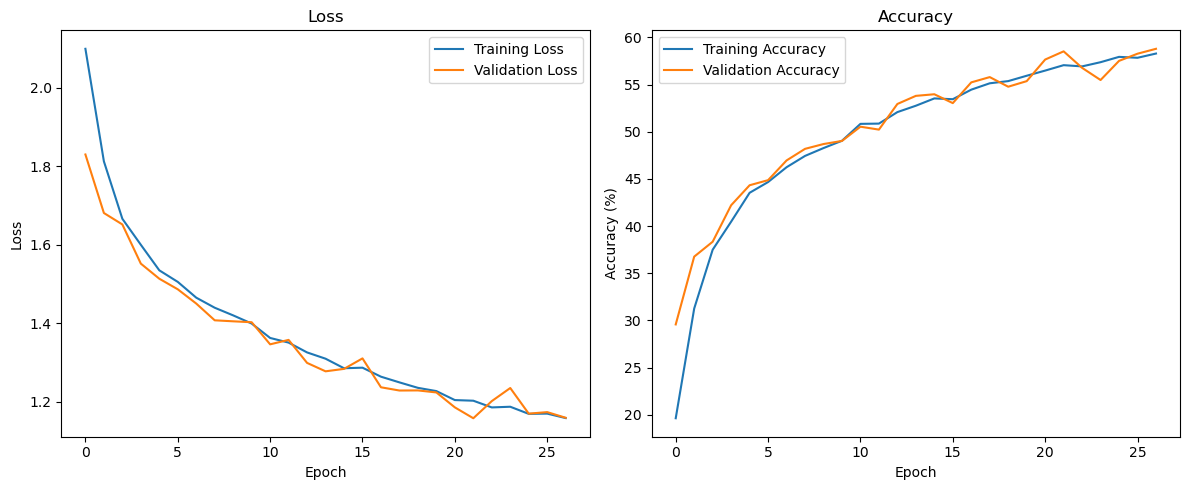

In [ ]:
train(model, train_loader, val_loader,criterion, optimizer, num_epochs=50,patience=5)
print("Training and evaluation complete!")

plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
test(model, test_loader)

Test Accuracy: 59.63%


ADAM

Epoch 1/30: 100%|██████████| 313/313 [00:09<00:00, 31.73it/s]


Epoch [1/30] - Train Loss: 1.8277, Train Accuracy: 32.17% | Val Loss: 1.5940, Val Accuracy: 39.62%


Epoch 2/30: 100%|██████████| 313/313 [00:09<00:00, 31.47it/s]


Epoch [2/30] - Train Loss: 1.6094, Train Accuracy: 40.81% | Val Loss: 1.4961, Val Accuracy: 44.90%


Epoch 3/30: 100%|██████████| 313/313 [00:13<00:00, 23.78it/s]


Epoch [3/30] - Train Loss: 1.4434, Train Accuracy: 47.75% | Val Loss: 1.3372, Val Accuracy: 51.39%


Epoch 4/30: 100%|██████████| 313/313 [00:12<00:00, 24.31it/s]


Epoch [4/30] - Train Loss: 1.3488, Train Accuracy: 51.77% | Val Loss: 1.2433, Val Accuracy: 55.46%


Epoch 5/30: 100%|██████████| 313/313 [00:12<00:00, 25.41it/s]


Epoch [5/30] - Train Loss: 1.2530, Train Accuracy: 55.10% | Val Loss: 1.2237, Val Accuracy: 56.37%


Epoch 6/30: 100%|██████████| 313/313 [00:12<00:00, 24.96it/s]


Epoch [6/30] - Train Loss: 1.1746, Train Accuracy: 58.27% | Val Loss: 1.1605, Val Accuracy: 59.13%


Epoch 7/30: 100%|██████████| 313/313 [00:12<00:00, 24.74it/s]


Epoch [7/30] - Train Loss: 1.1330, Train Accuracy: 59.82% | Val Loss: 1.1340, Val Accuracy: 59.37%


Epoch 8/30: 100%|██████████| 313/313 [00:10<00:00, 29.86it/s]


Epoch [8/30] - Train Loss: 1.0898, Train Accuracy: 61.51% | Val Loss: 1.0424, Val Accuracy: 63.16%


Epoch 9/30: 100%|██████████| 313/313 [00:10<00:00, 30.47it/s]


Epoch [9/30] - Train Loss: 1.0758, Train Accuracy: 61.84% | Val Loss: 1.0779, Val Accuracy: 61.74%


Epoch 10/30: 100%|██████████| 313/313 [00:10<00:00, 30.64it/s]


Epoch [10/30] - Train Loss: 1.0419, Train Accuracy: 63.05% | Val Loss: 1.0074, Val Accuracy: 64.23%


Epoch 11/30: 100%|██████████| 313/313 [00:11<00:00, 26.66it/s]


Epoch [11/30] - Train Loss: 1.0284, Train Accuracy: 63.58% | Val Loss: 1.0900, Val Accuracy: 62.36%


Epoch 12/30: 100%|██████████| 313/313 [00:09<00:00, 33.55it/s]


Epoch [12/30] - Train Loss: 1.0278, Train Accuracy: 63.55% | Val Loss: 1.0169, Val Accuracy: 63.77%


Epoch 13/30: 100%|██████████| 313/313 [00:09<00:00, 33.65it/s]


Epoch [13/30] - Train Loss: 1.0187, Train Accuracy: 64.32% | Val Loss: 1.0031, Val Accuracy: 64.81%


Epoch 14/30: 100%|██████████| 313/313 [00:09<00:00, 34.27it/s]


Epoch [14/30] - Train Loss: 1.0284, Train Accuracy: 63.55% | Val Loss: 0.9779, Val Accuracy: 65.79%


Epoch 15/30: 100%|██████████| 313/313 [00:09<00:00, 32.84it/s]


Epoch [15/30] - Train Loss: 1.0341, Train Accuracy: 63.33% | Val Loss: 1.0155, Val Accuracy: 64.60%


Epoch 16/30: 100%|██████████| 313/313 [00:11<00:00, 26.87it/s]


Epoch [16/30] - Train Loss: 1.0183, Train Accuracy: 64.14% | Val Loss: 0.9930, Val Accuracy: 65.20%


Epoch 17/30: 100%|██████████| 313/313 [00:11<00:00, 27.08it/s]


Epoch [17/30] - Train Loss: 1.0096, Train Accuracy: 64.41% | Val Loss: 1.0328, Val Accuracy: 63.57%


Epoch 18/30: 100%|██████████| 313/313 [00:11<00:00, 26.66it/s]


Epoch [18/30] - Train Loss: 0.9992, Train Accuracy: 64.83% | Val Loss: 1.0470, Val Accuracy: 63.33%


Epoch 19/30: 100%|██████████| 313/313 [00:11<00:00, 27.21it/s]


Epoch [19/30] - Train Loss: 1.0070, Train Accuracy: 64.53% | Val Loss: 0.9640, Val Accuracy: 66.13%


Epoch 20/30: 100%|██████████| 313/313 [00:11<00:00, 27.29it/s]


Epoch [20/30] - Train Loss: 1.0065, Train Accuracy: 64.62% | Val Loss: 1.0116, Val Accuracy: 64.66%


Epoch 21/30: 100%|██████████| 313/313 [00:12<00:00, 25.95it/s]


Epoch [21/30] - Train Loss: 1.0317, Train Accuracy: 63.67% | Val Loss: 0.9726, Val Accuracy: 66.07%


Epoch 22/30: 100%|██████████| 313/313 [00:11<00:00, 26.98it/s]


Epoch [22/30] - Train Loss: 1.0250, Train Accuracy: 63.88% | Val Loss: 0.9662, Val Accuracy: 65.46%


Epoch 23/30: 100%|██████████| 313/313 [00:11<00:00, 27.02it/s]


Epoch [23/30] - Train Loss: 1.0343, Train Accuracy: 63.53% | Val Loss: 1.1449, Val Accuracy: 59.19%


Epoch 24/30: 100%|██████████| 313/313 [00:11<00:00, 26.83it/s]


Epoch [24/30] - Train Loss: 1.0455, Train Accuracy: 63.25% | Val Loss: 1.0031, Val Accuracy: 65.28%
Early stopping triggered after 24 epochs without improvement.
Training and evaluation complete!


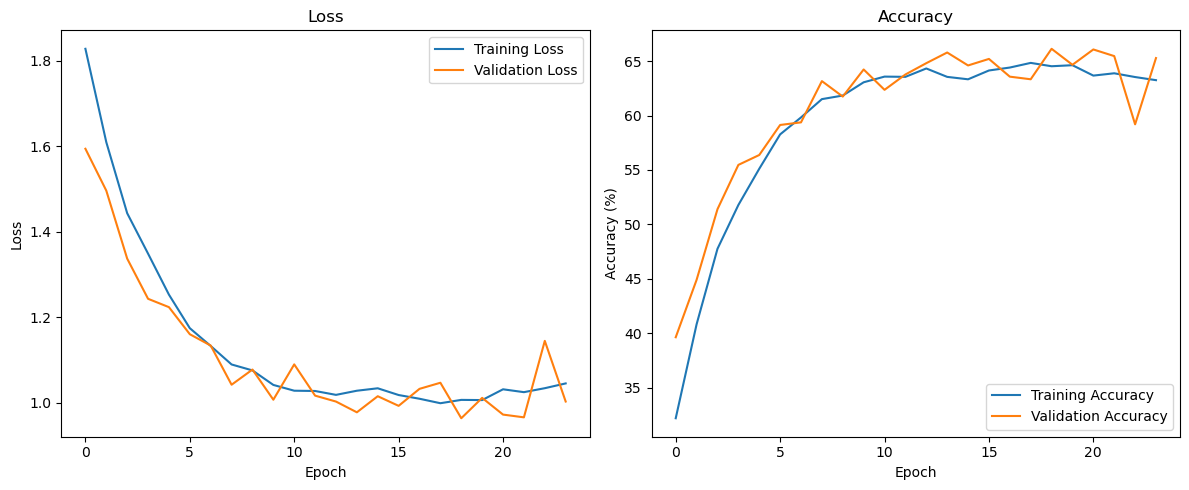

Test Accuracy: 66.97%


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
model = ModifiedMobileNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-5)
train(model, train_loader, val_loader,criterion, optimizer, num_epochs=30,patience=5)
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

test(model, test_loader)

hyper parameter tuning

In [ ]:
best_model_path = "best_model_mobilenet.pth"
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)
    batch_size = trial.suggest_int('batch_size', 256,1024)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)
    model = ModifiedMobileNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay) 
    scaler = GradScaler("cuda")
    num_epochs, patience, trials_without_improvement = 30, 5, 0
    best_val_loss = float('inf')

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast(device_type="cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        model.eval()
        val_loss = sum(criterion(model(images.to(device)), labels.to(device)).item() for images, labels in val_loader) / len(val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trials_without_improvement = 0
            # Save the best model and hyperparameters
            torch.save({'model_state_dict': model.state_dict(), 'learning_rate': learning_rate, 'batch_size': batch_size,'weight_decay':weight_decay}, best_model_path)
            print(f"New best model saved with validation loss: {val_loss}")
        else:
            trials_without_improvement += 1

        if trials_without_improvement >= patience:
            print(f"Early stopping on epoch {epoch + 1}.")
            break
    
    return best_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best parameters:", study.best_params)
print("Best validation loss:", study.best_value)
print(f"Best model saved at {best_model_path}")

[I 2024-11-04 18:01:53,780] A new study created in memory with name: no-name-c6c86886-6e1e-483b-a73d-b60762890dd8


New best model saved with validation loss: 2.0309068030781217
New best model saved with validation loss: 1.6915423538949754
New best model saved with validation loss: 1.5324710938665602
New best model saved with validation loss: 1.251282446914249
New best model saved with validation loss: 1.1123851074112787
New best model saved with validation loss: 1.0096719430552588
New best model saved with validation loss: 0.9943879511621263
New best model saved with validation loss: 0.81701570087009
New best model saved with validation loss: 0.7436452176835802
New best model saved with validation loss: 0.730493168036143
New best model saved with validation loss: 0.6730170746644338
New best model saved with validation loss: 0.6692071292135451
New best model saved with validation loss: 0.6169847150643667
New best model saved with validation loss: 0.6100285020139482
New best model saved with validation loss: 0.5763489935133193
New best model saved with validation loss: 0.5682162874274783
New best mod

[I 2024-11-04 18:07:19,923] Trial 0 finished with value: 0.4782053579886754 and parameters: {'learning_rate': 0.007308549074065282, 'batch_size': 572, 'weight_decay': 2.569373697887709e-06}. Best is trial 0 with value: 0.4782053579886754.


New best model saved with validation loss: 0.4782053579886754
New best model saved with validation loss: 1.7323017120361328
New best model saved with validation loss: 1.5034619927406312
New best model saved with validation loss: 1.3646296560764313
New best model saved with validation loss: 1.148316353559494
New best model saved with validation loss: 1.0203496366739273
New best model saved with validation loss: 0.9876488298177719
New best model saved with validation loss: 0.8751312077045441
New best model saved with validation loss: 0.7577076315879822
New best model saved with validation loss: 0.7336810410022736
New best model saved with validation loss: 0.6785464882850647
New best model saved with validation loss: 0.6215802669525147
New best model saved with validation loss: 0.603859880566597
New best model saved with validation loss: 0.5915634498000145
New best model saved with validation loss: 0.5726584956049919
New best model saved with validation loss: 0.5482640132308007
New best m

[I 2024-11-04 18:12:55,461] Trial 1 finished with value: 0.45647655576467516 and parameters: {'learning_rate': 0.00482683693547161, 'batch_size': 523, 'weight_decay': 2.4416404128491178e-05}. Best is trial 1 with value: 0.45647655576467516.


New best model saved with validation loss: 1.753231167793274
New best model saved with validation loss: 1.4119757924761092
New best model saved with validation loss: 1.228279982294355
New best model saved with validation loss: 1.0676640016692025
New best model saved with validation loss: 1.0251764271940504
New best model saved with validation loss: 0.9477144820349557
New best model saved with validation loss: 0.8461198082992009
New best model saved with validation loss: 0.784864434174129
New best model saved with validation loss: 0.7353741484028953
New best model saved with validation loss: 0.6251218978847776
New best model saved with validation loss: 0.602856249681541
New best model saved with validation loss: 0.5789582867707525
New best model saved with validation loss: 0.56487373901265
New best model saved with validation loss: 0.5476201134068626
New best model saved with validation loss: 0.5201468169689178


[I 2024-11-04 18:17:28,382] Trial 2 finished with value: 0.5201468169689178 and parameters: {'learning_rate': 0.009714628532206237, 'batch_size': 367, 'weight_decay': 2.4155642404640594e-06}. Best is trial 1 with value: 0.45647655576467516.


Early stopping on epoch 24.
New best model saved with validation loss: 2.6060372482646597
New best model saved with validation loss: 1.5822042985395952
New best model saved with validation loss: 1.4961973428726196
New best model saved with validation loss: 1.3536201281981035
New best model saved with validation loss: 1.1573722904378718
New best model saved with validation loss: 1.0689231211488897
New best model saved with validation loss: 0.9683203209530223
New best model saved with validation loss: 0.9280182502486489
New best model saved with validation loss: 0.8324411023746837
New best model saved with validation loss: 0.7273085605014454
New best model saved with validation loss: 0.7239700826731595
New best model saved with validation loss: 0.6994810646230524
New best model saved with validation loss: 0.6635811220515858
New best model saved with validation loss: 0.6255649761720137
New best model saved with validation loss: 0.6062550598924811
New best model saved with validation loss:

[I 2024-11-04 18:22:42,861] Trial 3 finished with value: 0.5431219230998646 and parameters: {'learning_rate': 0.0029936408792487074, 'batch_size': 918, 'weight_decay': 3.9466514031499906e-05}. Best is trial 1 with value: 0.45647655576467516.


New best model saved with validation loss: 2.042537203856877
New best model saved with validation loss: 1.7362349246229445
New best model saved with validation loss: 1.3228421935013361
New best model saved with validation loss: 1.2100694222109658
New best model saved with validation loss: 1.0703544786998205
New best model saved with validation loss: 0.996814067874636
New best model saved with validation loss: 0.848227613738605
New best model saved with validation loss: 0.8191796796662467
New best model saved with validation loss: 0.8078141467911857
New best model saved with validation loss: 0.6860184414046151
New best model saved with validation loss: 0.5786910142217364
New best model saved with validation loss: 0.5582473597356251
New best model saved with validation loss: 0.5567237255828721
New best model saved with validation loss: 0.5535934844187328
New best model saved with validation loss: 0.5417991706303188
New best model saved with validation loss: 0.529299643422876
New best mod

[I 2024-11-04 18:27:50,888] Trial 4 finished with value: 0.45901677331754137 and parameters: {'learning_rate': 0.009554058902052924, 'batch_size': 359, 'weight_decay': 6.9221071669177764e-06}. Best is trial 1 with value: 0.45647655576467516.


New best model saved with validation loss: 0.45901677331754137
New best model saved with validation loss: 2.608619836660532
New best model saved with validation loss: 1.7253607236422026
New best model saved with validation loss: 1.3953070915662324
New best model saved with validation loss: 1.3181357292028575
New best model saved with validation loss: 1.2831814564191377
New best model saved with validation loss: 1.163164074604328
New best model saved with validation loss: 1.0829311242470374
New best model saved with validation loss: 1.0492482643861036
New best model saved with validation loss: 0.9134710660347571
New best model saved with validation loss: 0.8580703460253202
New best model saved with validation loss: 0.7818807638608493
New best model saved with validation loss: 0.7248963713645935
New best model saved with validation loss: 0.6916997249309833
New best model saved with validation loss: 0.6423246218607976
New best model saved with validation loss: 0.6062180308195261
New best 

[I 2024-11-04 18:33:34,249] Trial 5 finished with value: 0.5284740122464987 and parameters: {'learning_rate': 0.0023439401505592765, 'batch_size': 789, 'weight_decay': 6.786289473723281e-06}. Best is trial 1 with value: 0.45647655576467516.


New best model saved with validation loss: 0.5284740122464987
New best model saved with validation loss: 2.5500321090221405
New best model saved with validation loss: 1.769962638616562
New best model saved with validation loss: 1.604173205792904
New best model saved with validation loss: 1.547833539545536
New best model saved with validation loss: 1.4455364793539047
New best model saved with validation loss: 1.3761550709605217
New best model saved with validation loss: 1.3419150710105896
New best model saved with validation loss: 1.2764196321368217
New best model saved with validation loss: 1.2278880774974823
New best model saved with validation loss: 1.169161595404148
New best model saved with validation loss: 1.1467816680669785
New best model saved with validation loss: 1.1076242551207542
New best model saved with validation loss: 1.0396834053099155
New best model saved with validation loss: 1.0047439150512218
New best model saved with validation loss: 0.9645702466368675
New best mod

[I 2024-11-04 18:38:56,430] Trial 6 finished with value: 0.7857594601809978 and parameters: {'learning_rate': 0.0005084732692729815, 'batch_size': 625, 'weight_decay': 3.886042903560293e-05}. Best is trial 1 with value: 0.45647655576467516.


New best model saved with validation loss: 2.564937390779194
New best model saved with validation loss: 1.8308850087617572
New best model saved with validation loss: 1.725660386838411
New best model saved with validation loss: 1.645573327415868
New best model saved with validation loss: 1.5568665642487376
New best model saved with validation loss: 1.4967214057320042
New best model saved with validation loss: 1.4550857104753192
New best model saved with validation loss: 1.4045424398623014
New best model saved with validation loss: 1.3638286841543097
New best model saved with validation loss: 1.343216808218705
New best model saved with validation loss: 1.297132316388582
New best model saved with validation loss: 1.288666467917593
New best model saved with validation loss: 1.2553791184174388
New best model saved with validation loss: 1.2133513124365556
New best model saved with validation loss: 1.176378043074357
New best model saved with validation loss: 1.1576303745570935
New best model 

[I 2024-11-04 18:44:28,304] Trial 7 finished with value: 0.9196441204924333 and parameters: {'learning_rate': 0.0003366984784210779, 'batch_size': 535, 'weight_decay': 2.7894755656956253e-05}. Best is trial 1 with value: 0.45647655576467516.


New best model saved with validation loss: 0.9196441204924333
New best model saved with validation loss: 2.4008158553730357
New best model saved with validation loss: 2.232370376586914
New best model saved with validation loss: 2.0077241984280674
New best model saved with validation loss: 1.964632272720337
New best model saved with validation loss: 1.9164833480661565
New best model saved with validation loss: 1.8821408856998791
New best model saved with validation loss: 1.8316850662231445
New best model saved with validation loss: 1.7850113348527388
New best model saved with validation loss: 1.739910971034657
New best model saved with validation loss: 1.7141046632419934
New best model saved with validation loss: 1.677692250771956
New best model saved with validation loss: 1.644705425609242
New best model saved with validation loss: 1.6169293251904575
New best model saved with validation loss: 1.5779076597907327
New best model saved with validation loss: 1.5644363164901733
New best mode

[I 2024-11-04 18:49:45,704] Trial 8 finished with value: 1.3273354010148481 and parameters: {'learning_rate': 0.00011460594886061874, 'batch_size': 940, 'weight_decay': 6.846892236731925e-05}. Best is trial 1 with value: 0.45647655576467516.


New best model saved with validation loss: 1.3273354010148481
New best model saved with validation loss: 2.4311961210691013
New best model saved with validation loss: 1.930424690246582
New best model saved with validation loss: 1.8200585291935847
New best model saved with validation loss: 1.7135411409231334
New best model saved with validation loss: 1.663241643172044
New best model saved with validation loss: 1.6088944215040941
New best model saved with validation loss: 1.5456051551378691
New best model saved with validation loss: 1.4980908999076257
New best model saved with validation loss: 1.4646574167104869
New best model saved with validation loss: 1.4144487931178167
New best model saved with validation loss: 1.3833095752275908
New best model saved with validation loss: 1.3437809577355018
New best model saved with validation loss: 1.2965289079225981
New best model saved with validation loss: 1.2875311558063214
New best model saved with validation loss: 1.2477108790324285
New best m

[I 2024-11-04 18:55:02,280] Trial 9 finished with value: 0.9595915216666001 and parameters: {'learning_rate': 0.0002706910895464374, 'batch_size': 795, 'weight_decay': 1.2194640606217766e-06}. Best is trial 1 with value: 0.45647655576467516.


New best model saved with validation loss: 0.9595915216666001
New best model saved with validation loss: 1.874443997036327
New best model saved with validation loss: 1.597942292690277
New best model saved with validation loss: 1.3581741885705427
New best model saved with validation loss: 1.3457350514151833
New best model saved with validation loss: 1.1828377842903137
New best model saved with validation loss: 1.1054663224653765
New best model saved with validation loss: 1.0390341850844296
New best model saved with validation loss: 0.9259997335347262
New best model saved with validation loss: 0.7888041003183885
New best model saved with validation loss: 0.7664867747913707
New best model saved with validation loss: 0.750406950712204
New best model saved with validation loss: 0.6964879144321788
New best model saved with validation loss: 0.6030887148597024


[I 2024-11-04 18:59:34,092] Trial 10 finished with value: 0.6030887148597024 and parameters: {'learning_rate': 0.0019205312592654178, 'batch_size': 465, 'weight_decay': 1.6874894257601713e-05}. Best is trial 1 with value: 0.45647655576467516.


Early stopping on epoch 26.
New best model saved with validation loss: 1.9698749852902961
New best model saved with validation loss: 1.8195035529859138
New best model saved with validation loss: 1.294020175933838
New best model saved with validation loss: 1.1883024013403691
New best model saved with validation loss: 1.1504793347734394
New best model saved with validation loss: 1.1076147158940632
New best model saved with validation loss: 0.8066874959252097
New best model saved with validation loss: 0.8026544722643766
New best model saved with validation loss: 0.8010545192342816
New best model saved with validation loss: 0.7005158698920048
New best model saved with validation loss: 0.6221485444993684
New best model saved with validation loss: 0.6123858283866536
New best model saved with validation loss: 0.5693340193141591
New best model saved with validation loss: 0.5610020738659482
New best model saved with validation loss: 0.5269193522857897
New best model saved with validation loss: 

[I 2024-11-04 19:04:51,450] Trial 11 finished with value: 0.4810265094944925 and parameters: {'learning_rate': 0.004489173028592381, 'batch_size': 310, 'weight_decay': 9.142220836788282e-06}. Best is trial 1 with value: 0.45647655576467516.


New best model saved with validation loss: 1.733331099534646
New best model saved with validation loss: 1.4215181301801632
New best model saved with validation loss: 1.2969070336757562
New best model saved with validation loss: 1.1766930787991254
New best model saved with validation loss: 1.0043458220286248
New best model saved with validation loss: 0.8770000751201923
New best model saved with validation loss: 0.8068157663712134
New best model saved with validation loss: 0.74064824061516
New best model saved with validation loss: 0.714963572147565
New best model saved with validation loss: 0.7035668675716107
New best model saved with validation loss: 0.700575706286308
New best model saved with validation loss: 0.6986157084122683
New best model saved with validation loss: 0.6582748752373916
New best model saved with validation loss: 0.6328574862235632
New best model saved with validation loss: 0.6000544956097236
New best model saved with validation loss: 0.5883472049847628
New best mode

[I 2024-11-04 19:09:58,221] Trial 12 finished with value: 0.5223207137523553 and parameters: {'learning_rate': 0.0011442063480819006, 'batch_size': 259, 'weight_decay': 5.400659608287188e-06}. Best is trial 1 with value: 0.45647655576467516.


New best model saved with validation loss: 0.5223207137523553
New best model saved with validation loss: 1.7076343194298123
New best model saved with validation loss: 1.4613714166309522
New best model saved with validation loss: 1.3752059210901675
New best model saved with validation loss: 1.1191282090933428
New best model saved with validation loss: 1.0066254398097163
New best model saved with validation loss: 0.9697821062544117
New best model saved with validation loss: 0.9160461944082509
New best model saved with validation loss: 0.8490115196808524
New best model saved with validation loss: 0.7275036754815475
New best model saved with validation loss: 0.6455510103184244
New best model saved with validation loss: 0.6255621003068011
New best model saved with validation loss: 0.5671393767647122
New best model saved with validation loss: 0.5462882479895717
New best model saved with validation loss: 0.5142452133738477
New best model saved with validation loss: 0.5033401795055555
New best

[I 2024-11-04 19:15:08,121] Trial 13 finished with value: 0.44858090514722077 and parameters: {'learning_rate': 0.005632539698386595, 'batch_size': 437, 'weight_decay': 1.452347209879977e-05}. Best is trial 13 with value: 0.44858090514722077.


New best model saved with validation loss: 0.44858090514722077
New best model saved with validation loss: 1.8466170559758726
New best model saved with validation loss: 1.3898591632428376
New best model saved with validation loss: 1.2988239630408909
New best model saved with validation loss: 0.9918640022692473
New best model saved with validation loss: 0.984183220759682
New best model saved with validation loss: 0.8699152936106143
New best model saved with validation loss: 0.8138922452926636
New best model saved with validation loss: 0.7721715750901595
New best model saved with validation loss: 0.6810172925824705
New best model saved with validation loss: 0.6658117071441982
New best model saved with validation loss: 0.6608427659324978
New best model saved with validation loss: 0.6033026239146357
New best model saved with validation loss: 0.5647838452587957
New best model saved with validation loss: 0.5409831586091415
New best model saved with validation loss: 0.5344561571660249
New best

[I 2024-11-04 19:20:18,433] Trial 14 finished with value: 0.4613385537396307 and parameters: {'learning_rate': 0.005097468860942046, 'batch_size': 452, 'weight_decay': 1.6347283055897702e-05}. Best is trial 13 with value: 0.44858090514722077.


New best model saved with validation loss: 2.765296634038289
New best model saved with validation loss: 1.6032673676808675
New best model saved with validation loss: 1.4189577579498291
New best model saved with validation loss: 1.4159995476404825
New best model saved with validation loss: 1.2677446762720743
New best model saved with validation loss: 1.1491816600163778
New best model saved with validation loss: 1.1318482478459677
New best model saved with validation loss: 1.111019778251648
New best model saved with validation loss: 0.9700933814048767
New best model saved with validation loss: 0.9017130374908447
New best model saved with validation loss: 0.892195983727773
New best model saved with validation loss: 0.7903577605883281
New best model saved with validation loss: 0.7678765853246053
New best model saved with validation loss: 0.7447697838147481
New best model saved with validation loss: 0.6664198637008667
New best model saved with validation loss: 0.6579661250114441
New best mo

[I 2024-11-04 19:25:32,533] Trial 15 finished with value: 0.5814255038897197 and parameters: {'learning_rate': 0.0015289384811831524, 'batch_size': 686, 'weight_decay': 9.985165999848087e-05}. Best is trial 13 with value: 0.44858090514722077.


New best model saved with validation loss: 1.6187186914941538
New best model saved with validation loss: 1.4310158076493635
New best model saved with validation loss: 1.3248070530269458
New best model saved with validation loss: 1.2859336759733118
New best model saved with validation loss: 0.9995046620783599
New best model saved with validation loss: 0.9059018078057662
New best model saved with validation loss: 0.8610708039739857
New best model saved with validation loss: 0.8394863164943197
New best model saved with validation loss: 0.7409697019535563
New best model saved with validation loss: 0.7294706028440724
New best model saved with validation loss: 0.6722083143565966
New best model saved with validation loss: 0.6689669463945471
New best model saved with validation loss: 0.576045423746109
New best model saved with validation loss: 0.5421742524789728
New best model saved with validation loss: 0.5375373169131901
New best model saved with validation loss: 0.47293398950410925
New best

[I 2024-11-04 19:30:32,816] Trial 16 finished with value: 0.4719381759996 and parameters: {'learning_rate': 0.0037891502045193986, 'batch_size': 450, 'weight_decay': 1.613231324748274e-05}. Best is trial 13 with value: 0.44858090514722077.


Early stopping on epoch 29.
New best model saved with validation loss: 2.4878578186035156
New best model saved with validation loss: 1.6542341391245523
New best model saved with validation loss: 1.510612964630127
New best model saved with validation loss: 1.4178083340326946
New best model saved with validation loss: 1.3465155522028605
New best model saved with validation loss: 1.2955394347508749
New best model saved with validation loss: 1.237006704012553
New best model saved with validation loss: 1.1903695503870646
New best model saved with validation loss: 1.1823312600453695
New best model saved with validation loss: 1.0943501512209575
New best model saved with validation loss: 1.0808951377868652
New best model saved with validation loss: 1.025698713461558
New best model saved with validation loss: 0.9510441263516743
New best model saved with validation loss: 0.9196879903475443
New best model saved with validation loss: 0.8794678052266439
New best model saved with validation loss: 0.

[I 2024-11-04 19:35:48,033] Trial 17 finished with value: 0.6404742081960042 and parameters: {'learning_rate': 0.0008613520055594187, 'batch_size': 694, 'weight_decay': 2.552135224308822e-05}. Best is trial 13 with value: 0.44858090514722077.


New best model saved with validation loss: 0.6404742081960042
New best model saved with validation loss: 1.7913255001369275
New best model saved with validation loss: 1.3955504580547935
New best model saved with validation loss: 1.1416536381370144
New best model saved with validation loss: 1.0364234918042232
New best model saved with validation loss: 0.8729490794633564
New best model saved with validation loss: 0.8115679904034263
New best model saved with validation loss: 0.7363472612280595
New best model saved with validation loss: 0.6954577094630191
New best model saved with validation loss: 0.6784981112731131
New best model saved with validation loss: 0.6617235321747629
New best model saved with validation loss: 0.6470490129370439
New best model saved with validation loss: 0.6023984174979361
New best model saved with validation loss: 0.5499535642172161
New best model saved with validation loss: 0.54080783222851
New best model saved with validation loss: 0.5400602346972415
New best m

[I 2024-11-04 19:41:00,537] Trial 18 finished with value: 0.4438578847207521 and parameters: {'learning_rate': 0.006289677948402155, 'batch_size': 541, 'weight_decay': 4.276336099816458e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 0.4438578847207521
New best model saved with validation loss: 1.834074928210332
New best model saved with validation loss: 1.5759140161367564
New best model saved with validation loss: 1.4356921223493724
New best model saved with validation loss: 1.3841451681577241
New best model saved with validation loss: 1.297420350404886
New best model saved with validation loss: 1.2217101454734802
New best model saved with validation loss: 1.1073576991374676
New best model saved with validation loss: 1.0912154156428118
New best model saved with validation loss: 1.0579166618677287
New best model saved with validation loss: 0.9798689897243793
New best model saved with validation loss: 0.9513082664746505
New best model saved with validation loss: 0.8630236868674939
New best model saved with validation loss: 0.8246046969523797
New best model saved with validation loss: 0.7912406187791091
New best model saved with validation loss: 0.7609490706370428
New best m

[I 2024-11-04 19:46:19,230] Trial 19 finished with value: 0.5873252371182809 and parameters: {'learning_rate': 0.0008368644725170033, 'batch_size': 397, 'weight_decay': 3.3955746670274352e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 0.5873252371182809
New best model saved with validation loss: 1.6448938285603243
New best model saved with validation loss: 1.402695704908932
New best model saved with validation loss: 1.293067925116595
New best model saved with validation loss: 1.0118806116721208
New best model saved with validation loss: 0.8702684956438401
New best model saved with validation loss: 0.8153387027628282
New best model saved with validation loss: 0.6899434748817893
New best model saved with validation loss: 0.6788471306071562
New best model saved with validation loss: 0.6395792750751271
New best model saved with validation loss: 0.575096424888162
New best model saved with validation loss: 0.5563444249770221
New best model saved with validation loss: 0.5460546805578119
New best model saved with validation loss: 0.5179500562303206
New best model saved with validation loss: 0.5050801967873293
New best model saved with validation loss: 0.49631692556773915
New best m

[I 2024-11-04 19:51:33,418] Trial 20 finished with value: 0.45018712387365456 and parameters: {'learning_rate': 0.00656217107909218, 'batch_size': 591, 'weight_decay': 1.3037012251088937e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 1.639751855064841
New best model saved with validation loss: 1.533189948867349
New best model saved with validation loss: 1.3479990818921257
New best model saved with validation loss: 1.210655506919412
New best model saved with validation loss: 1.1546514945871689
New best model saved with validation loss: 1.0210207595544702
New best model saved with validation loss: 0.9212422370910645
New best model saved with validation loss: 0.8085919688729679
New best model saved with validation loss: 0.7387072829639211
New best model saved with validation loss: 0.7318391729803646
New best model saved with validation loss: 0.6899229638716754
New best model saved with validation loss: 0.6484614750918221
New best model saved with validation loss: 0.6213681487476125
New best model saved with validation loss: 0.6094221823355731
New best model saved with validation loss: 0.5642049768391777
New best model saved with validation loss: 0.5488765344900244


[I 2024-11-04 19:55:33,486] Trial 21 finished with value: 0.5488765344900244 and parameters: {'learning_rate': 0.006258059154884207, 'batch_size': 607, 'weight_decay': 1.1656671177816547e-06}. Best is trial 18 with value: 0.4438578847207521.


Early stopping on epoch 23.
New best model saved with validation loss: 1.6122896254062653
New best model saved with validation loss: 1.562346774339676
New best model saved with validation loss: 1.2942173421382903
New best model saved with validation loss: 1.185326063632965
New best model saved with validation loss: 1.1088441967964173
New best model saved with validation loss: 1.0136812835931779
New best model saved with validation loss: 0.9122822016477585
New best model saved with validation loss: 0.876460736989975
New best model saved with validation loss: 0.8207610636949539
New best model saved with validation loss: 0.7493230879306794
New best model saved with validation loss: 0.7220873355865478
New best model saved with validation loss: 0.636230331659317
New best model saved with validation loss: 0.6157117336988449
New best model saved with validation loss: 0.576616270840168
New best model saved with validation loss: 0.5519894748926163
New best model saved with validation loss: 0.53

[I 2024-11-04 20:00:45,447] Trial 22 finished with value: 0.46550567001104354 and parameters: {'learning_rate': 0.0029329468396061295, 'batch_size': 500, 'weight_decay': 1.6161955718974416e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 0.46550567001104354
New best model saved with validation loss: 1.8152016560236612
New best model saved with validation loss: 1.6024939616521199
New best model saved with validation loss: 1.3894308964411417
New best model saved with validation loss: 1.2359548727671306
New best model saved with validation loss: 1.0458335121472677
New best model saved with validation loss: 0.9378361185391744
New best model saved with validation loss: 0.922193686167399
New best model saved with validation loss: 0.8390097141265869
New best model saved with validation loss: 0.7802087306976319
New best model saved with validation loss: 0.713336181640625
New best model saved with validation loss: 0.7009140412012737
New best model saved with validation loss: 0.698989991346995
New best model saved with validation loss: 0.680204971631368
New best model saved with validation loss: 0.6570743362108866
New best model saved with validation loss: 0.616232717037201
New best mod

[I 2024-11-04 20:06:00,138] Trial 23 finished with value: 0.4542272309462229 and parameters: {'learning_rate': 0.0070126918077206375, 'batch_size': 701, 'weight_decay': 3.929436205668365e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 2.5756739377975464
New best model saved with validation loss: 1.8918070708002364
New best model saved with validation loss: 1.4990317395755224
New best model saved with validation loss: 1.1297322724546706
New best model saved with validation loss: 0.9313625565596989
New best model saved with validation loss: 0.8527287372520992
New best model saved with validation loss: 0.7991831941264016
New best model saved with validation loss: 0.7796086881841932
New best model saved with validation loss: 0.7265513241291046
New best model saved with validation loss: 0.7227015921047756
New best model saved with validation loss: 0.6456080632550376
New best model saved with validation loss: 0.6339271409170968
New best model saved with validation loss: 0.6049210918801171
New best model saved with validation loss: 0.5878386731658664
New best model saved with validation loss: 0.5769779618297305
New best model saved with validation loss: 0.5629169919661113
New best

[I 2024-11-04 20:11:17,984] Trial 24 finished with value: 0.5042977631092072 and parameters: {'learning_rate': 0.0037802464549072596, 'batch_size': 766, 'weight_decay': 1.1604584878764464e-05}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 1.7795233461591933
New best model saved with validation loss: 1.450277030467987
New best model saved with validation loss: 1.2157053748766582
New best model saved with validation loss: 1.1891815066337585
New best model saved with validation loss: 1.0069470372464921
New best model saved with validation loss: 0.827922910451889
New best model saved with validation loss: 0.8278064462873671
New best model saved with validation loss: 0.7292429837915633
New best model saved with validation loss: 0.6728971004486084
New best model saved with validation loss: 0.6537302003966438
New best model saved with validation loss: 0.5782447854677836
New best model saved with validation loss: 0.56826827261183
New best model saved with validation loss: 0.5453718271520402
New best model saved with validation loss: 0.5431444694598516
New best model saved with validation loss: 0.5056497785780165
New best model saved with validation loss: 0.4497710035906898


[I 2024-11-04 20:16:31,106] Trial 25 finished with value: 0.4497710035906898 and parameters: {'learning_rate': 0.006334807323902896, 'batch_size': 578, 'weight_decay': 1.9640386784529298e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 1.8098197603225707
New best model saved with validation loss: 1.4624269819259643
New best model saved with validation loss: 1.3010434484481812
New best model saved with validation loss: 1.2482035493850707
New best model saved with validation loss: 1.096540105342865
New best model saved with validation loss: 1.0195714521408081
New best model saved with validation loss: 0.9423364591598511
New best model saved with validation loss: 0.9158416223526001
New best model saved with validation loss: 0.8348127627372741
New best model saved with validation loss: 0.7965349006652832
New best model saved with validation loss: 0.7238474917411805
New best model saved with validation loss: 0.659232964515686
New best model saved with validation loss: 0.6571717429161071
New best model saved with validation loss: 0.6399295043945312
New best model saved with validation loss: 0.6337553095817566
New best model saved with validation loss: 0.6099538922309875
New best m

[I 2024-11-04 20:21:49,602] Trial 26 finished with value: 0.50391193151474 and parameters: {'learning_rate': 0.001811032838528274, 'batch_size': 411, 'weight_decay': 1.876752508792114e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 2.2815510975687125
New best model saved with validation loss: 1.7462966567591618
New best model saved with validation loss: 1.3445161392814236
New best model saved with validation loss: 1.1599175051638955
New best model saved with validation loss: 0.9694698390207792
New best model saved with validation loss: 0.8867347428673192
New best model saved with validation loss: 0.8367401988882768
New best model saved with validation loss: 0.81760321165386
New best model saved with validation loss: 0.7518291504759538
New best model saved with validation loss: 0.7394455388972634
New best model saved with validation loss: 0.7173960428488882
New best model saved with validation loss: 0.6766793351424368
New best model saved with validation loss: 0.5902107389349687
New best model saved with validation loss: 0.5683158228271886
New best model saved with validation loss: 0.5384413850934882
New best model saved with validation loss: 0.5197027357001054


[I 2024-11-04 20:27:04,240] Trial 27 finished with value: 0.490195316703696 and parameters: {'learning_rate': 0.009238461761091665, 'batch_size': 533, 'weight_decay': 4.444310195477637e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 0.490195316703696
New best model saved with validation loss: 1.8474590977032979
New best model saved with validation loss: 1.5087048411369324
New best model saved with validation loss: 1.4531836178567674
New best model saved with validation loss: 1.3343549569447835
New best model saved with validation loss: 1.0294844508171082
New best model saved with validation loss: 0.9704074958960215
New best model saved with validation loss: 0.965901169512007
New best model saved with validation loss: 0.8649807439910041
New best model saved with validation loss: 0.8417739835050371
New best model saved with validation loss: 0.7706347439024184
New best model saved with validation loss: 0.7376662890116373
New best model saved with validation loss: 0.7095106376541985
New best model saved with validation loss: 0.6754130158159468
New best model saved with validation loss: 0.6560339563422732
New best model saved with validation loss: 0.6090841359562345
New best m

[I 2024-11-04 20:32:18,147] Trial 28 finished with value: 0.4946507596307331 and parameters: {'learning_rate': 0.002847847569013897, 'batch_size': 572, 'weight_decay': 2.898447598961561e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 0.4946507596307331
New best model saved with validation loss: 1.9025453105568886
New best model saved with validation loss: 1.3807960748672485
New best model saved with validation loss: 1.3696874529123306
New best model saved with validation loss: 1.1362423934042454
New best model saved with validation loss: 0.860861174762249
New best model saved with validation loss: 0.7595218382775784
New best model saved with validation loss: 0.75826470926404
New best model saved with validation loss: 0.7324714697897434
New best model saved with validation loss: 0.7133820131421089
New best model saved with validation loss: 0.5921248383820057
New best model saved with validation loss: 0.5682167056947947
New best model saved with validation loss: 0.5206300038844347


[I 2024-11-04 20:36:50,074] Trial 29 finished with value: 0.5206300038844347 and parameters: {'learning_rate': 0.005627233882906637, 'batch_size': 655, 'weight_decay': 2.019281460300163e-06}. Best is trial 18 with value: 0.4438578847207521.


Early stopping on epoch 26.
New best model saved with validation loss: 2.538030982017517
New best model saved with validation loss: 1.6396424685205733
New best model saved with validation loss: 1.4230917947632926
New best model saved with validation loss: 1.3044351424489702
New best model saved with validation loss: 1.2730841210910253
New best model saved with validation loss: 1.1507902826581682
New best model saved with validation loss: 1.1152406930923462
New best model saved with validation loss: 1.023778532232557
New best model saved with validation loss: 0.9761620674814496
New best model saved with validation loss: 0.9153505691460201
New best model saved with validation loss: 0.8510178412709918
New best model saved with validation loss: 0.7902990792478833
New best model saved with validation loss: 0.7689275997025626
New best model saved with validation loss: 0.7523034598146167
New best model saved with validation loss: 0.7049611934593746
New best model saved with validation loss: 0

[I 2024-11-04 20:42:05,303] Trial 30 finished with value: 0.5647266038826534 and parameters: {'learning_rate': 0.0014023414585619537, 'batch_size': 741, 'weight_decay': 9.567456345523902e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 0.5647266038826534
New best model saved with validation loss: 1.7818590612972485
New best model saved with validation loss: 1.505868995890898
New best model saved with validation loss: 1.3522367056678324
New best model saved with validation loss: 1.309626810690936
New best model saved with validation loss: 1.1740112444933724
New best model saved with validation loss: 0.9775890953400556
New best model saved with validation loss: 0.926519141477697
New best model saved with validation loss: 0.8644266268786263
New best model saved with validation loss: 0.8307680137017194
New best model saved with validation loss: 0.7346403809154735
New best model saved with validation loss: 0.6529989558107713
New best model saved with validation loss: 0.6293614085982827
New best model saved with validation loss: 0.5777453552274143
New best model saved with validation loss: 0.5662816026631523


[I 2024-11-04 20:46:07,166] Trial 31 finished with value: 0.5662816026631523 and parameters: {'learning_rate': 0.007208244587537675, 'batch_size': 599, 'weight_decay': 1.015382009734309e-06}. Best is trial 18 with value: 0.4438578847207521.


Early stopping on epoch 23.
New best model saved with validation loss: 1.6692750652631123
New best model saved with validation loss: 1.5667319496472676
New best model saved with validation loss: 1.43199532561832
New best model saved with validation loss: 1.0944010151757135
New best model saved with validation loss: 0.8871713611814711
New best model saved with validation loss: 0.87148427300983
New best model saved with validation loss: 0.8672938181294335
New best model saved with validation loss: 0.7434502144654592
New best model saved with validation loss: 0.7261858185132345
New best model saved with validation loss: 0.6498506267865499
New best model saved with validation loss: 0.6362578140364753
New best model saved with validation loss: 0.5779519544707404
New best model saved with validation loss: 0.5667184972100787
New best model saved with validation loss: 0.5431991451316409
New best model saved with validation loss: 0.5382233262062073
New best model saved with validation loss: 0.5

[I 2024-11-04 20:51:20,967] Trial 32 finished with value: 0.4690330641137229 and parameters: {'learning_rate': 0.004168381624660288, 'batch_size': 575, 'weight_decay': 2.6159248525566075e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 1.6627036843981062
New best model saved with validation loss: 1.5182421661558605
New best model saved with validation loss: 1.380104422569275
New best model saved with validation loss: 1.3343034358251662
New best model saved with validation loss: 1.0320169783773876
New best model saved with validation loss: 0.9119290652729216
New best model saved with validation loss: 0.8274435457729158
New best model saved with validation loss: 0.7666709479831514
New best model saved with validation loss: 0.7205113938876561
New best model saved with validation loss: 0.7082747504824684
New best model saved with validation loss: 0.6729699401628404
New best model saved with validation loss: 0.5967470010121664
New best model saved with validation loss: 0.5841125335012164
New best model saved with validation loss: 0.555792727640697
New best model saved with validation loss: 0.5285425498372033


[I 2024-11-04 20:55:00,075] Trial 33 finished with value: 0.5285425498372033 and parameters: {'learning_rate': 0.007500421397280365, 'batch_size': 497, 'weight_decay': 1.5595951270406198e-06}. Best is trial 18 with value: 0.4438578847207521.


Early stopping on epoch 21.
New best model saved with validation loss: 1.6931873748176975
New best model saved with validation loss: 1.3871557587071468
New best model saved with validation loss: 1.369938147695441
New best model saved with validation loss: 1.1986438412415354
New best model saved with validation loss: 1.020969293619457
New best model saved with validation loss: 0.9391866891007674
New best model saved with validation loss: 0.8197493302194696
New best model saved with validation loss: 0.8151183598919919
New best model saved with validation loss: 0.7525024539545963
New best model saved with validation loss: 0.701448569172307
New best model saved with validation loss: 0.6464852878921911
New best model saved with validation loss: 0.6282972285622045
New best model saved with validation loss: 0.607334902412013
New best model saved with validation loss: 0.5625248692537609
New best model saved with validation loss: 0.541902986012007
New best model saved with validation loss: 0.50

[I 2024-11-04 20:59:53,427] Trial 34 finished with value: 0.48010407937200444 and parameters: {'learning_rate': 0.005678085688178876, 'batch_size': 539, 'weight_decay': 2.1259358813632555e-06}. Best is trial 18 with value: 0.4438578847207521.


Early stopping on epoch 28.
New best model saved with validation loss: 1.9177490522464116
New best model saved with validation loss: 1.6658712128798168
New best model saved with validation loss: 1.3127416918675106
New best model saved with validation loss: 1.28790486852328
New best model saved with validation loss: 1.2098058015108109
New best model saved with validation loss: 0.9921969523032507
New best model saved with validation loss: 0.9223249728480974
New best model saved with validation loss: 0.9091499249140421
New best model saved with validation loss: 0.8132120172182719
New best model saved with validation loss: 0.7696456735332807
New best model saved with validation loss: 0.6863047579924265
New best model saved with validation loss: 0.6732182726264
New best model saved with validation loss: 0.6227828388412794
New best model saved with validation loss: 0.6190696756045023
New best model saved with validation loss: 0.5954811771710714
New best model saved with validation loss: 0.56

[I 2024-11-04 21:05:24,862] Trial 35 finished with value: 0.48377035185694695 and parameters: {'learning_rate': 0.009633626806174838, 'batch_size': 418, 'weight_decay': 1.4642549016589748e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 2.7800489572378306
New best model saved with validation loss: 1.537284227517935
New best model saved with validation loss: 1.3910018939238329
New best model saved with validation loss: 1.2136051929914033
New best model saved with validation loss: 1.070758892939641
New best model saved with validation loss: 1.0705236288217397
New best model saved with validation loss: 0.976481190094581
New best model saved with validation loss: 0.8406769449894245
New best model saved with validation loss: 0.7733715314131516
New best model saved with validation loss: 0.7474907544943002
New best model saved with validation loss: 0.7244515006358807
New best model saved with validation loss: 0.6744467753630418
New best model saved with validation loss: 0.6478046637315017
New best model saved with validation loss: 0.6153797186337985
New best model saved with validation loss: 0.5974432321695181
New best model saved with validation loss: 0.5565628684484042
New best mo

[I 2024-11-04 21:10:59,738] Trial 36 finished with value: 0.501334146811412 and parameters: {'learning_rate': 0.003443211694009107, 'batch_size': 829, 'weight_decay': 2.9646303637666793e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 2.247926577925682
New best model saved with validation loss: 1.501602664589882
New best model saved with validation loss: 1.3920192644000053
New best model saved with validation loss: 1.2693703696131706
New best model saved with validation loss: 1.2240298390388489
New best model saved with validation loss: 1.053451582789421
New best model saved with validation loss: 1.0291490517556667
New best model saved with validation loss: 0.892163846641779
New best model saved with validation loss: 0.8432922065258026
New best model saved with validation loss: 0.8402712680399418
New best model saved with validation loss: 0.7759118713438511
New best model saved with validation loss: 0.7434125691652298
New best model saved with validation loss: 0.7047741413116455
New best model saved with validation loss: 0.6950086578726768
New best model saved with validation loss: 0.6446423642337322
New best model saved with validation loss: 0.641309779137373
New best mode

[I 2024-11-04 21:16:32,410] Trial 37 finished with value: 0.5058811828494072 and parameters: {'learning_rate': 0.0022239621006424665, 'batch_size': 646, 'weight_decay': 5.733521133522195e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 1.7379935756325722
New best model saved with validation loss: 1.5660372152924538
New best model saved with validation loss: 1.3457777053117752
New best model saved with validation loss: 1.0342669282108545
New best model saved with validation loss: 0.9241966977715492
New best model saved with validation loss: 0.8608725275844336
New best model saved with validation loss: 0.80089957639575
New best model saved with validation loss: 0.7124117575585842
New best model saved with validation loss: 0.6819962374866009
New best model saved with validation loss: 0.6169551433995366
New best model saved with validation loss: 0.5985235432162881
New best model saved with validation loss: 0.5946847340092063
New best model saved with validation loss: 0.5327057251706719
New best model saved with validation loss: 0.5281182127073407
New best model saved with validation loss: 0.49847834184765816


[I 2024-11-04 21:21:01,701] Trial 38 finished with value: 0.49847834184765816 and parameters: {'learning_rate': 0.00783531002036142, 'batch_size': 321, 'weight_decay': 4.5039998821118395e-06}. Best is trial 18 with value: 0.4438578847207521.


Early stopping on epoch 24.
New best model saved with validation loss: 2.7028331995010375
New best model saved with validation loss: 1.6706767916679381
New best model saved with validation loss: 1.4072294354438781
New best model saved with validation loss: 1.2481290340423583
New best model saved with validation loss: 1.192812204360962
New best model saved with validation loss: 0.9106466174125671
New best model saved with validation loss: 0.8027182459831238
New best model saved with validation loss: 0.7242291808128357
New best model saved with validation loss: 0.690422797203064
New best model saved with validation loss: 0.6692831695079804
New best model saved with validation loss: 0.660629290342331
New best model saved with validation loss: 0.5984797596931457
New best model saved with validation loss: 0.5635014414787293
New best model saved with validation loss: 0.5385864824056625
New best model saved with validation loss: 0.535141971707344
New best model saved with validation loss: 0.5

[I 2024-11-04 21:27:03,167] Trial 39 finished with value: 0.5133313566446305 and parameters: {'learning_rate': 0.004899516049839494, 'batch_size': 1015, 'weight_decay': 6.7009057547327496e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 0.5133313566446305
New best model saved with validation loss: 1.7945438027381897
New best model saved with validation loss: 1.5630339648988512
New best model saved with validation loss: 1.3705996473630269
New best model saved with validation loss: 1.233722746372223
New best model saved with validation loss: 1.1206026143497891
New best model saved with validation loss: 1.0620754096243117
New best model saved with validation loss: 1.0022172398037381
New best model saved with validation loss: 0.8835687968466017
New best model saved with validation loss: 0.8397283388508691
New best model saved with validation loss: 0.7912193304962583
New best model saved with validation loss: 0.753730058670044
New best model saved with validation loss: 0.7213403847482469
New best model saved with validation loss: 0.6842975616455078
New best model saved with validation loss: 0.6768223345279694
New best model saved with validation loss: 0.667534781826867
New best mo

[I 2024-11-04 21:32:35,229] Trial 40 finished with value: 0.49085070855087704 and parameters: {'learning_rate': 0.0023917618139801086, 'batch_size': 561, 'weight_decay': 1.2117168105799066e-05}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 1.859823989868164
New best model saved with validation loss: 1.6719301462173461
New best model saved with validation loss: 1.4451044162114461
New best model saved with validation loss: 1.2736063718795776
New best model saved with validation loss: 1.1509423017501832
New best model saved with validation loss: 1.1035497705141704
New best model saved with validation loss: 0.9174042900403341
New best model saved with validation loss: 0.7995569388071696
New best model saved with validation loss: 0.7674321055412292
New best model saved with validation loss: 0.7244585593541463
New best model saved with validation loss: 0.6876823822657268
New best model saved with validation loss: 0.659635047117869
New best model saved with validation loss: 0.6255882819493611
New best model saved with validation loss: 0.623344353834788
New best model saved with validation loss: 0.6028223514556885
New best model saved with validation loss: 0.5177615960439046
New best mo

[I 2024-11-04 21:38:08,630] Trial 41 finished with value: 0.4736089070638021 and parameters: {'learning_rate': 0.007238920787617198, 'batch_size': 705, 'weight_decay': 3.7661583371952233e-06}. Best is trial 18 with value: 0.4438578847207521.


New best model saved with validation loss: 0.4736089070638021
New best model saved with validation loss: 1.7079446145466395
New best model saved with validation loss: 1.600422637803214
New best model saved with validation loss: 1.3879270042691911
New best model saved with validation loss: 1.1279934247334797
New best model saved with validation loss: 1.028146349248432
New best model saved with validation loss: 0.9984978976703826
New best model saved with validation loss: 0.9472331688517616
New best model saved with validation loss: 0.8186959198543003
New best model saved with validation loss: 0.783132206825983
New best model saved with validation loss: 0.772774148555029
New best model saved with validation loss: 0.7181611543609983
New best model saved with validation loss: 0.6844550995599656
New best model saved with validation loss: 0.6247199944087437
New best model saved with validation loss: 0.6068425888106936
New best model saved with validation loss: 0.5834366281827291
New best mod

[I 2024-11-04 21:44:12,805] Trial 42 finished with value: 0.4409400125344594 and parameters: {'learning_rate': 0.005769874262064186, 'batch_size': 493, 'weight_decay': 2.557431560478505e-06}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 1.833530863126119
New best model saved with validation loss: 1.6095922106788272
New best model saved with validation loss: 1.4557178247542608
New best model saved with validation loss: 1.1563280820846558
New best model saved with validation loss: 1.1254724037079584
New best model saved with validation loss: 0.9836276088442121
New best model saved with validation loss: 0.9283303987412226
New best model saved with validation loss: 0.8153646758624485
New best model saved with validation loss: 0.8147159417470297
New best model saved with validation loss: 0.7087678682236445
New best model saved with validation loss: 0.6675302982330322
New best model saved with validation loss: 0.6270932413282848
New best model saved with validation loss: 0.607703610545113
New best model saved with validation loss: 0.5649417851652417
New best model saved with validation loss: 0.5511571310815357
New best model saved with validation loss: 0.5348961821624211
New best m

[I 2024-11-04 21:52:02,068] Trial 43 finished with value: 0.448432058095932 and parameters: {'learning_rate': 0.005177797580903881, 'batch_size': 498, 'weight_decay': 2.445179633314369e-06}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 1.9930471125103177
New best model saved with validation loss: 1.4944790658496676
New best model saved with validation loss: 1.3404585690725417
New best model saved with validation loss: 1.1337910294532776
New best model saved with validation loss: 1.0109775747571672
New best model saved with validation loss: 0.9815654101825896
New best model saved with validation loss: 0.8769659002621969
New best model saved with validation loss: 0.7524422832897731
New best model saved with validation loss: 0.7174467274120876
New best model saved with validation loss: 0.6447144548098246
New best model saved with validation loss: 0.6346040680294945
New best model saved with validation loss: 0.6307420702207656
New best model saved with validation loss: 0.596305197193509
New best model saved with validation loss: 0.5579728015831539
New best model saved with validation loss: 0.5317734281222025
New best model saved with validation loss: 0.5189773312636784
New best 

[I 2024-11-04 21:59:53,247] Trial 44 finished with value: 0.4614946927343096 and parameters: {'learning_rate': 0.004876463443255242, 'batch_size': 483, 'weight_decay': 2.082806363774953e-06}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 2.138103993733724
New best model saved with validation loss: 1.9788787404696146
New best model saved with validation loss: 1.878109876314799
New best model saved with validation loss: 1.8271903276443482
New best model saved with validation loss: 1.7512131730715434
New best model saved with validation loss: 1.7057622114817301
New best model saved with validation loss: 1.6599371711413065
New best model saved with validation loss: 1.6173054337501527
New best model saved with validation loss: 1.5859540621439616
New best model saved with validation loss: 1.561035446325938
New best model saved with validation loss: 1.5299872875213623
New best model saved with validation loss: 1.4897289037704469
New best model saved with validation loss: 1.4618303298950195
New best model saved with validation loss: 1.442383070786794
New best model saved with validation loss: 1.4098374485969543
New best model saved with validation loss: 1.3861420075098674
New best mod

[I 2024-11-04 22:06:38,151] Trial 45 finished with value: 1.120558096965154 and parameters: {'learning_rate': 0.0001155305170009409, 'batch_size': 340, 'weight_decay': 3.7770892933235876e-05}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 1.709531034742083
New best model saved with validation loss: 1.3916534355708532
New best model saved with validation loss: 1.1769326882702964
New best model saved with validation loss: 1.0042176970413752
New best model saved with validation loss: 0.9124112405947277
New best model saved with validation loss: 0.8420645764895848
New best model saved with validation loss: 0.7598949692078999
New best model saved with validation loss: 0.6911140722887856
New best model saved with validation loss: 0.6367088268910136
New best model saved with validation loss: 0.6282084488442966
New best model saved with validation loss: 0.588728954749448
New best model saved with validation loss: 0.5777173819286483
New best model saved with validation loss: 0.5659065491386822
New best model saved with validation loss: 0.5553701168724469
New best model saved with validation loss: 0.5226359782474381
New best model saved with validation loss: 0.5051080680319241
New best m

[I 2024-11-04 22:12:30,224] Trial 46 finished with value: 0.45231074733393534 and parameters: {'learning_rate': 0.003386126615815218, 'batch_size': 370, 'weight_decay': 2.6255256350176403e-06}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 0.45231074733393534
New best model saved with validation loss: 1.8536046847053196
New best model saved with validation loss: 1.6307935818381931
New best model saved with validation loss: 1.5156173187753428
New best model saved with validation loss: 1.4306257185728655
New best model saved with validation loss: 1.3588452805643496
New best model saved with validation loss: 1.282536910927814
New best model saved with validation loss: 1.2064076558403347
New best model saved with validation loss: 1.1872500803159631
New best model saved with validation loss: 1.1060428515724514
New best model saved with validation loss: 1.060838777086009
New best model saved with validation loss: 1.0112761595974797
New best model saved with validation loss: 0.9853237141733584
New best model saved with validation loss: 0.9740822729857072
New best model saved with validation loss: 0.9062046978784644
New best model saved with validation loss: 0.868256265702455
New best m

[I 2024-11-04 22:19:04,116] Trial 47 finished with value: 0.6504926033641981 and parameters: {'learning_rate': 0.0005845158635519002, 'batch_size': 443, 'weight_decay': 5.086727382360144e-06}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 0.6504926033641981
New best model saved with validation loss: 1.8746460199356079
New best model saved with validation loss: 1.741268903017044
New best model saved with validation loss: 1.4651146113872529
New best model saved with validation loss: 1.2403197109699249
New best model saved with validation loss: 1.1081790804862977
New best model saved with validation loss: 0.9659593611955642
New best model saved with validation loss: 0.9651069909334182
New best model saved with validation loss: 0.8336161792278289
New best model saved with validation loss: 0.7313536196947098
New best model saved with validation loss: 0.7098603010177612
New best model saved with validation loss: 0.6413523823022842
New best model saved with validation loss: 0.6333886235952377
New best model saved with validation loss: 0.6037864118814469
New best model saved with validation loss: 0.564919812977314


[I 2024-11-04 22:23:02,548] Trial 48 finished with value: 0.564919812977314 and parameters: {'learning_rate': 0.009891375368969682, 'batch_size': 512, 'weight_decay': 8.066707641326469e-06}. Best is trial 42 with value: 0.4409400125344594.


Early stopping on epoch 22.
New best model saved with validation loss: 1.940928659655831
New best model saved with validation loss: 1.6997178684581409
New best model saved with validation loss: 1.153499272736636
New best model saved with validation loss: 1.0177132406017997
New best model saved with validation loss: 1.005338500846516
New best model saved with validation loss: 0.9349289563569155
New best model saved with validation loss: 0.8640260750597174
New best model saved with validation loss: 0.7477781582962383
New best model saved with validation loss: 0.7418182248418982
New best model saved with validation loss: 0.6393654075535861
New best model saved with validation loss: 0.6187110909006812
New best model saved with validation loss: 0.5834023979577151
New best model saved with validation loss: 0.57107052071528
New best model saved with validation loss: 0.5100154348395087
New best model saved with validation loss: 0.4957616004076871
New best model saved with validation loss: 0.49

[I 2024-11-04 22:28:27,520] Trial 49 finished with value: 0.4496765963055871 and parameters: {'learning_rate': 0.004403092932055849, 'batch_size': 471, 'weight_decay': 3.4516208004347733e-06}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 1.597118924964558
New best model saved with validation loss: 1.5180852033875205
New best model saved with validation loss: 1.1938640746203335
New best model saved with validation loss: 1.149655195799741
New best model saved with validation loss: 1.0774015296589246
New best model saved with validation loss: 1.0738661993633618
New best model saved with validation loss: 0.9438637440854852
New best model saved with validation loss: 0.7870229753580961
New best model saved with validation loss: 0.7687821144407446
New best model saved with validation loss: 0.7161138274452903
New best model saved with validation loss: 0.6963958279653029
New best model saved with validation loss: 0.6626237034797668
New best model saved with validation loss: 0.6220089061693712
New best model saved with validation loss: 0.6063695549964905
New best model saved with validation loss: 0.5692785314538262
New best model saved with validation loss: 0.5432644364508715
New best m

[I 2024-11-04 22:33:48,266] Trial 50 finished with value: 0.4968093227256428 and parameters: {'learning_rate': 0.0024949407488863216, 'batch_size': 462, 'weight_decay': 1.3502468511953832e-05}. Best is trial 42 with value: 0.4409400125344594.


Early stopping on epoch 29.
New best model saved with validation loss: 1.6563083623584949
New best model saved with validation loss: 1.478885016943279
New best model saved with validation loss: 1.4343396550730656
New best model saved with validation loss: 1.217867518726148
New best model saved with validation loss: 1.1022742422003495
New best model saved with validation loss: 0.8748794135294462
New best model saved with validation loss: 0.8430627427603069
New best model saved with validation loss: 0.7751960691652799
New best model saved with validation loss: 0.7445389283330817
New best model saved with validation loss: 0.7312006103365045
New best model saved with validation loss: 0.6763519487882915
New best model saved with validation loss: 0.6750670420496088
New best model saved with validation loss: 0.6455560232463636
New best model saved with validation loss: 0.6449378791608309
New best model saved with validation loss: 0.5810953959038383
New best model saved with validation loss: 0

[I 2024-11-04 22:39:18,279] Trial 51 finished with value: 0.45863043948223714 and parameters: {'learning_rate': 0.004151403245075663, 'batch_size': 543, 'weight_decay': 1.942143901125378e-05}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 0.45863043948223714
New best model saved with validation loss: 1.8756251909114696
New best model saved with validation loss: 1.4755780696868896
New best model saved with validation loss: 1.4101905425389607
New best model saved with validation loss: 1.0431207926185042
New best model saved with validation loss: 0.9865831489916201
New best model saved with validation loss: 0.8772418830129836
New best model saved with validation loss: 0.8158350255754259
New best model saved with validation loss: 0.7393782889401471
New best model saved with validation loss: 0.689920390093768
New best model saved with validation loss: 0.6824962452605918
New best model saved with validation loss: 0.5724990665912628
New best model saved with validation loss: 0.5485447556884201
New best model saved with validation loss: 0.5470464086091077
New best model saved with validation loss: 0.5272531178262498
New best model saved with validation loss: 0.5065395600265927
New best

[I 2024-11-04 22:44:50,608] Trial 52 finished with value: 0.45805555361288564 and parameters: {'learning_rate': 0.006079806611776416, 'batch_size': 384, 'weight_decay': 3.1445897909957774e-06}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 1.6675489097833633
New best model saved with validation loss: 1.4689515978097916
New best model saved with validation loss: 1.1907914678255718
New best model saved with validation loss: 1.0662327334284782
New best model saved with validation loss: 1.0502292414506276
New best model saved with validation loss: 0.9755427862207094
New best model saved with validation loss: 0.8132716591159502
New best model saved with validation loss: 0.8120990321040154
New best model saved with validation loss: 0.7845107143123945
New best model saved with validation loss: 0.6820665324727694
New best model saved with validation loss: 0.6243725543220838
New best model saved with validation loss: 0.5765800923109055
New best model saved with validation loss: 0.5762732935448488
New best model saved with validation loss: 0.5259334705770016
New best model saved with validation loss: 0.5234014590581259
New best model saved with validation loss: 0.4848688493172328
New best

[I 2024-11-04 22:50:24,591] Trial 53 finished with value: 0.4442267219225566 and parameters: {'learning_rate': 0.0049985718582066805, 'batch_size': 427, 'weight_decay': 2.2259547093603184e-06}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 1.6762730826934178
New best model saved with validation loss: 1.5851997584104538
New best model saved with validation loss: 1.035311574737231
New best model saved with validation loss: 0.8493766287962595
New best model saved with validation loss: 0.7954658617575964
New best model saved with validation loss: 0.773084782063961
New best model saved with validation loss: 0.662330336868763
New best model saved with validation loss: 0.6082854556540648
New best model saved with validation loss: 0.5867854269842306
New best model saved with validation loss: 0.5413111249605814
New best model saved with validation loss: 0.5341969107588133
New best model saved with validation loss: 0.5219032441576322
New best model saved with validation loss: 0.49239982043703395
New best model saved with validation loss: 0.48968761786818504


[I 2024-11-04 22:56:03,248] Trial 54 finished with value: 0.4746009148657322 and parameters: {'learning_rate': 0.0047548722808147155, 'batch_size': 428, 'weight_decay': 3.6414812253634332e-06}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 0.4746009148657322
New best model saved with validation loss: 1.7340080629695545
New best model saved with validation loss: 1.5686647458509966
New best model saved with validation loss: 1.548837954347784
New best model saved with validation loss: 1.170162103392861
New best model saved with validation loss: 1.0704161037098279
New best model saved with validation loss: 0.8879413252527063
New best model saved with validation loss: 0.8436238928274675
New best model saved with validation loss: 0.7642342366955497
New best model saved with validation loss: 0.7098485664887861
New best model saved with validation loss: 0.6305291300470178
New best model saved with validation loss: 0.6293385137211193
New best model saved with validation loss: 0.6289201514287428
New best model saved with validation loss: 0.5896831371567466
New best model saved with validation loss: 0.5754103904420679
New best model saved with validation loss: 0.5586473874070428
New best m

[I 2024-11-04 23:01:41,686] Trial 55 finished with value: 0.4579815634272315 and parameters: {'learning_rate': 0.0033281202309515625, 'batch_size': 468, 'weight_decay': 2.3945015339203615e-06}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 1.7135649715151107
New best model saved with validation loss: 1.5940331799643381
New best model saved with validation loss: 1.2969041619982038
New best model saved with validation loss: 1.2250510556357248
New best model saved with validation loss: 1.095173020022256
New best model saved with validation loss: 0.9628259096826826
New best model saved with validation loss: 0.7916877576283046
New best model saved with validation loss: 0.7821800776890346
New best model saved with validation loss: 0.696385053225926
New best model saved with validation loss: 0.6687111377716064
New best model saved with validation loss: 0.6552075641495841
New best model saved with validation loss: 0.6369529860360282
New best model saved with validation loss: 0.6099535976137433
New best model saved with validation loss: 0.5735869629042489
New best model saved with validation loss: 0.558656987122127
New best model saved with validation loss: 0.5284845922674452
New best mo

[I 2024-11-04 23:07:17,326] Trial 56 finished with value: 0.4825842414583479 and parameters: {'learning_rate': 0.00852674529663147, 'batch_size': 287, 'weight_decay': 7.593753051376788e-06}. Best is trial 42 with value: 0.4409400125344594.


Early stopping on epoch 30.
New best model saved with validation loss: 1.8555454671382905
New best model saved with validation loss: 1.8363121330738068
New best model saved with validation loss: 1.6283802449703217
New best model saved with validation loss: 1.2354451894760132
New best model saved with validation loss: 0.9874251991510391
New best model saved with validation loss: 0.9042365580797196
New best model saved with validation loss: 0.7993044525384903
New best model saved with validation loss: 0.7682230412960053
New best model saved with validation loss: 0.7352600574493409
New best model saved with validation loss: 0.6806554406881332
New best model saved with validation loss: 0.6439112931489944
New best model saved with validation loss: 0.616574165225029
New best model saved with validation loss: 0.5708382308483124
New best model saved with validation loss: 0.5131643116474152
New best model saved with validation loss: 0.4968442380428314
New best model saved with validation loss: 

[I 2024-11-04 23:12:50,786] Trial 57 finished with value: 0.4443891555070877 and parameters: {'learning_rate': 0.005272937270907774, 'batch_size': 512, 'weight_decay': 2.1225735344741e-05}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 0.4443891555070877
New best model saved with validation loss: 1.7213285010436485
New best model saved with validation loss: 1.543286709949888
New best model saved with validation loss: 1.1280817348381569
New best model saved with validation loss: 1.030374927767392
New best model saved with validation loss: 1.001660924533318
New best model saved with validation loss: 0.9416881429738012
New best model saved with validation loss: 0.8408554504657614
New best model saved with validation loss: 0.8253253410602438
New best model saved with validation loss: 0.7234980607854908
New best model saved with validation loss: 0.7068246068625614
New best model saved with validation loss: 0.6541130933268317
New best model saved with validation loss: 0.6209507564018513
New best model saved with validation loss: 0.5860926961076671
New best model saved with validation loss: 0.553481368155315
New best model saved with validation loss: 0.5310246317551054
New best mod

[I 2024-11-04 23:18:29,606] Trial 58 finished with value: 0.4669815867111601 and parameters: {'learning_rate': 0.005326044465267038, 'batch_size': 354, 'weight_decay': 2.0931995347831852e-05}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 1.647994303703308
New best model saved with validation loss: 1.5737146198749543
New best model saved with validation loss: 1.3854857206344604
New best model saved with validation loss: 1.2119395434856415
New best model saved with validation loss: 1.0755964040756225
New best model saved with validation loss: 0.8846798449754715
New best model saved with validation loss: 0.8846617668867112
New best model saved with validation loss: 0.7814310282468796
New best model saved with validation loss: 0.7688101947307586
New best model saved with validation loss: 0.7668621301651001
New best model saved with validation loss: 0.663793471455574
New best model saved with validation loss: 0.6049339503049851
New best model saved with validation loss: 0.5822378486394882
New best model saved with validation loss: 0.5471447855234146
New best model saved with validation loss: 0.5369976073503494
New best model saved with validation loss: 0.5240387633442879
New best m

[I 2024-11-04 23:23:36,534] Trial 59 finished with value: 0.5010773941874505 and parameters: {'learning_rate': 0.0027262124451065406, 'batch_size': 517, 'weight_decay': 3.234900078710461e-05}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 2.0354532507749705
New best model saved with validation loss: 1.8700881508680491
New best model saved with validation loss: 1.758190902379843
New best model saved with validation loss: 1.6775427598219652
New best model saved with validation loss: 1.60430397437169
New best model saved with validation loss: 1.555342014019306
New best model saved with validation loss: 1.5257441584880536
New best model saved with validation loss: 1.4747347969275255
New best model saved with validation loss: 1.4408399829497704
New best model saved with validation loss: 1.4083486795425415
New best model saved with validation loss: 1.3827664943841786
New best model saved with validation loss: 1.3610276121359606
New best model saved with validation loss: 1.3207626801270704
New best model saved with validation loss: 1.3138790405713594
New best model saved with validation loss: 1.2767539528700023
New best model saved with validation loss: 1.2605805580432599
New best mod

[I 2024-11-04 23:28:46,339] Trial 60 finished with value: 1.0060656735530267 and parameters: {'learning_rate': 0.00019106898643558222, 'batch_size': 394, 'weight_decay': 5.144179260600905e-05}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 1.617440286136809
New best model saved with validation loss: 1.2816853182656425
New best model saved with validation loss: 1.1280590380941118
New best model saved with validation loss: 1.0177180511610848
New best model saved with validation loss: 0.9324292427017575
New best model saved with validation loss: 0.8113941976002285
New best model saved with validation loss: 0.6838821967442831
New best model saved with validation loss: 0.6333171583357311
New best model saved with validation loss: 0.6170933814275832
New best model saved with validation loss: 0.5620754971390679
New best model saved with validation loss: 0.5528583484036582
New best model saved with validation loss: 0.5401119135674977
New best model saved with validation loss: 0.5359475186892918
New best model saved with validation loss: 0.5228920593148186
New best model saved with validation loss: 0.5171423653761545
New best model saved with validation loss: 0.5153210759162903
New best 

[I 2024-11-04 23:33:50,875] Trial 61 finished with value: 0.467124084631602 and parameters: {'learning_rate': 0.004224233648411354, 'batch_size': 489, 'weight_decay': 2.3093971787231493e-05}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 1.7396536910015603
New best model saved with validation loss: 1.6325079617292986
New best model saved with validation loss: 1.3824653573658154
New best model saved with validation loss: 1.0831118848012842
New best model saved with validation loss: 0.9802667913229569
New best model saved with validation loss: 0.9408849037211874
New best model saved with validation loss: 0.8357540135798247
New best model saved with validation loss: 0.7266958407733751
New best model saved with validation loss: 0.6204895040263301
New best model saved with validation loss: 0.6107362612434055
New best model saved with validation loss: 0.6052326041719188
New best model saved with validation loss: 0.5218523637108181
New best model saved with validation loss: 0.5007178731586622
New best model saved with validation loss: 0.4937131430791772
New best model saved with validation loss: 0.46529447902803833
New best model saved with validation loss: 0.46480598268301593
New be

[I 2024-11-04 23:38:55,575] Trial 62 finished with value: 0.44824344178904657 and parameters: {'learning_rate': 0.005685061047905393, 'batch_size': 443, 'weight_decay': 1.5170510111718762e-05}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 1.7354758096777874
New best model saved with validation loss: 1.4996454093767249
New best model saved with validation loss: 1.3269609886667002
New best model saved with validation loss: 1.184990494147591
New best model saved with validation loss: 1.0616460649863533
New best model saved with validation loss: 0.8970677593479985
New best model saved with validation loss: 0.7757131250008292
New best model saved with validation loss: 0.7574113788812057
New best model saved with validation loss: 0.6749769889790079
New best model saved with validation loss: 0.6529644960942476
New best model saved with validation loss: 0.6011740565299988
New best model saved with validation loss: 0.577959761671398
New best model saved with validation loss: 0.571104039316592
New best model saved with validation loss: 0.5581530773121378
New best model saved with validation loss: 0.5323367909244869
New best model saved with validation loss: 0.5001829901467199
New best mo

[I 2024-11-04 23:44:01,622] Trial 63 finished with value: 0.44779699263365375 and parameters: {'learning_rate': 0.006096776680602788, 'batch_size': 438, 'weight_decay': 1.8438758308827927e-05}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 0.44779699263365375
New best model saved with validation loss: 1.7176572154549992
New best model saved with validation loss: 1.6277295912013334
New best model saved with validation loss: 1.4099971757215612
New best model saved with validation loss: 1.331313175313613
New best model saved with validation loss: 1.3045404939090504
New best model saved with validation loss: 1.1113649466458488
New best model saved with validation loss: 0.9268941318287569
New best model saved with validation loss: 0.8388958608402926
New best model saved with validation loss: 0.7905758759554695
New best model saved with validation loss: 0.7339335609884823
New best model saved with validation loss: 0.6833211008240195
New best model saved with validation loss: 0.6567517589120304
New best model saved with validation loss: 0.6031190332244424
New best model saved with validation loss: 0.6015519254347858
New best model saved with validation loss: 0.5680488751215094
New best

[I 2024-11-04 23:48:26,054] Trial 64 finished with value: 0.5332314968109131 and parameters: {'learning_rate': 0.008354178122222687, 'batch_size': 616, 'weight_decay': 1.8906741541327523e-05}. Best is trial 42 with value: 0.4409400125344594.


Early stopping on epoch 26.
New best model saved with validation loss: 1.6393514456956282
New best model saved with validation loss: 1.5577883357587068
New best model saved with validation loss: 1.389417026353919
New best model saved with validation loss: 1.1851279994715815
New best model saved with validation loss: 0.9600901137227598
New best model saved with validation loss: 0.7898281268451525
New best model saved with validation loss: 0.6942365506420964
New best model saved with validation loss: 0.6545159324355747
New best model saved with validation loss: 0.5747602659723033
New best model saved with validation loss: 0.5267204603423243
New best model saved with validation loss: 0.4757594725360041


[I 2024-11-04 23:52:41,975] Trial 65 finished with value: 0.4757594725360041 and parameters: {'learning_rate': 0.006630568587024522, 'batch_size': 435, 'weight_decay': 2.8544856262400007e-05}. Best is trial 42 with value: 0.4409400125344594.


Early stopping on epoch 25.
New best model saved with validation loss: 1.8286134386062622
New best model saved with validation loss: 1.4761809301376343
New best model saved with validation loss: 1.223851466178894
New best model saved with validation loss: 1.0033478474617004
New best model saved with validation loss: 0.8652732181549072
New best model saved with validation loss: 0.8421495008468628
New best model saved with validation loss: 0.8251994514465332
New best model saved with validation loss: 0.7218296027183533
New best model saved with validation loss: 0.6153551816940308
New best model saved with validation loss: 0.6075508165359497
New best model saved with validation loss: 0.5783706939220429
New best model saved with validation loss: 0.5540666151046753
New best model saved with validation loss: 0.5348240411281586
New best model saved with validation loss: 0.5224285566806793
New best model saved with validation loss: 0.5142882645130158
New best model saved with validation loss: 

[I 2024-11-04 23:58:07,501] Trial 66 finished with value: 0.45648432850837706 and parameters: {'learning_rate': 0.005714382755430966, 'batch_size': 410, 'weight_decay': 1.5061011780278437e-05}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 1.6641776749962254
New best model saved with validation loss: 1.5963275369844938
New best model saved with validation loss: 1.3585490929452997
New best model saved with validation loss: 1.1974888851768093
New best model saved with validation loss: 1.048137809100904
New best model saved with validation loss: 0.8244658520347193
New best model saved with validation loss: 0.801838335238005
New best model saved with validation loss: 0.789551455723612
New best model saved with validation loss: 0.6962144625814337
New best model saved with validation loss: 0.6574963550818594
New best model saved with validation loss: 0.5924929411787736
New best model saved with validation loss: 0.5539574905445701
New best model saved with validation loss: 0.5385620531282926
New best model saved with validation loss: 0.5287975057175285
New best model saved with validation loss: 0.5113913903110906
New best model saved with validation loss: 0.48039961018060384


[I 2024-11-05 00:03:12,454] Trial 67 finished with value: 0.48039961018060384 and parameters: {'learning_rate': 0.003807887556867848, 'batch_size': 546, 'weight_decay': 1.1316659196675152e-05}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 1.7952742338180543
New best model saved with validation loss: 1.7546839237213134
New best model saved with validation loss: 1.4669671535491944
New best model saved with validation loss: 1.269819962978363
New best model saved with validation loss: 1.1533861488103867
New best model saved with validation loss: 0.9937573283910751
New best model saved with validation loss: 0.9770154595375061
New best model saved with validation loss: 0.8236680954694748
New best model saved with validation loss: 0.8149830669164657
New best model saved with validation loss: 0.7218014925718308
New best model saved with validation loss: 0.6523218154907227
New best model saved with validation loss: 0.5886112585663795
New best model saved with validation loss: 0.5546457350254059
New best model saved with validation loss: 0.5200180679559707
New best model saved with validation loss: 0.4902175962924957
New best model saved with validation loss: 0.4674056202173233


[I 2024-11-05 00:08:19,280] Trial 68 finished with value: 0.44897312521934507 and parameters: {'learning_rate': 0.008269844520758005, 'batch_size': 517, 'weight_decay': 2.339325062430677e-06}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 0.44897312521934507
New best model saved with validation loss: 1.7139550958360945
New best model saved with validation loss: 1.5698818763097127
New best model saved with validation loss: 1.5438566378184728
New best model saved with validation loss: 1.1321384906768799
New best model saved with validation loss: 1.0357776482899983
New best model saved with validation loss: 0.879925461042495
New best model saved with validation loss: 0.7577268736703056
New best model saved with validation loss: 0.7161146771340143
New best model saved with validation loss: 0.6552450883956182
New best model saved with validation loss: 0.6236199623062497
New best model saved with validation loss: 0.60743600271997
New best model saved with validation loss: 0.562510168268567
New best model saved with validation loss: 0.5418027852262769
New best model saved with validation loss: 0.5117403552645728
New best model saved with validation loss: 0.5064124166965485
New best mo

[I 2024-11-05 00:13:25,005] Trial 69 finished with value: 0.46322243979998995 and parameters: {'learning_rate': 0.005279943670864734, 'batch_size': 497, 'weight_decay': 1.8024629953230394e-05}. Best is trial 42 with value: 0.4409400125344594.


Early stopping on epoch 30.
New best model saved with validation loss: 1.6299672023109768
New best model saved with validation loss: 1.4530188104380732
New best model saved with validation loss: 1.2940233583035676
New best model saved with validation loss: 1.2149133112119592
New best model saved with validation loss: 1.1663991264674975
New best model saved with validation loss: 1.155016821363698
New best model saved with validation loss: 0.9532660427300826
New best model saved with validation loss: 0.8435624371404233
New best model saved with validation loss: 0.7732600206914155
New best model saved with validation loss: 0.7393033841381902
New best model saved with validation loss: 0.7318293737328571
New best model saved with validation loss: 0.7174113807470902
New best model saved with validation loss: 0.6795537575431492
New best model saved with validation loss: 0.6434720184492029
New best model saved with validation loss: 0.5975487141505532
New best model saved with validation loss: 

[I 2024-11-05 00:18:49,849] Trial 70 finished with value: 0.4960160397964975 and parameters: {'learning_rate': 0.0019515083896434824, 'batch_size': 445, 'weight_decay': 2.3916057254723443e-05}. Best is trial 42 with value: 0.4409400125344594.


New best model saved with validation loss: 0.4960160397964975
New best model saved with validation loss: 1.7565391681812428
New best model saved with validation loss: 1.5288506878746881
New best model saved with validation loss: 1.4010400551336784
New best model saved with validation loss: 1.0937857473338093
New best model saved with validation loss: 1.0234264930089314
New best model saved with validation loss: 0.8248596765376903
New best model saved with validation loss: 0.7827602823575338
New best model saved with validation loss: 0.7210971448156569
New best model saved with validation loss: 0.6849330685756825
New best model saved with validation loss: 0.6636530801101967
New best model saved with validation loss: 0.63161199843442
New best model saved with validation loss: 0.5552395206910593
New best model saved with validation loss: 0.5171205268965827
New best model saved with validation loss: 0.516354293734939
New best model saved with validation loss: 0.4779252332669717
New best mo

[I 2024-11-05 00:24:19,316] Trial 71 finished with value: 0.4600364687266173 and parameters: {'learning_rate': 0.006738717697037171, 'batch_size': 379, 'weight_decay': 1.4255785241192876e-05}. Best is trial 42 with value: 0.4409400125344594.


Early stopping on epoch 30.
New best model saved with validation loss: 1.631132995088895
New best model saved with validation loss: 1.444693773984909
New best model saved with validation loss: 1.4199903905391693
New best model saved with validation loss: 1.2415541112422943
New best model saved with validation loss: 0.9950344562530518
New best model saved with validation loss: 0.9674694115916888
New best model saved with validation loss: 0.8123620226979256
New best model saved with validation loss: 0.7371780574321747
New best model saved with validation loss: 0.7099626337488493
New best model saved with validation loss: 0.6723699271678925
New best model saved with validation loss: 0.6313032433390617
New best model saved with validation loss: 0.6170951078335444
New best model saved with validation loss: 0.5957338685790697
New best model saved with validation loss: 0.5511268290380636
New best model saved with validation loss: 0.5226157332460085
New best model saved with validation loss: 0

[I 2024-11-05 00:29:44,943] Trial 72 finished with value: 0.4278843092421691 and parameters: {'learning_rate': 0.005820180743697032, 'batch_size': 422, 'weight_decay': 1.0996108045711962e-05}. Best is trial 72 with value: 0.4278843092421691.


New best model saved with validation loss: 1.617615745181129
New best model saved with validation loss: 1.4665906145459129
New best model saved with validation loss: 1.2750997429802304
New best model saved with validation loss: 1.1896896816435314
New best model saved with validation loss: 0.9685105425970895
New best model saved with validation loss: 0.7854049376079014
New best model saved with validation loss: 0.7774869459015983
New best model saved with validation loss: 0.7592761601720538
New best model saved with validation loss: 0.7019650737444559
New best model saved with validation loss: 0.7005121594383603
New best model saved with validation loss: 0.6628379310880389
New best model saved with validation loss: 0.6572781006495158
New best model saved with validation loss: 0.6259455340249198
New best model saved with validation loss: 0.5694205093951452
New best model saved with validation loss: 0.560143496309008
New best model saved with validation loss: 0.5590931886718387
New best m

[I 2024-11-05 00:34:51,519] Trial 73 finished with value: 0.47899181360290166 and parameters: {'learning_rate': 0.0032045261520558923, 'batch_size': 480, 'weight_decay': 1.7443976562109766e-06}. Best is trial 72 with value: 0.4278843092421691.


New best model saved with validation loss: 1.7070780098438263
New best model saved with validation loss: 1.4061583429574966
New best model saved with validation loss: 1.329196075598399
New best model saved with validation loss: 1.1399399042129517
New best model saved with validation loss: 1.066827615102132
New best model saved with validation loss: 0.906585767865181
New best model saved with validation loss: 0.8330279886722565
New best model saved with validation loss: 0.7834791963299116
New best model saved with validation loss: 0.6522888665397962
New best model saved with validation loss: 0.6474478021264076
New best model saved with validation loss: 0.6188148657480875
New best model saved with validation loss: 0.5761751992007097
New best model saved with validation loss: 0.5642634431521097
New best model saved with validation loss: 0.5597378623982271
New best model saved with validation loss: 0.5465752594172955
New best model saved with validation loss: 0.5008255342642466
New best mo

[I 2024-11-05 00:40:04,368] Trial 74 finished with value: 0.45653631662329036 and parameters: {'learning_rate': 0.0060604862323530755, 'batch_size': 426, 'weight_decay': 1.0381184940334175e-05}. Best is trial 72 with value: 0.4278843092421691.


Early stopping on epoch 30.
New best model saved with validation loss: 2.4180787563323975
New best model saved with validation loss: 1.8111383724212646
New best model saved with validation loss: 1.676524419784546
New best model saved with validation loss: 1.5993917274475098
New best model saved with validation loss: 1.5644061422348023
New best model saved with validation loss: 1.1401839780807494
New best model saved with validation loss: 1.071587815284729
New best model saved with validation loss: 0.9818965673446656
New best model saved with validation loss: 0.9463405323028564
New best model saved with validation loss: 0.866046895980835
New best model saved with validation loss: 0.8634679222106934
New best model saved with validation loss: 0.8373527193069458
New best model saved with validation loss: 0.7615152859687805
New best model saved with validation loss: 0.6798873925209046
New best model saved with validation loss: 0.6508605670928955
New best model saved with validation loss: 0.

[I 2024-11-05 00:45:18,770] Trial 75 finished with value: 0.6123116755485535 and parameters: {'learning_rate': 0.003815375978298136, 'batch_size': 404, 'weight_decay': 8.543074359777397e-06}. Best is trial 72 with value: 0.4278843092421691.


New best model saved with validation loss: 1.640197800265418
New best model saved with validation loss: 1.4488202664587233
New best model saved with validation loss: 1.3019729786449008
New best model saved with validation loss: 1.0495128764046564
New best model saved with validation loss: 0.910541401969062
New best model saved with validation loss: 0.8655432429578569
New best model saved with validation loss: 0.8208209209971957
New best model saved with validation loss: 0.7412888507048289
New best model saved with validation loss: 0.6770094169510735
New best model saved with validation loss: 0.6560298071967231
New best model saved with validation loss: 0.6193017363548279
New best model saved with validation loss: 0.5900725308391783
New best model saved with validation loss: 0.564610105421808
New best model saved with validation loss: 0.5235685176319547
New best model saved with validation loss: 0.48553360336356693


[I 2024-11-05 00:50:04,225] Trial 76 finished with value: 0.48553360336356693 and parameters: {'learning_rate': 0.004692335628765328, 'batch_size': 558, 'weight_decay': 1.251253385078705e-05}. Best is trial 72 with value: 0.4278843092421691.


Early stopping on epoch 28.
New best model saved with validation loss: 1.6070388436317444
New best model saved with validation loss: 1.4228607972462972
New best model saved with validation loss: 1.2468599279721577
New best model saved with validation loss: 1.182034186522166
New best model saved with validation loss: 0.9506698548793793
New best model saved with validation loss: 0.8913669904073079
New best model saved with validation loss: 0.8115453501542409
New best model saved with validation loss: 0.6884946743647258
New best model saved with validation loss: 0.6296612014373143
New best model saved with validation loss: 0.6177921215693156
New best model saved with validation loss: 0.5512765030066172
New best model saved with validation loss: 0.5325116654237111
New best model saved with validation loss: 0.5039341111977895
New best model saved with validation loss: 0.49982179601987203
New best model saved with validation loss: 0.4938835173845291
New best model saved with validation loss:

[I 2024-11-05 00:55:14,665] Trial 77 finished with value: 0.42032043139139813 and parameters: {'learning_rate': 0.0070731836737432914, 'batch_size': 335, 'weight_decay': 1.6164610631973398e-05}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 0.42032043139139813
New best model saved with validation loss: 1.8149568557739257
New best model saved with validation loss: 1.5074624606541225
New best model saved with validation loss: 1.3666298423494612
New best model saved with validation loss: 1.1527374574116298
New best model saved with validation loss: 1.1515070472444806
New best model saved with validation loss: 0.9350519027028765
New best model saved with validation loss: 0.899024418422154
New best model saved with validation loss: 0.8309575540678842
New best model saved with validation loss: 0.7998106241226196
New best model saved with validation loss: 0.7323471937860762
New best model saved with validation loss: 0.7296198964118957
New best model saved with validation loss: 0.64718445284026
New best model saved with validation loss: 0.6268383792468479
New best model saved with validation loss: 0.6136168803487505
New best model saved with validation loss: 0.5034966434751238
New best m

[I 2024-11-05 01:00:31,743] Trial 78 finished with value: 0.4336935145514352 and parameters: {'learning_rate': 0.008790020512436573, 'batch_size': 286, 'weight_decay': 1.560491386889258e-05}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 1.8088003074800647
New best model saved with validation loss: 1.5023826843983419
New best model saved with validation loss: 1.2233661799817472
New best model saved with validation loss: 1.0493172938759263
New best model saved with validation loss: 0.9366561754329784
New best model saved with validation loss: 0.8382894332344467
New best model saved with validation loss: 0.7283553803289259
New best model saved with validation loss: 0.726507716887706
New best model saved with validation loss: 0.6600711039594702
New best model saved with validation loss: 0.6391132635039252
New best model saved with validation loss: 0.6206898922855789
New best model saved with validation loss: 0.5873320948433232
New best model saved with validation loss: 0.5804351382964367
New best model saved with validation loss: 0.5391597643091872
New best model saved with validation loss: 0.5105625447389242
New best model saved with validation loss: 0.497495020563538
New best m

[I 2024-11-05 01:05:55,311] Trial 79 finished with value: 0.4603749255876283 and parameters: {'learning_rate': 0.008392276949572845, 'batch_size': 274, 'weight_decay': 2.788885794585003e-05}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 1.7370284727641514
New best model saved with validation loss: 1.5348293610981532
New best model saved with validation loss: 1.4084975412913732
New best model saved with validation loss: 1.2098752089909144
New best model saved with validation loss: 0.961227570261274
New best model saved with validation loss: 0.9408667973109655
New best model saved with validation loss: 0.8827598861285618
New best model saved with validation loss: 0.7199662446975708
New best model saved with validation loss: 0.7000377825328282
New best model saved with validation loss: 0.6892447284289769
New best model saved with validation loss: 0.6083355128765107
New best model saved with validation loss: 0.5585137401308332
New best model saved with validation loss: 0.5412241901670184
New best model saved with validation loss: 0.5198186389037541
New best model saved with validation loss: 0.5028605375971112
New best model saved with validation loss: 0.49746385046413966
New best

[I 2024-11-05 01:11:27,458] Trial 80 finished with value: 0.43516861030033654 and parameters: {'learning_rate': 0.006898520303280026, 'batch_size': 289, 'weight_decay': 2.1760041755201447e-05}. Best is trial 77 with value: 0.42032043139139813.


Early stopping on epoch 30.
New best model saved with validation loss: 1.6109936743071585
New best model saved with validation loss: 1.4281611261945781
New best model saved with validation loss: 1.2594153375336619
New best model saved with validation loss: 1.2512040716229063
New best model saved with validation loss: 1.0701976870045518
New best model saved with validation loss: 0.9410951589093064
New best model saved with validation loss: 0.771194470651222
New best model saved with validation loss: 0.7021004810477748
New best model saved with validation loss: 0.6824676701516816
New best model saved with validation loss: 0.635885988221024
New best model saved with validation loss: 0.6224200147570986
New best model saved with validation loss: 0.6160825527075565
New best model saved with validation loss: 0.6007417422352415
New best model saved with validation loss: 0.554225330099915
New best model saved with validation loss: 0.5015753137342858
New best model saved with validation loss: 0.

[I 2024-11-05 01:16:42,281] Trial 81 finished with value: 0.45724165168675507 and parameters: {'learning_rate': 0.006969811826274352, 'batch_size': 306, 'weight_decay': 2.142597560439973e-05}. Best is trial 77 with value: 0.42032043139139813.


Early stopping on epoch 28.
New best model saved with validation loss: 1.6941152294476827
New best model saved with validation loss: 1.4027024070421854
New best model saved with validation loss: 1.2613137205441793
New best model saved with validation loss: 1.123506337404251
New best model saved with validation loss: 0.9583565910657247
New best model saved with validation loss: 0.8590750316778819
New best model saved with validation loss: 0.7933099885781606
New best model saved with validation loss: 0.6621238887310028
New best model saved with validation loss: 0.646818870306015
New best model saved with validation loss: 0.6020265807708104
New best model saved with validation loss: 0.5743446042140324
New best model saved with validation loss: 0.5356684158245723
New best model saved with validation loss: 0.509139108657837
New best model saved with validation loss: 0.4976501742998759
New best model saved with validation loss: 0.49254675408204396
New best model saved with validation loss: 0

[I 2024-11-05 01:22:24,555] Trial 82 finished with value: 0.43811640044053396 and parameters: {'learning_rate': 0.007587656143366882, 'batch_size': 335, 'weight_decay': 1.015292426668495e-05}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 1.8454174399375916
New best model saved with validation loss: 1.5719616850217184
New best model saved with validation loss: 1.399684977531433
New best model saved with validation loss: 1.0810647885004678
New best model saved with validation loss: 0.8681630671024323
New best model saved with validation loss: 0.8266344467798868
New best model saved with validation loss: 0.7692306141058604
New best model saved with validation loss: 0.7336594561735789
New best model saved with validation loss: 0.666549829641978
New best model saved with validation loss: 0.6368019064267476
New best model saved with validation loss: 0.6140987008810044
New best model saved with validation loss: 0.5657146255175273
New best model saved with validation loss: 0.5229038139184315
New best model saved with validation loss: 0.5009333699941635
New best model saved with validation loss: 0.4790930896997452


[I 2024-11-05 01:27:38,983] Trial 83 finished with value: 0.4790930896997452 and parameters: {'learning_rate': 0.00898844866942057, 'batch_size': 334, 'weight_decay': 6.7583839348381e-06}. Best is trial 77 with value: 0.42032043139139813.


Early stopping on epoch 30.
New best model saved with validation loss: 1.7264949911170535
New best model saved with validation loss: 1.3976050515969594
New best model saved with validation loss: 1.12317603164249
New best model saved with validation loss: 0.9892005622386932
New best model saved with validation loss: 0.8066692219840156
New best model saved with validation loss: 0.7853048029873106
New best model saved with validation loss: 0.7525629848241806
New best model saved with validation loss: 0.6955251528157128
New best model saved with validation loss: 0.6814391430881288
New best model saved with validation loss: 0.6153019948138131
New best model saved with validation loss: 0.5473859997259246
New best model saved with validation loss: 0.5087982267141342
New best model saved with validation loss: 0.471460501352946


[I 2024-11-05 01:31:44,690] Trial 84 finished with value: 0.471460501352946 and parameters: {'learning_rate': 0.007204287445578502, 'batch_size': 281, 'weight_decay': 1.7076418426626837e-05}. Best is trial 77 with value: 0.42032043139139813.


Early stopping on epoch 24.
New best model saved with validation loss: 1.7857788135023678
New best model saved with validation loss: 1.5040570462451262
New best model saved with validation loss: 1.3240818030693953
New best model saved with validation loss: 1.1906932206714855
New best model saved with validation loss: 1.113240708323086
New best model saved with validation loss: 0.9065195532406077
New best model saved with validation loss: 0.8417051346863017
New best model saved with validation loss: 0.7618882305481854
New best model saved with validation loss: 0.7417937639881583
New best model saved with validation loss: 0.6773483192219454
New best model saved with validation loss: 0.6626856379649219
New best model saved with validation loss: 0.5950101745479247
New best model saved with validation loss: 0.5737575099748724
New best model saved with validation loss: 0.5729959817493663
New best model saved with validation loss: 0.5464188307523727
New best model saved with validation loss: 

[I 2024-11-05 01:36:56,658] Trial 85 finished with value: 0.46164756750359254 and parameters: {'learning_rate': 0.007752524753226466, 'batch_size': 296, 'weight_decay': 8.924642789589081e-06}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 1.7421696819365025
New best model saved with validation loss: 1.5657887980341911
New best model saved with validation loss: 1.3303378373384476
New best model saved with validation loss: 1.1471487954258919
New best model saved with validation loss: 1.0199846997857094
New best model saved with validation loss: 0.899755084887147
New best model saved with validation loss: 0.8729386441409588
New best model saved with validation loss: 0.7849674131721258
New best model saved with validation loss: 0.6783086378127337
New best model saved with validation loss: 0.6142468731850386
New best model saved with validation loss: 0.5961146848276258
New best model saved with validation loss: 0.5623745815828443
New best model saved with validation loss: 0.5543181039392948
New best model saved with validation loss: 0.5524056637659669
New best model saved with validation loss: 0.4936672328040004
New best model saved with validation loss: 0.4805794022977352
New best 

[I 2024-11-05 01:42:04,843] Trial 86 finished with value: 0.4425492864102125 and parameters: {'learning_rate': 0.009642489942094098, 'batch_size': 319, 'weight_decay': 1.0467491812774664e-05}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 1.8214749962091445
New best model saved with validation loss: 1.539097175002098
New best model saved with validation loss: 1.261680120229721
New best model saved with validation loss: 1.1251377373933793
New best model saved with validation loss: 1.1036456152796745
New best model saved with validation loss: 0.9646660640835762
New best model saved with validation loss: 0.9346217259764671
New best model saved with validation loss: 0.7604199111461639
New best model saved with validation loss: 0.722068015486002
New best model saved with validation loss: 0.6205603770911694
New best model saved with validation loss: 0.5673019379377365
New best model saved with validation loss: 0.5506178334355354
New best model saved with validation loss: 0.5403586953878403
New best model saved with validation loss: 0.5310928665101529
New best model saved with validation loss: 0.46934024095535276


[I 2024-11-05 01:47:01,749] Trial 87 finished with value: 0.46934024095535276 and parameters: {'learning_rate': 0.009979513350744658, 'batch_size': 256, 'weight_decay': 1.2825195238836132e-05}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 1.716070027186953
New best model saved with validation loss: 1.3130136892713349
New best model saved with validation loss: 1.1311032895384163
New best model saved with validation loss: 1.0202338962719357
New best model saved with validation loss: 0.9908913271180515
New best model saved with validation loss: 0.8559040920487766
New best model saved with validation loss: 0.7846720074785167
New best model saved with validation loss: 0.7223385819073381
New best model saved with validation loss: 0.6442612635678259
New best model saved with validation loss: 0.6058637808109152
New best model saved with validation loss: 0.5605122220927271
New best model saved with validation loss: 0.5571216920326496
New best model saved with validation loss: 0.5305766319406444
New best model saved with validation loss: 0.5269483975295363
New best model saved with validation loss: 0.5186071611683944
New best model saved with validation loss: 0.5178904564216219
New best 

[I 2024-11-05 01:52:12,266] Trial 88 finished with value: 0.45233735031095046 and parameters: {'learning_rate': 0.009218558184673934, 'batch_size': 350, 'weight_decay': 1.0245975946837186e-05}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 1.7358268313109875
New best model saved with validation loss: 1.29487469419837
New best model saved with validation loss: 1.140199713408947
New best model saved with validation loss: 0.9808502402156591
New best model saved with validation loss: 0.9582109954208136
New best model saved with validation loss: 0.7993754968047142
New best model saved with validation loss: 0.7260324116796255
New best model saved with validation loss: 0.7143236603587866
New best model saved with validation loss: 0.6593675501644611
New best model saved with validation loss: 0.6583152245730162
New best model saved with validation loss: 0.617660392075777
New best model saved with validation loss: 0.5827997252345085
New best model saved with validation loss: 0.5524850394576788
New best model saved with validation loss: 0.5399724971503019
New best model saved with validation loss: 0.5189251024276018
New best model saved with validation loss: 0.502618164755404
New best mode

[I 2024-11-05 01:57:22,092] Trial 89 finished with value: 0.4441906614229083 and parameters: {'learning_rate': 0.0073872359023454065, 'batch_size': 318, 'weight_decay': 5.855093672908107e-06}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 1.9359622448682785
New best model saved with validation loss: 1.52879111841321
New best model saved with validation loss: 1.3607351370155811
New best model saved with validation loss: 1.3179014287889004
New best model saved with validation loss: 1.0165503397583961
New best model saved with validation loss: 0.8671479728072882
New best model saved with validation loss: 0.7919270098209381
New best model saved with validation loss: 0.6787550747394562
New best model saved with validation loss: 0.6563842194154859
New best model saved with validation loss: 0.6061411397531629
New best model saved with validation loss: 0.5809108084067702
New best model saved with validation loss: 0.5769147295504808
New best model saved with validation loss: 0.5618528444319963
New best model saved with validation loss: 0.5417742924764752
New best model saved with validation loss: 0.5101827904582024
New best model saved with validation loss: 0.47470245510339737
New best 

[I 2024-11-05 02:02:30,116] Trial 90 finished with value: 0.4388928087428212 and parameters: {'learning_rate': 0.007577566899803657, 'batch_size': 322, 'weight_decay': 5.474031151505728e-06}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 0.4388928087428212
New best model saved with validation loss: 1.6690812595188618
New best model saved with validation loss: 1.6462708450853825
New best model saved with validation loss: 1.2861330769956112
New best model saved with validation loss: 1.0328408479690552
New best model saved with validation loss: 0.9922796599566936
New best model saved with validation loss: 0.8686843477189541
New best model saved with validation loss: 0.7969270348548889
New best model saved with validation loss: 0.7274473495781422
New best model saved with validation loss: 0.6905293855816126
New best model saved with validation loss: 0.6388086229562759
New best model saved with validation loss: 0.6378582399338484
New best model saved with validation loss: 0.5807660901919007
New best model saved with validation loss: 0.5369785530492663
New best model saved with validation loss: 0.5274179494008422
New best model saved with validation loss: 0.4952756967395544
New best

[I 2024-11-05 02:07:40,073] Trial 91 finished with value: 0.4564022859558463 and parameters: {'learning_rate': 0.00767365342288747, 'batch_size': 318, 'weight_decay': 5.879098769585847e-06}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 1.891936723391215
New best model saved with validation loss: 1.5468965212504069
New best model saved with validation loss: 1.304960056145986
New best model saved with validation loss: 1.1955089370409648
New best model saved with validation loss: 0.9755332211653391
New best model saved with validation loss: 0.9580930888652801
New best model saved with validation loss: 0.8670950015385945
New best model saved with validation loss: 0.8399679084618886
New best model saved with validation loss: 0.8055548409620921
New best model saved with validation loss: 0.7017841418584188
New best model saved with validation loss: 0.6596763988335927
New best model saved with validation loss: 0.6151441554228465
New best model saved with validation loss: 0.5689265588919322
New best model saved with validation loss: 0.5646063754955928
New best model saved with validation loss: 0.5542307009299596
New best model saved with validation loss: 0.5299056390921275
New best m

[I 2024-11-05 02:12:49,902] Trial 92 finished with value: 0.4523952633142471 and parameters: {'learning_rate': 0.00664182961292074, 'batch_size': 338, 'weight_decay': 5.055602748123375e-06}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 1.8141354860798005
New best model saved with validation loss: 1.6417786536678192
New best model saved with validation loss: 1.2944827695046701
New best model saved with validation loss: 1.1935536015418269
New best model saved with validation loss: 1.1223425365263415
New best model saved with validation loss: 0.9663544835582856
New best model saved with validation loss: 0.9313026493595492
New best model saved with validation loss: 0.7265226629472548
New best model saved with validation loss: 0.6561424232298328
New best model saved with validation loss: 0.6045568066258584
New best model saved with validation loss: 0.5916289802520506
New best model saved with validation loss: 0.579285970618648
New best model saved with validation loss: 0.5723370130985014
New best model saved with validation loss: 0.542704310147993
New best model saved with validation loss: 0.49238152946195296
New best model saved with validation loss: 0.48331367584966844
New best

[I 2024-11-05 02:17:56,711] Trial 93 finished with value: 0.46897785990468915 and parameters: {'learning_rate': 0.008957062938517843, 'batch_size': 324, 'weight_decay': 6.304593150218027e-06}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 1.6972628123051412
New best model saved with validation loss: 1.488472883765762
New best model saved with validation loss: 1.2778012913626593
New best model saved with validation loss: 1.0523827833098334
New best model saved with validation loss: 0.8392561158618411
New best model saved with validation loss: 0.7359686493873596
New best model saved with validation loss: 0.7205933702958597
New best model saved with validation loss: 0.6982412885975193
New best model saved with validation loss: 0.6593235900273194
New best model saved with validation loss: 0.5574237237105498
New best model saved with validation loss: 0.5555144782001907
New best model saved with validation loss: 0.49788010120391846
New best model saved with validation loss: 0.4896451371747094
New best model saved with validation loss: 0.47814694530255086
New best model saved with validation loss: 0.46746674099484004
New best model saved with validation loss: 0.4460594219130439


[I 2024-11-05 02:22:55,319] Trial 94 finished with value: 0.4460594219130439 and parameters: {'learning_rate': 0.008104736271792243, 'batch_size': 273, 'weight_decay': 4.102474946612949e-06}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 1.7895562368280746
New best model saved with validation loss: 1.587721305734971
New best model saved with validation loss: 1.2723537122502047
New best model saved with validation loss: 1.221622547682594
New best model saved with validation loss: 0.9933433217160842
New best model saved with validation loss: 0.9058591600726632
New best model saved with validation loss: 0.8823697286493638
New best model saved with validation loss: 0.8457083351471845
New best model saved with validation loss: 0.7304991799242356
New best model saved with validation loss: 0.7125129401683807
New best model saved with validation loss: 0.6855083739056307
New best model saved with validation loss: 0.6573559992453631
New best model saved with validation loss: 0.6330465472796384
New best model saved with validation loss: 0.6329486089594224
New best model saved with validation loss: 0.6188316450399511
New best model saved with validation loss: 0.5275551580330905
New best m

[I 2024-11-05 02:28:03,034] Trial 95 finished with value: 0.45142387029002695 and parameters: {'learning_rate': 0.0075890196792697115, 'batch_size': 300, 'weight_decay': 7.270995511053647e-06}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 0.45142387029002695
New best model saved with validation loss: 1.833773383387813
New best model saved with validation loss: 1.5075283977720473
New best model saved with validation loss: 1.1681352103198017
New best model saved with validation loss: 1.130681488249037
New best model saved with validation loss: 1.0000932349099054
New best model saved with validation loss: 0.8713869077187998
New best model saved with validation loss: 0.7496071170877527
New best model saved with validation loss: 0.73019172306414
New best model saved with validation loss: 0.668742608141016
New best model saved with validation loss: 0.6385509018544797
New best model saved with validation loss: 0.6170223763695469
New best model saved with validation loss: 0.5720159256899798
New best model saved with validation loss: 0.5480166773001353
New best model saved with validation loss: 0.538436312366415
New best model saved with validation loss: 0.4975339483331751
New best mode

[I 2024-11-05 02:33:10,478] Trial 96 finished with value: 0.45348593151127853 and parameters: {'learning_rate': 0.009981456713719458, 'batch_size': 371, 'weight_decay': 1.1343839516428803e-05}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 1.6163907051086426
New best model saved with validation loss: 1.2448184777950417
New best model saved with validation loss: 1.0313005488494347
New best model saved with validation loss: 0.944532086109293
New best model saved with validation loss: 0.9418798068474079
New best model saved with validation loss: 0.8508935467950229
New best model saved with validation loss: 0.7427897987694576
New best model saved with validation loss: 0.6679402569244648
New best model saved with validation loss: 0.6424837359066667
New best model saved with validation loss: 0.6253673310937553
New best model saved with validation loss: 0.6216149247925857
New best model saved with validation loss: 0.5927094786331571
New best model saved with validation loss: 0.5916277447651173
New best model saved with validation loss: 0.578926668084901
New best model saved with validation loss: 0.5592778499784141
New best model saved with validation loss: 0.5414537026964384
New best m

[I 2024-11-05 02:38:19,284] Trial 97 finished with value: 0.4651450905306586 and parameters: {'learning_rate': 0.006404599595476697, 'batch_size': 355, 'weight_decay': 9.622576989325764e-06}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 1.7929643392562866
New best model saved with validation loss: 1.5195169113576412
New best model saved with validation loss: 1.4029425643384457
New best model saved with validation loss: 1.3219416067004204
New best model saved with validation loss: 1.1939051076769829
New best model saved with validation loss: 1.1568022184073925
New best model saved with validation loss: 1.0396127384155989
New best model saved with validation loss: 0.9783013463020325
New best model saved with validation loss: 0.9301046319305897
New best model saved with validation loss: 0.9086536839604378
New best model saved with validation loss: 0.8483575116842985
New best model saved with validation loss: 0.7968879379332066
New best model saved with validation loss: 0.7809703070670366
New best model saved with validation loss: 0.7209661304950714
New best model saved with validation loss: 0.6733403503894806
New best model saved with validation loss: 0.6632006466388702
New best

[I 2024-11-05 02:43:30,269] Trial 98 finished with value: 0.5253130160272121 and parameters: {'learning_rate': 0.0010617984709496843, 'batch_size': 317, 'weight_decay': 8.10405075479946e-06}. Best is trial 77 with value: 0.42032043139139813.


New best model saved with validation loss: 1.6594004083324123
New best model saved with validation loss: 1.3497743091067753
New best model saved with validation loss: 1.2830905366588283
New best model saved with validation loss: 0.9646707402693259
New best model saved with validation loss: 0.9395575748907553
New best model saved with validation loss: 0.8457257312697333
New best model saved with validation loss: 0.7771313480428748
New best model saved with validation loss: 0.7050010175318331
New best model saved with validation loss: 0.6199227064042478
New best model saved with validation loss: 0.6168992374394391
New best model saved with validation loss: 0.6166195974156663
New best model saved with validation loss: 0.5464034942356316
New best model saved with validation loss: 0.5201870670189729
New best model saved with validation loss: 0.4868249619329298
New best model saved with validation loss: 0.4660580528749002
New best model saved with validation loss: 0.45158999836122665


[I 2024-11-05 02:48:28,833] Trial 99 finished with value: 0.45158999836122665 and parameters: {'learning_rate': 0.007284163557128942, 'batch_size': 273, 'weight_decay': 4.394859851860091e-06}. Best is trial 77 with value: 0.42032043139139813.


Best parameters: {'learning_rate': 0.0070731836737432914, 'batch_size': 335, 'weight_decay': 1.6164610631973398e-05}
Best validation loss: 0.42032043139139813
Best model saved at best_model_mobilenet.pth


In [ ]:
# Load the best model's state
best_model_path = "best_model_mobilenet.pth"
checkpoint = torch.load(best_model_path,weights_only=True)
model = ModifiedMobileNet().to('cuda')

state_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if k in model.state_dict()}
model.load_state_dict(state_dict)

best_params = {
    "learning_rate": checkpoint['learning_rate'],
    "weight_decay": checkpoint['weight_decay'],
    "batch_size": checkpoint['batch_size'],
}
batch_size=best_params["batch_size"]
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])
criterion = nn.CrossEntropyLoss()

# Testing the best model
test(model, test_loader)

Test Accuracy: 85.02%


### VGG -16

Epoch [1/50], Train Loss: 2.0302, Train Acc: 19.61%, Val Loss: 1.7747, Val Acc: 26.51%
New best model found at epoch 1 with validation loss: 1.7747
Epoch [2/50], Train Loss: 1.7139, Train Acc: 29.52%, Val Loss: 1.5645, Val Acc: 36.95%
New best model found at epoch 2 with validation loss: 1.5645
Epoch [3/50], Train Loss: 1.5638, Train Acc: 37.45%, Val Loss: 1.4618, Val Acc: 42.60%
New best model found at epoch 3 with validation loss: 1.4618
Epoch [4/50], Train Loss: 1.2910, Train Acc: 49.66%, Val Loss: 1.1722, Val Acc: 53.41%
New best model found at epoch 4 with validation loss: 1.1722
Epoch [5/50], Train Loss: 1.1262, Train Acc: 58.70%, Val Loss: 0.9998, Val Acc: 64.79%
New best model found at epoch 5 with validation loss: 0.9998
Epoch [6/50], Train Loss: 0.9647, Train Acc: 67.73%, Val Loss: 0.8958, Val Acc: 70.99%
New best model found at epoch 6 with validation loss: 0.8958
Epoch [7/50], Train Loss: 0.8646, Train Acc: 71.89%, Val Loss: 0.8164, Val Acc: 73.80%
New best model found at e

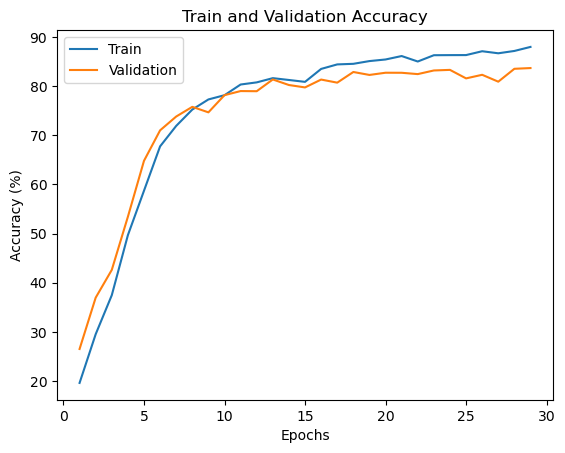

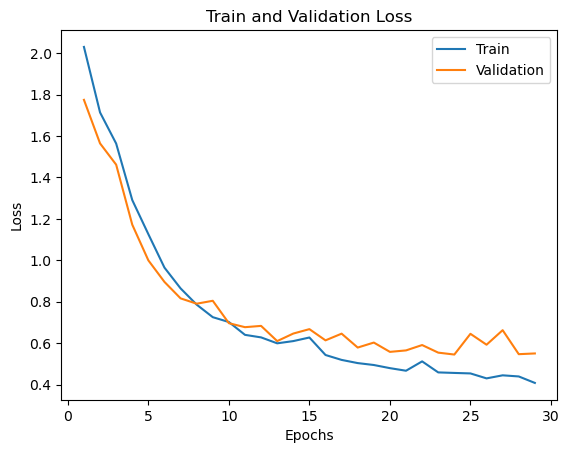

In [ ]:
# Pretrained VGG-16 model with default weights
model = vgg16(weights='DEFAULT').to(device)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs =50
patience = 5  
best_val_loss = float("inf")
best_model_weights = copy.deepcopy(model.state_dict())
early_stop_trigger = 0

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []
    global best_val_loss, best_model_weights, early_stop_trigger

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss.append(running_loss / total)
        train_acc.append(100 * correct / total)

        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss.append(val_running_loss / val_total)
        val_acc.append(100 * val_correct / val_total)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss[-1]:.4f}, "
              f"Train Acc: {train_acc[-1]:.2f}%, Val Loss: {val_loss[-1]:.4f}, "
              f"Val Acc: {val_acc[-1]:.2f}%")

        if val_loss[-1] < best_val_loss:
            best_val_loss = val_loss[-1]
            best_model_weights = copy.deepcopy(model.state_dict())
            early_stop_trigger = 0
            print(f"New best model found at epoch {epoch+1} with validation loss: {val_loss[-1]:.4f}")
        else:
            early_stop_trigger += 1
            print(f"No improvement in validation loss for {early_stop_trigger} epochs.")
            if early_stop_trigger >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_weights)
    return train_loss, train_acc, val_loss, val_acc

train_loss, train_acc, val_loss, val_acc = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, patience
)

# Plot
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def evaluate_test_set(model, test_loader, criterion):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    avg_test_loss = test_loss / total
    test_accuracy = 100 * correct / total
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    return avg_test_loss, test_accuracy
test_loss, test_accuracy = evaluate_test_set(model, test_loader, criterion)

Test Loss: 0.5400, Test Accuracy: 83.55%


Hyperparameter tuning

In [ ]:
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
best_model_path = "best_model_vgg16.pth"

best_overall_val_loss = float('inf')

def objective(trial):
    global best_overall_val_loss  
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)
    batch_size = trial.suggest_int('batch_size', 64, 512)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)
    model = vgg16(weights='DEFAULT').to(device)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scaler = GradScaler("cuda")

    num_epochs, patience, trials_without_improvement = 30, 5, 0
    best_trial_val_loss = float('inf') 

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast(device_type="cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        model.eval()
        val_loss = sum(criterion(model(images.to(device)), labels.to(device)).item() for images, labels in val_loader) / len(val_loader)

        if val_loss < best_trial_val_loss:
            best_trial_val_loss = val_loss
            trials_without_improvement = 0
        else:
            trials_without_improvement += 1

        if trials_without_improvement >= patience:
            print(f"Early stopping on epoch {epoch + 1}.")
            break

    if best_trial_val_loss < best_overall_val_loss:
        best_overall_val_loss = best_trial_val_loss

        torch.save({'model_state_dict': model.state_dict(), 
                    'learning_rate': learning_rate, 
                    'batch_size': batch_size, 
                    'weight_decay': weight_decay}, best_model_path)
        print(f"New best model saved with validation loss: {best_trial_val_loss}")

    return best_trial_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best parameters:", study.best_params)
print("Best validation loss:", study.best_value)
print(f"Best model saved at {best_model_path}")

[I 2024-11-05 23:13:36,301] A new study created in memory with name: no-name-fed2a429-6b19-4da4-83b3-2ee1bf05b331


Early stopping on epoch 15.


[I 2024-11-05 23:21:10,642] Trial 0 finished with value: 0.37721288750569026 and parameters: {'learning_rate': 0.00010540243110032783, 'batch_size': 167, 'weight_decay': 7.069242451646378e-05}. Best is trial 0 with value: 0.37721288750569026.


New best model saved with validation loss: 0.37721288750569026


[I 2024-11-05 23:23:54,782] Trial 1 finished with value: 2.3021132151285806 and parameters: {'learning_rate': 0.003059218741056326, 'batch_size': 373, 'weight_decay': 1.7425045034462243e-06}. Best is trial 0 with value: 0.37721288750569026.


Early stopping on epoch 9.


[I 2024-11-05 23:31:55,968] Trial 2 finished with value: 0.39059884207589285 and parameters: {'learning_rate': 0.0004994577519216299, 'batch_size': 478, 'weight_decay': 4.978267083942159e-06}. Best is trial 0 with value: 0.37721288750569026.


Early stopping on epoch 22.


[I 2024-11-05 23:44:13,972] Trial 3 finished with value: 0.48432170700382543 and parameters: {'learning_rate': 0.0012615114407873692, 'batch_size': 272, 'weight_decay': 1.5410239253332525e-05}. Best is trial 0 with value: 0.37721288750569026.
[I 2024-11-05 23:56:34,118] Trial 4 finished with value: 2.302890946990565 and parameters: {'learning_rate': 0.002381187834429832, 'batch_size': 88, 'weight_decay': 1.463111423705685e-06}. Best is trial 0 with value: 0.37721288750569026.


Early stopping on epoch 18.


[I 2024-11-05 23:59:39,442] Trial 5 finished with value: 2.2922112074765293 and parameters: {'learning_rate': 0.003196468501373553, 'batch_size': 464, 'weight_decay': 7.5476584482590555e-06}. Best is trial 0 with value: 0.37721288750569026.


Early stopping on epoch 11.


[I 2024-11-06 00:16:14,784] Trial 6 finished with value: 0.4479471285092203 and parameters: {'learning_rate': 0.0005136557543159785, 'batch_size': 106, 'weight_decay': 1.1072387862654185e-06}. Best is trial 0 with value: 0.37721288750569026.


Early stopping on epoch 26.


[I 2024-11-06 00:32:23,661] Trial 7 finished with value: 0.5519002047253818 and parameters: {'learning_rate': 0.0010589827380666785, 'batch_size': 123, 'weight_decay': 5.673778222813711e-05}. Best is trial 0 with value: 0.37721288750569026.


Early stopping on epoch 30.


[I 2024-11-06 00:38:24,016] Trial 8 finished with value: 0.3893821594260988 and parameters: {'learning_rate': 0.00020185930681937422, 'batch_size': 239, 'weight_decay': 1.0383899924318445e-05}. Best is trial 0 with value: 0.37721288750569026.


Early stopping on epoch 14.


[I 2024-11-06 00:47:58,679] Trial 9 finished with value: 0.47852092005989766 and parameters: {'learning_rate': 0.0008191578284674323, 'batch_size': 182, 'weight_decay': 5.30385046931013e-06}. Best is trial 0 with value: 0.37721288750569026.


Early stopping on epoch 20.


[I 2024-11-06 00:54:26,262] Trial 10 finished with value: 0.40144458926957227 and parameters: {'learning_rate': 0.0001144500047035733, 'batch_size': 347, 'weight_decay': 7.984305467354407e-05}. Best is trial 0 with value: 0.37721288750569026.


Early stopping on epoch 17.


[I 2024-11-06 01:00:41,199] Trial 11 finished with value: 0.3854125145336856 and parameters: {'learning_rate': 0.00010968991981046136, 'batch_size': 220, 'weight_decay': 2.3036408202407478e-05}. Best is trial 0 with value: 0.37721288750569026.


Early stopping on epoch 14.


[I 2024-11-06 01:07:16,284] Trial 12 finished with value: 0.3827319460419508 and parameters: {'learning_rate': 0.00010248159845172836, 'batch_size': 195, 'weight_decay': 3.234825000560017e-05}. Best is trial 0 with value: 0.37721288750569026.


Early stopping on epoch 14.


[I 2024-11-06 01:09:01,184] Trial 13 finished with value: 190275.9625 and parameters: {'learning_rate': 0.0072368227305594, 'batch_size': 154, 'weight_decay': 3.750758887373653e-05}. Best is trial 0 with value: 0.37721288750569026.


Early stopping on epoch 7.


[I 2024-11-06 01:13:39,908] Trial 14 finished with value: 0.38818977532848237 and parameters: {'learning_rate': 0.0002267061211369422, 'batch_size': 324, 'weight_decay': 9.792513034689714e-05}. Best is trial 0 with value: 0.37721288750569026.


Early stopping on epoch 12.
Early stopping on epoch 18.


[I 2024-11-06 01:22:04,677] Trial 15 finished with value: 0.36166062813114236 and parameters: {'learning_rate': 0.00025555777984133756, 'batch_size': 188, 'weight_decay': 3.282603073044825e-05}. Best is trial 15 with value: 0.36166062813114236.


New best model saved with validation loss: 0.36166062813114236


[I 2024-11-06 01:27:50,360] Trial 16 finished with value: 0.37716657080148397 and parameters: {'learning_rate': 0.0002372266094327356, 'batch_size': 264, 'weight_decay': 3.4730677046203065e-05}. Best is trial 15 with value: 0.36166062813114236.


Early stopping on epoch 14.


[I 2024-11-06 01:32:55,064] Trial 17 finished with value: 0.3784437901698626 and parameters: {'learning_rate': 0.00028207249340326553, 'batch_size': 397, 'weight_decay': 1.7003625144053412e-05}. Best is trial 15 with value: 0.36166062813114236.


Early stopping on epoch 14.


[I 2024-11-06 01:39:53,306] Trial 18 finished with value: 0.3820949591696262 and parameters: {'learning_rate': 0.0003766385381845784, 'batch_size': 253, 'weight_decay': 4.247643379012464e-05}. Best is trial 15 with value: 0.36166062813114236.


Early stopping on epoch 17.


[I 2024-11-06 01:46:35,051] Trial 19 finished with value: 0.39018553670714884 and parameters: {'learning_rate': 0.0001843485940748517, 'batch_size': 302, 'weight_decay': 2.3663225508982297e-05}. Best is trial 15 with value: 0.36166062813114236.


Early stopping on epoch 17.
Best parameters: {'learning_rate': 0.00025555777984133756, 'batch_size': 188, 'weight_decay': 3.282603073044825e-05}
Best validation loss: 0.36166062813114236
Best model saved at best_model_vgg16.pth


In [ ]:
# Load the best model and its parameters
best_model_path = "best_model_vgg16.pth"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the model's state dict
checkpoint = torch.load(best_model_path,weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

best_learning_rate = checkpoint['learning_rate']
best_batch_size = checkpoint['batch_size']
best_weight_decay = checkpoint['weight_decay']

correct = 0
total = 0

with torch.no_grad(): 
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

Accuracy of the model on the test set: 89.31%
